In [1]:
import os
import itertools
import xlsxwriter

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

import DataPreparation as dpr
import ModelRun as mr
import benchmarks as bench
from MyEstimators import CLS_Estimator

<Figure size 720x360 with 0 Axes>

# Load data

In [2]:
df = dpr.read_data('EQP_Quarterly')
df = dpr.data_clean(df, '1956-01-01')

In [3]:
df.head()

EQP        DP        DY        EP        DE      svar  \
time                                                                     
1956-03-01  0.066512 -3.333030 -3.269151 -2.575525 -0.757505  0.003289   
1956-06-01 -0.028264 -3.261722 -3.293365 -2.568575 -0.693147  0.003688   
1956-09-01 -0.034415 -3.204645 -3.239744 -2.573142 -0.631503  0.002519   
1956-12-01  0.033241 -3.289216 -3.260525 -2.616389 -0.672827  0.004394   
1957-03-01 -0.050750 -3.238565 -3.294980 -2.562911 -0.675654  0.002288   

                 b/m      ntis     tbl     lty  ...     TMS       DFR     DFY  \
time                                            ...                             
1956-03-01  0.531077  0.026695  0.0225  0.0303  ...  0.0078  0.005159  0.0050   
1956-06-01  0.551565  0.025672  0.0249  0.0299  ...  0.0050 -0.021824  0.0050   
1956-09-01  0.571910  0.029362  0.0284  0.0324  ...  0.0040  0.005663  0.0051   
1956-12-01  0.544177  0.026149  0.0321  0.0345  ...  0.0024 -0.002208  0.0062   
1957-03-01  0.599819  0.026600  0.0308  0.0331  ...  0.0023 -0.000368  0.0077   

                infl         c          w         y       cay     AAA     BAA  
time                                                                           
1956-03-01  0.000000  9.272498  11.092725  9.100386  0.007275  0.0310  0.0360  
1956-06-01  0.014925  9.271728  11.091665  9.107828  0.000775  0.0326  0.0376  
1956-09-01  0.007353  9.269304  11.086198  9.106428  0.000663  0.0356  0.0407  
1956-12-01  0.007299  9.277993  11.096678  9.118405 -0.002524  0.0375  0.0437  
1957-03-01  0.007246  9.280482  11.090721  9.117433  0.002041  0.0366  0.0443  

[5 rows x 21 columns]

## Add $y_{t-1}, y_{t-2}$ and construct X and y

In [4]:
df['y_lag'] = df['EQP'].shift(1)
df = df.dropna()
df.head()

EQP        DP        DY        EP        DE      svar  \
time                                                                     
1956-06-01 -0.028264 -3.261722 -3.293365 -2.568575 -0.693147  0.003688   
1956-09-01 -0.034415 -3.204645 -3.239744 -2.573142 -0.631503  0.002519   
1956-12-01  0.033241 -3.289216 -3.260525 -2.616389 -0.672827  0.004394   
1957-03-01 -0.050750 -3.238565 -3.294980 -2.562911 -0.675654  0.002288   
1957-06-01  0.075114 -3.309868 -3.238565 -2.628349 -0.681519  0.001363   

                 b/m      ntis     tbl     lty  ...       DFR     DFY  \
time                                            ...                     
1956-06-01  0.551565  0.025672  0.0249  0.0299  ... -0.021824  0.0050   
1956-09-01  0.571910  0.029362  0.0284  0.0324  ...  0.005663  0.0051   
1956-12-01  0.544177  0.026149  0.0321  0.0345  ... -0.002208  0.0062   
1957-03-01  0.599819  0.026600  0.0308  0.0331  ... -0.000368  0.0077   
1957-06-01  0.565877  0.030528  0.0329  0.0361  ... -0.003789  0.0072   

                infl         c          w         y       cay     AAA     BAA  \
time                                                                            
1956-06-01  0.014925  9.271728  11.091665  9.107828  0.000775  0.0326  0.0376   
1956-09-01  0.007353  9.269304  11.086198  9.106428  0.000663  0.0356  0.0407   
1956-12-01  0.007299  9.277993  11.096678  9.118405 -0.002524  0.0375  0.0437   
1957-03-01  0.007246  9.280482  11.090721  9.117433  0.002041  0.0366  0.0443   
1957-06-01  0.010791  9.278119  11.104916  9.118823 -0.004528  0.0391  0.0463   

               y_lag  
time                  
1956-06-01  0.066512  
1956-09-01 -0.028264  
1956-12-01 -0.034415  
1957-03-01  0.033241  
1957-06-01 -0.050750  

[5 rows x 22 columns]

In [5]:
df_AR2 = df.copy()
df_AR2['y_2lag'] = df['y_lag'].shift(1)
df_AR2 = df_AR2.dropna()
df_AR2.head()

EQP        DP        DY        EP        DE      svar  \
time                                                                     
1956-09-01 -0.034415 -3.204645 -3.239744 -2.573142 -0.631503  0.002519   
1956-12-01  0.033241 -3.289216 -3.260525 -2.616389 -0.672827  0.004394   
1957-03-01 -0.050750 -3.238565 -3.294980 -2.562911 -0.675654  0.002288   
1957-06-01  0.075114 -3.309868 -3.238565 -2.628349 -0.681519  0.001363   
1957-09-01 -0.108352 -3.182306 -3.292675 -2.503465 -0.678841  0.004218   

                 b/m      ntis     tbl     lty  ...     DFY      infl  \
time                                            ...                     
1956-09-01  0.571910  0.029362  0.0284  0.0324  ...  0.0051  0.007353   
1956-12-01  0.544177  0.026149  0.0321  0.0345  ...  0.0062  0.007299   
1957-03-01  0.599819  0.026600  0.0308  0.0331  ...  0.0077  0.007246   
1957-06-01  0.565877  0.030528  0.0329  0.0361  ...  0.0072  0.010791   
1957-09-01  0.624151  0.034363  0.0353  0.0364  ...  0.0081  0.007117   

                   c          w         y       cay     AAA     BAA     y_lag  \
time                                                                            
1956-09-01  9.269304  11.086198  9.106428  0.000663  0.0356  0.0407 -0.028264   
1956-12-01  9.277993  11.096678  9.118405 -0.002524  0.0375  0.0437 -0.034415   
1957-03-01  9.280482  11.090721  9.117433  0.002041  0.0366  0.0443  0.033241   
1957-06-01  9.278119  11.104916  9.118823 -0.004528  0.0391  0.0463 -0.050750   
1957-09-01  9.281519  11.089344  9.117364  0.003433  0.0412  0.0493  0.075114   

              y_2lag  
time                  
1956-09-01  0.066512  
1956-12-01 -0.028264  
1957-03-01 -0.034415  
1957-06-01  0.033241  
1957-09-01 -0.050750  

[5 rows x 23 columns]

# Construct single-index and nonlinear models

## Single-index

In [6]:
def single_index(x):
    if isinstance(x, (pd.DataFrame, np.ndarray)):
        if isinstance(x, pd.DataFrame):
            x_values = x.values
        else:
            pass
    else:
        raise Exception('wrong type')

    def u(theta):
        if len(theta) == x_values.shape[1]:
            sum_up = [x_values[:, i] * theta[i] for i in range(x_values.shape[1])]
            index = np.sum(sum_up, axis=0)
        else:
            raise Exception('wrong parameter dimension')
        return index

    return u

### dimension function

In [7]:
extra_params = {'sin_func':1,
               'cos_func':1,
               'scaled_sin_func':2,
               'scaled_cos_func':2,
               'exp_func':2,
               'exp_shift_func':2,
                'poly_func':3,
                'linear_func':2
               }

In [8]:
def dimensions(non_sta, sta, func):
    stas = sta.shape[1]
    nonstas = non_sta.shape[1]
    extra = range(0, extra_params[func])
    return nonstas, stas, extra

## Nonlienar Models

In [9]:
def sin_func(x):
    def objective_func(params):
        func = np.sin(single_index(x.iloc[:,:d1])(params[0:d1])+params[d1+d2+extra[0]])+np.dot(
            x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [10]:
def cos_func(x):
    def objective_func(params):
        func = np.cos(single_index(x.iloc[:,:d1])(params[0:d1])+params[d1+d2+extra[0]])+np.dot(
            x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [11]:
def scaled_sin_func(x):
    def objective_func(params):
        func = np.sin(params[d1+d2+extra[1]]*single_index(x.iloc[:,:d1])(
            params[0:d1])+params[d1+d2+extra[0]])+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [12]:
def scaled_cos_func(x):
    def objective_func(params):
        func = np.cos(params[d1+d2+extra[1]]*single_index(x.iloc[:,:d1])(
            params[0:d1])+params[d1+d2+extra[0]])+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [13]:
def exp_shift_func(x):
    def objective_func(params):
        func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
            params[0:d1]))-params[d1+d2+extra[0]])**2)+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [14]:
def exp_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(params[0:d1]))**2
                                )+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [15]:
def poly_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]+params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
            params[0:d1]))+params[d1+d2+extra[2]]*((single_index(x.iloc[:,:d1])(
            params[0:d1]))**2)+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
#                (single_index(x.iloc[:,:d1])(params[0:d1])
        return func
    return objective_func

In [16]:
def linear_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]+params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
            params[0:d1]))+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
#                (single_index(x.iloc[:,:d1])(params[0:d1])
        return func
    return objective_func

### Constraint

In [17]:
def constraint_func(x):
    def constraint(params):
        con = 0
        for j in np.arange(0, x.iloc[:,:d1].shape[1]):
            con += params[j]**2
            cons = con - 1
        return cons
    return {'type':'eq', 'fun': constraint}

## Empirical Study

### Cointegrated predictors
- dividend-price ratio and dividend yield
- T-bill rate and long-term yield
- dividend-price ratio and earningprice ratio
- baa- and aaa-rated corporate bond yields

In [18]:
co1 = df[['DP', 'DY']]
co2 = df[['tbl', 'lty']]
co3 = df[['DP', 'EP']]
co4 = df[['BAA', 'AAA']]
y = df[['EQP']].squeeze()

station_ar1 = df[['y_lag', 'cay']]

cointe_ar1 = [co1, co2, co3, co4]
names_ar1 = ['co1', 'co2', 'co3', 'co4']

for i in range(len(cointe_ar1)):
    cointe_ar1[i].name = names_ar1[i]

In [23]:
co1_ar2 = df_AR2[['DP', 'DY']]
co2_ar2 = df_AR2[['tbl', 'lty']]
co3_ar2 = df_AR2[['DP', 'EP']]
co4_ar2 = df_AR2[['BAA', 'AAA']]
station_ar2 = df_AR2[['y_lag', 'cay']]

y_lag2 = df_AR2[['EQP']].squeeze()

X_train_AR2 = df_AR2.loc[:"1988-01-01"]
y_train_AR2 = y_lag2.loc[:"1988-01-01"]

X_test_AR2 = df_AR2.loc["1988-01-01":"2018-12-01"]
y_test_AR2 = y_lag2.loc["1988-01-01":"2018-12-01"]
station_ar2 = df_AR2.loc[:"1988-01-01"][['y_lag', 'cay']]

cointe_ar2 = [co1_ar2, co2_ar2, co3_ar2, co4_ar2]
names_ar2 = ['co1', 'co2', 'co3', 'co4']

for i in range(len(cointe_ar1)):
    cointe_ar2[i].name = names_ar2[i]

### Stationary variables

### Fit model and Save Results

In [26]:
fun_list = [sin_func,
            cos_func,
            scaled_sin_func,
            scaled_cos_func,
            exp_func,
            exp_shift_func,
            poly_func,
            linear_func
           ]

In [21]:
# Set up hierachical index
fun_names = [i.__name__ for i in fun_list]
cointe_names = [i.name for i in cointe_ar1]
iterables = [fun_names, cointe_names]

In [22]:
#Set up directory
parent = os.getcwd()
folder = 'results'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

In [23]:
results = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    ################################# Set up dimensions ######################################
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    ###################################### Set up X ##########################################
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, options={'maxiter':50000})
    cls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, constraints = constraint_func(X_), options={'maxiter':50000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_
    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results = results.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results.to_excel('results/full_sample.xlsx')

## Use initial values from Linear regression (using Taylor expansion)

In [20]:
orders = {'sin_func':1,
          'cos_func':2,
          'scaled_sin_func':1,
          'scaled_cos_func':2,
          'exp_func':5,
          'exp_shift_func':4,
          'poly_func':2,
          'linear_func':1
               }

In [21]:
def Taylor_init(variables, station, y, function):
    
    d1, d2, extra = dimensions(variables, station, function.__name__)
    
    # find the initials for theta
    LR = LinearRegression()
    LR_theta = LR.fit(variables.iloc[:,1:], variables.iloc[:,:1])
    alpha = np.append(1, -LR_theta.coef_)
    theta = np.array(-alpha/np.linalg.norm(alpha))
#     print(len(theta))
    
    # calculate single-index
    u = single_index(variables)(theta)
    
    # find the initials for beta
    Xs = station.copy()
#     print(Xs.shape[1])
    Xs['u'], Xs['u2'], Xs['u3'], Xs['u4'], Xs['u6'] = u, u**2, u**3, u**4, u**6
    t_order = orders.get(function.__name__)
    
    if function == exp_func:
        X_reg = Xs.iloc[:, 0:d2+t_order].drop(['u', 'u3'], axis = 1)
    else:
        X_reg = Xs.iloc[:, 0:d2+t_order]
#     print(d2, t_order)
    LR_taylor = LR.fit(X_reg, y)
    theta_gamma = np.append(theta,LR_taylor.coef_[:d2])
#     print(len(theta_gamma))
    
    
    # initials for gammas
    initials = []
    if function == sin_func:
        initials = np.append(theta_gamma, LR_taylor.intercept_)
    elif function == scaled_sin_func:
        initials = np.append(theta_gamma, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == linear_func:
        initials = np.append(theta_gamma, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == poly_func:
        ini_poly_ = np.append(theta_gamma,LR_taylor.coef_[d2:])
        initials = np.insert(ini_poly_, 4, LR_taylor.intercept_)
    elif function == cos_func:
        initials = np.append(theta_gamma, [-LR_taylor.coef_[d2]])
    elif function == scaled_cos_func:
        initials = np.append(theta_gamma,(
            [-LR_taylor.coef_[d2]/np.sqrt(np.abs((1-LR_taylor.intercept_)*2))], [np.sqrt(np.abs((1-LR_taylor.intercept_)*2))]))
    elif function == exp_shift_func:
        initials = np.append(theta_gamma, [LR_taylor.coef_[-2]/(2*LR_taylor.coef_[-1]), np.sqrt(np.abs(LR_taylor.coef_[-1]))])
#         print(LR_taylor.coef_, LR_taylor.coef_[-2])
    elif function == exp_func:
        # initials =np.append(theta_gamma, [LR_taylor.intercept_, -LR_taylor.coef_[d2]/LR_taylor.intercept_])
        initials =np.append(theta_gamma, [LR_taylor.intercept_, LR_taylor.coef_[d2]])

    return initials

# Fit model and Save Results

In [27]:
results_Taylor = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    # Set up dimensions
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    # Prepare X
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), options={'maxiter':1000000})
    cls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), constraints = constraint_func(X_), 
                        options={'maxiter':1000000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_
    print(i.__name__, j.name)
    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results_Taylor = results_Taylor.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results_Taylor.to_excel('results/Taylor_fullsample.xlsx')
results_Taylor.tail()

sin_func co1
sin_func co2
sin_func co3
sin_func co4
cos_func co1
cos_func co2
cos_func co3
cos_func co4
scaled_sin_func co1
scaled_sin_func co2
scaled_sin_func co3
scaled_sin_func co4
scaled_cos_func co1
scaled_cos_func co2
scaled_cos_func co3
scaled_cos_func co4
exp_func co1
exp_func co2
exp_func co3
exp_func co4
exp_shift_func co1
exp_shift_func co2
exp_shift_func co3
exp_shift_func co4
poly_func co1
poly_func co2
poly_func co3
poly_func co4
linear_func co1
linear_func co2
linear_func co3
linear_func co4


Estimator                   CLS                                          \
Parameters              param_1   param_2   param_3   param_4   param_5   
function    variables                                                     
poly_func   co4       -0.639086  0.769135  0.029136  0.222809  0.029647   
linear_func co1       -0.709067  0.705141  0.000527 -0.075851 -0.023234   
            co2       -0.751669  0.659541  0.066719 -0.248713  0.003689   
            co3       -0.999994 -0.003533  0.059013 -0.223997 -0.083196   
            co4        0.476826 -0.878998  0.076501 -0.090205  0.023524   

Estimator                                          NLS                      \
Parameters              param_6      param_7   param_1   param_2   param_3   
function    variables                                                        
poly_func   co4        0.171965 -1066.824925 -0.647757  0.777973  0.028445   
linear_func co1        1.416036          NaN -1.080529  1.074592  0.000564   
            co2         1.04774          NaN -0.857493  0.752474  0.066743   
            co3        0.026346          NaN -0.780052 -0.003462  0.059018   
            co4        0.528158          NaN -1.472723 -0.020689  0.072875   

Estimator                                                         
Parameters              param_4   param_5   param_6      param_7  
function    variables                                             
poly_func   co4        0.229783  0.030041 -0.098698 -1066.754869  
linear_func co1       -0.075504 -0.023073  0.928931          NaN  
            co2       -0.249108  0.003693  0.919095          NaN  
            co3       -0.223942 -0.083234  0.033766          NaN  
            co4       -0.111111  0.024863  0.113793          NaN

In [28]:
results_Taylor

Estimator                       CLS                                           \
Parameters                  param_1   param_2   param_3   param_4    param_5   
function        variables                                                      
sin_func        co1       -0.709831  0.704372  0.022482 -0.105361  -0.018576   
                co2       -0.756221  0.654316  0.067078 -0.241745   0.004572   
                co3       -0.715438  0.698677 -0.221703 -0.790292  -0.576272   
                co4       -0.761685  0.647948   0.06769 -0.137607   0.026905   
cos_func        co1       -0.709842  0.704361  0.022494 -0.105349  -1.589442   
                co2       -0.756206  0.654334   0.06692 -0.241842  -1.566229   
                co3       -0.678465  0.734633  0.322686  0.325629   1.202308   
                co4       -0.574133  0.818762  0.079255 -0.074912  32.964214   
scaled_sin_func co1       -0.709086  0.705122  0.000797 -0.077841  -0.023634   
                co2        -0.75149  0.659745  0.066715 -0.248793   0.003674   
                co3       -0.999994 -0.003449  0.059006    -0.224  -0.083217   
                co4        0.475317 -0.879815  0.076475 -0.090293   0.023536   
scaled_cos_func co1       -0.709068   0.70514  0.000899 -0.076231  -1.594249   
                co2       -0.752034  0.659124  0.066861 -0.248129   -1.56707   
                co3       -0.767708  0.640799  0.067778 -0.182105   1.580152   
                co4       -0.483607  0.875285  0.076601 -0.089606   1.547322   
exp_func        co1       -0.814028  0.580826  0.102023 -0.189651  -0.017952   
                co2       -0.938458  0.345393  0.070003 -0.150979   0.016927   
                co3       -0.972991 -0.230841  0.070779 -0.209115   0.001374   
                co4       -0.549061  0.835782  0.075699 -0.120079   0.015935   
exp_shift_func  co1       -0.707521  0.706692  0.083201   -0.1822   0.073713   
                co2       -0.731535  0.681804  0.067945 -0.225439   -0.02013   
                co3       -0.048219  0.998837 -1.985172  2.266877 -23.629613   
                co4        -0.66623  0.745746  0.041818  0.145707  -0.002983   
poly_func       co1       -0.709069  0.705139  0.000653 -0.075503  -0.023284   
                co2       -0.724389  0.689391  0.067567 -0.272215   0.000857   
                co3       -0.979849  0.199741  0.034161 -0.160347  -0.829904   
                co4       -0.639086  0.769135  0.029136  0.222809   0.029647   
linear_func     co1       -0.709067  0.705141  0.000527 -0.075851  -0.023234   
                co2       -0.751669  0.659541  0.066719 -0.248713   0.003689   
                co3       -0.999994 -0.003533  0.059013 -0.223997  -0.083196   
                co4        0.476826 -0.878998  0.076501 -0.090205   0.023524   

Estimator                                                       NLS  \
Parameters                     param_6      param_7         param_1   
function        variables                                             
sin_func        co1                NaN          NaN       -1.008332   
                co2                NaN          NaN       -0.776286   
                co3                NaN          NaN       -0.026355   
                co4                NaN          NaN        0.257727   
cos_func        co1                NaN          NaN       -1.008559   
                co2                NaN          NaN       -0.778349   
                co3                NaN          NaN        0.026413   
                co4                NaN          NaN       -0.246505   
scaled_sin_func co1           1.422698          NaN         -1.0424   
                co2           1.048277          NaN       -0.859137   
                co3           0.026354          NaN       -0.677667   
                co4            0.52465          NaN       -1.472687   
scaled_cos_func co1           1.422193          NaN        1.308551   
                co2           1.047415          NaN       -0.68

### GridSearch and CrossValidation

### Train_test split

In [22]:
# val_length = 1
test_length = 31
step = 1
### quarterly data:4
freq = 4
# cv_outer = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=int((12/step) * test_length), test_size=step)
# cv_inner = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=int((12/step) * val_length), test_size=step)
cv_outer = TimeSeriesSplit(max_train_size=None, n_splits=test_length*freq, test_size=step, gap=0)
# cv_inner = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=step)

### set up dataframes for results

In [23]:
fun_list = [sin_func, cos_func, scaled_sin_func, scaled_cos_func, exp_shift_func, exp_func, poly_func, linear_func]

In [31]:
oos_MSE = pd.DataFrame()

rows = df.loc["1988-01-01":"2018-12-01"].index
sec_columns = ['CLS_MSE', 'SM_MSE', 'NLS_MSE', 'AR1_MSE', 'AR2_MSE', 'AR_cay_MSE']
multi_columns = pd.MultiIndex.from_product([['co1', 'co2', 'co3', 'co4'], sec_columns],names=['Variable', 'Model'])
        
oos_MSE = pd.DataFrame(index = multi_columns, columns = rows)

#### The block below is used to test the OOS results only

In [338]:
# station_temp = station_ar2['cay'].to_frame()
# station_temp.loc[:"1988-01-01"]

x0 = Taylor_init(co1_ar2.loc[:"1988-01-01"], station_ar2.loc[:"1988-01-01"], y_train_AR2.loc[:"1988-01-01"], exp_func)
X_ = co1_ar2.join(station_ar2) 
d1, d2, extra= dimensions(co1_ar2,station_ar2, exp_func.__name__)
# # cls = CLS_Estimator(obj_func = sin_func, x0 = x0, constraints = constraint_func(X_))
# cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))
# cv_result = cross_validate(cls, X_, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')

# mse_s0 = cv_result['test_score']
# mse_s0[:5]
# mse_st = cv_result['test_score']
# mse_st[:5]

a = []
for train_index, test_index in cv_outer.split(X_):
    X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index, :]
    y_train, y_test = y_lag2.iloc[train_index], y_lag2.iloc[test_index]
    cls = CLS_Estimator(obj_func = exp_func, x0 = x0, constraints = constraint_func(X_))
#     cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))
    cls.fit(X_train, y_train)
    a.append(cls.params_)
a = pd.DataFrame(a)
a.to_excel('coefs_g6.xlsx', sheet_name = 'both')

## Generate OOS MSE

### Starting Values: 0

In [35]:
writer_MSE = pd.ExcelWriter('results/OOS_MSE_start0.xlsx', engine='xlsxwriter')
        
for i in fun_list:
    print(i.__name__)
    for j in cointe_ar2:    
        # Prepare X
        X_ = j.join(station_ar2) 

        # Target model
        d1, d2, extra= dimensions(j,station_ar2, i.__name__)
        
        cls = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))
        cv_result = cross_validate(cls, X_, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['CLS_MSE'] = -cv_result['test_score']
        
        ##################################### no need to loop! ##############################################################
        # benchmark model: sm
        sm_pred, sm_mse = bench.sample_mean(y_lag2, "1988-01-01", cv_outer = cv_outer)
        oos_MSE.loc[j.name].loc['SM_MSE'] = sm_mse

        # benchmark model: Nonlinear
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        
        nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
        cv_nonlinear = cross_validate(nlr, j, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['NLS_MSE'] = -cv_nonlinear['test_score']    

        # benchmark model: AR1
        lr = LinearRegression()
        
        ar1 = df_AR2['y_lag']
        cv_ar1 = cross_validate(
            lr, ar1.values.reshape(-1, 1), y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR1_MSE'] = -cv_ar1['test_score']
        
        # AR2
        ar2 = df_AR2[['y_lag','y_2lag']]
        cv_ar2 = cross_validate(
            lr, ar2, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR2_MSE'] = -cv_ar2['test_score']

        # benchmark model: AR+cay
        ar_cay = df_AR2[['y_lag','cay']]
        cv_cay = cross_validate(
            lr, ar_cay, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR_cay_MSE'] = -cv_cay['test_score']

        ####################################################################################################
        oos_MSE.T.to_excel(writer_MSE, sheet_name=i.__name__)
        
writer_MSE.save()
writer_MSE.close()

sin_func
cos_func
scaled_sin_func
scaled_cos_func
exp_shift_func
exp_func
poly_func
linear_func


### Starting Values: from taylors

In [36]:
writer_MSE = pd.ExcelWriter('results/OOS_MSE_taylor.xlsx', engine='xlsxwriter')
        
for i in fun_list:
    print(i.__name__)
    for j in cointe_ar2:
        # Prepare X
        X_ = j.join(station_ar2) 

        # Fit models
        x0 = Taylor_init(j.loc[:"1988-01-01"], station_train.loc[:"1988-01-01"], y_train_AR2.loc[:"1988-01-01"], i)

        # Target model
        d1, d2, extra= dimensions(j,station_ar2, i.__name__)
        
        cls = CLS_Estimator(obj_func = i, x0 = x0, constraints = constraint_func(X_))
        cv_result = cross_validate(cls, X_, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['CLS_MSE'] = -cv_result['test_score']
        
        ##################################### no need to loop! ##############################################################
        # benchmark model: sm
        sm_pred, sm_mse = bench.sample_mean(y_lag2, "1988-01-01", cv_outer = cv_outer)
        oos_MSE.loc[j.name].loc['SM_MSE'] = sm_mse

        # benchmark model: Nonlinear
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        x0_n = Taylor_init(j.loc[:"1988-01-01"], station_n, y_train_AR2.loc[:"1988-01-01"], i)
        
        nlr = CLS_Estimator(obj_func = i, x0 = x0_n, constraints = constraint_func(j))
        cv_nonlinear = cross_validate(nlr, j, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['NLS_MSE'] = -cv_nonlinear['test_score']    

        # benchmark model: AR1
        lr = LinearRegression()
        
        ar1 = df_AR2['y_lag']
        cv_ar1 = cross_validate(
            lr, ar1.values.reshape(
                -1, 1), y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR1_MSE'] = -cv_ar1['test_score']
        
        # AR2
        ar2 = df_AR2[['y_lag','y_2lag']]
        cv_ar2 = cross_validate(
            lr, ar2, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR2_MSE'] = -cv_ar2['test_score']

        # benchmark model: AR+cay
        ar_cay = df_AR2[['y_lag','cay']]
        cv_cay = cross_validate(
            lr, ar_cay, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR_cay_MSE'] = -cv_cay['test_score']

        ####################################################################################################
        oos_MSE.T.to_excel(writer_MSE, sheet_name=i.__name__)
        
writer_MSE.save()
writer_MSE.close()

sin_func
cos_func
scaled_sin_func
scaled_cos_func
exp_shift_func
exp_func
poly_func
linear_func


## $R^2$ Statistics

### In-sample $R^2$

In [262]:
base = ['SM',
       'NLS',
       'AR1',
       'AR2',
       'AR_cay']

In [263]:
co_list = ['co1', 'co2', 'co3', 'co4']
co_dict = {'co1': 'dy and dp',
          'co2': 'tbl and lty',
          'co3': 'dp and ep',
          'co4': 'BAA and AAA'}

In [269]:
oos_MSE = pd.read_excel('results/OOS_MSE_taylor.xlsx', header=[0,1], index_col=[0])

In [339]:
cumulate_R2 = pd.DataFrame()

rows = oos_MSE.loc["1988-01-01":"2018-12-01"].index
sec_columns_R2 = ['SM', 'NLS', 'AR1', 'AR2', 'AR_cay']
multi_columns_R2 = pd.MultiIndex.from_product([['co1', 'co2', 'co3', 'co4'], sec_columns_R2],
                                                  names=['Variable', 'Model'])      
cumulate_R2 = pd.DataFrame(index = multi_columns_R2, columns = rows)

In [340]:
writer_R2 = pd.ExcelWriter('results/OOS_R2_taylor.xlsx', engine='xlsxwriter')

for f in fun_list:
    oos_MSE = pd.read_excel('results/OOS_MSE_taylor.xlsx', header=[0,1], index_col=0, sheet_name = f.__name__)
    for i, j in itertools.product(base, co_list):
        cumu_sum = []
        target_sum = []
        cumu_R2 = []
        k = i + '_MSE'
        for R in range(len(oos_MSE[j][k])):
            target_sum.append(oos_MSE[j]['CLS_MSE'][:(R+1)].sum())
            cumu_sum.append(oos_MSE[j][k][:(R+1)].sum())
        cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
        cumulate_R2.loc[j].loc[i] = cumu_R2
    cumulate_R2.T.to_excel(writer_R2, sheet_name=f.__name__)
writer_R2.save()
writer_R2.close()

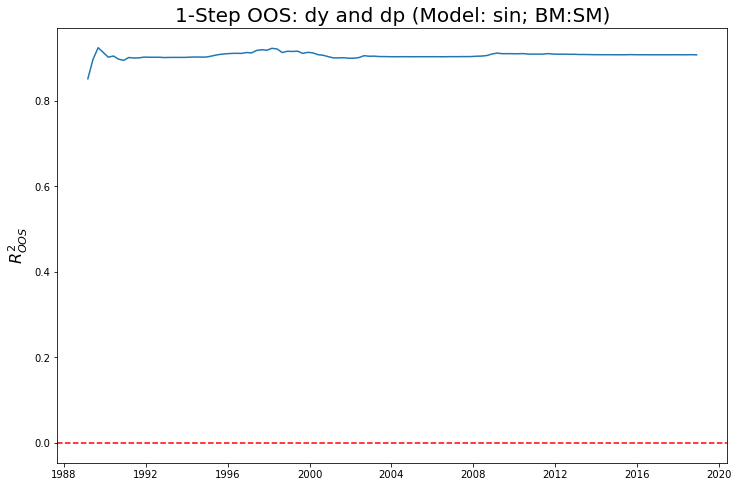

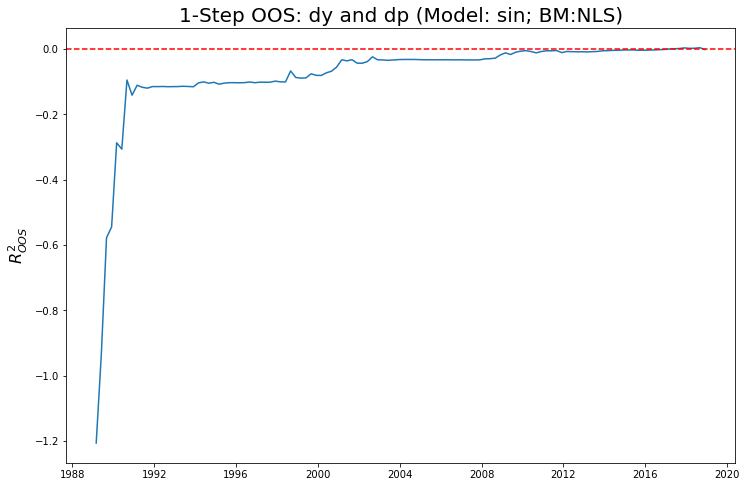

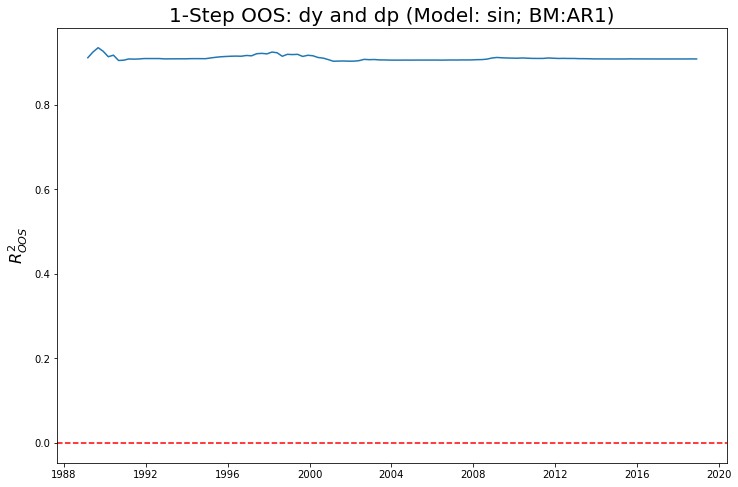

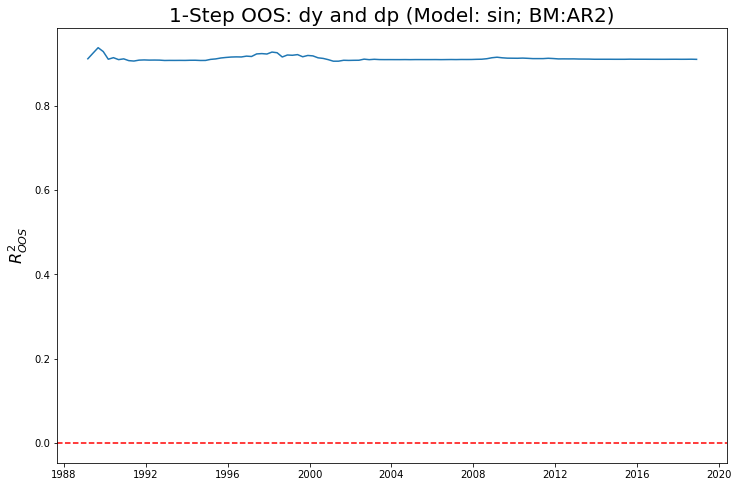

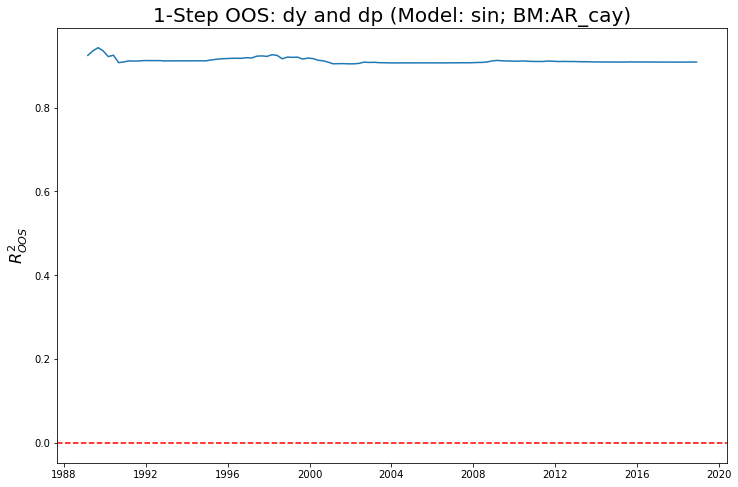

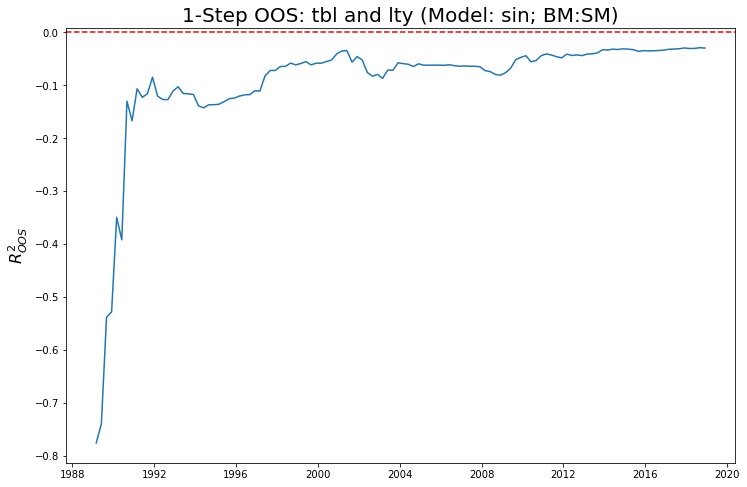

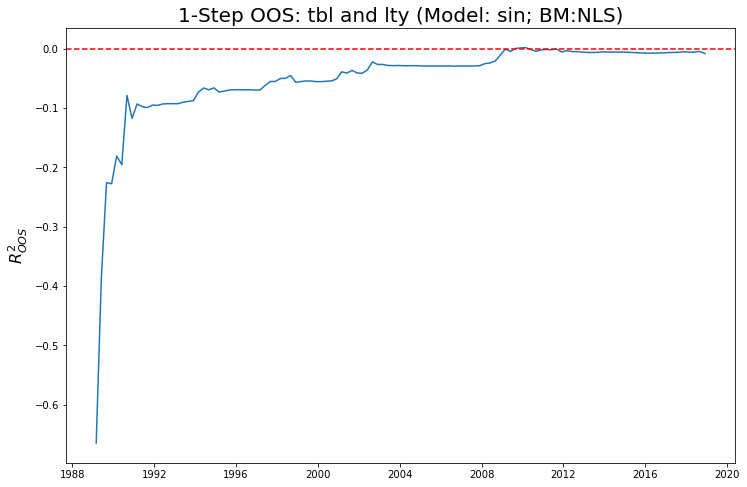

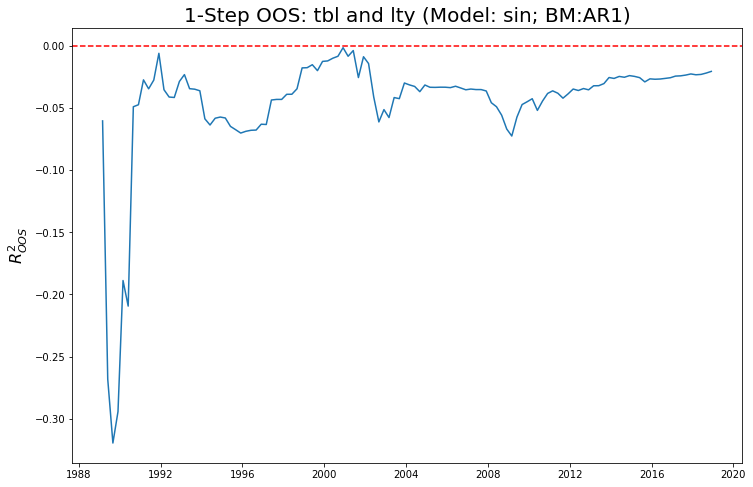

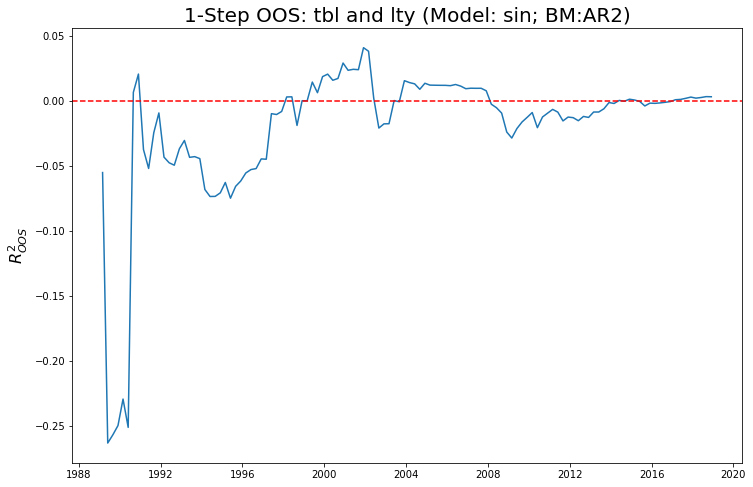

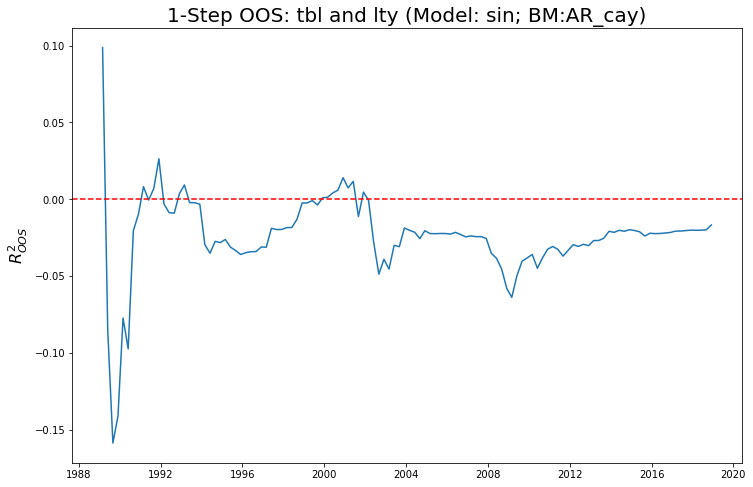

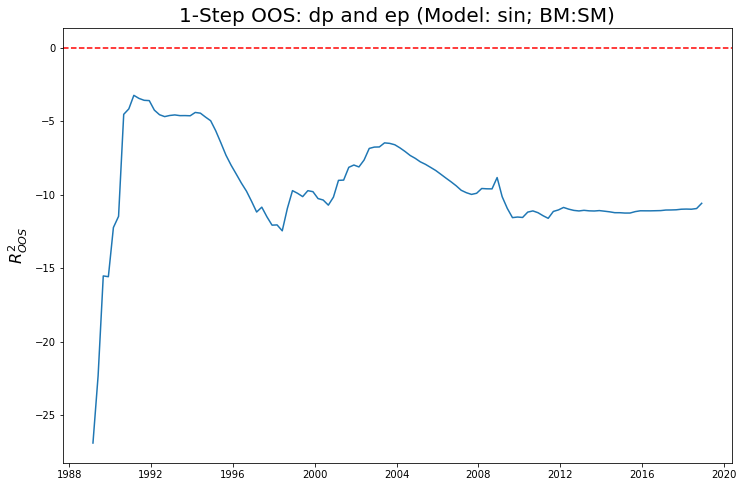

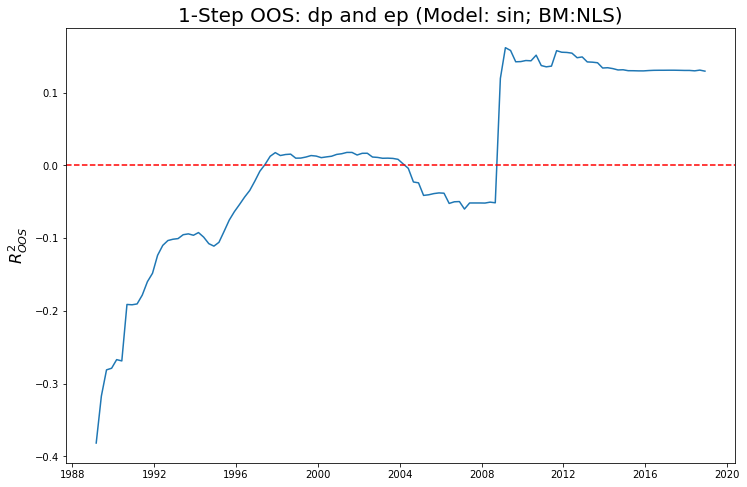

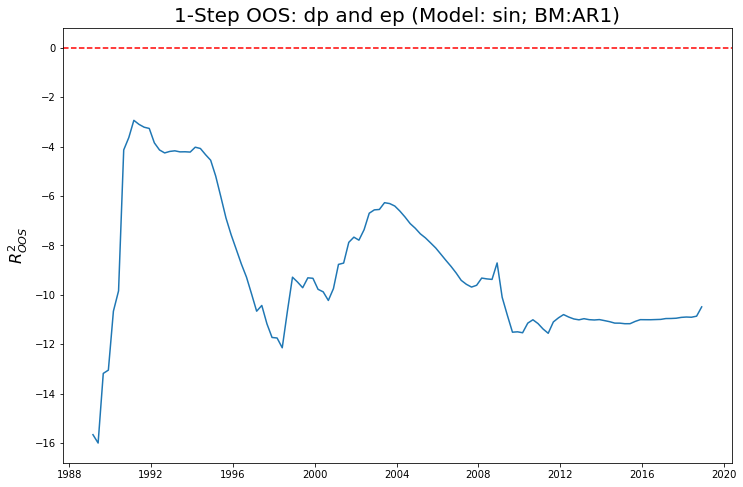

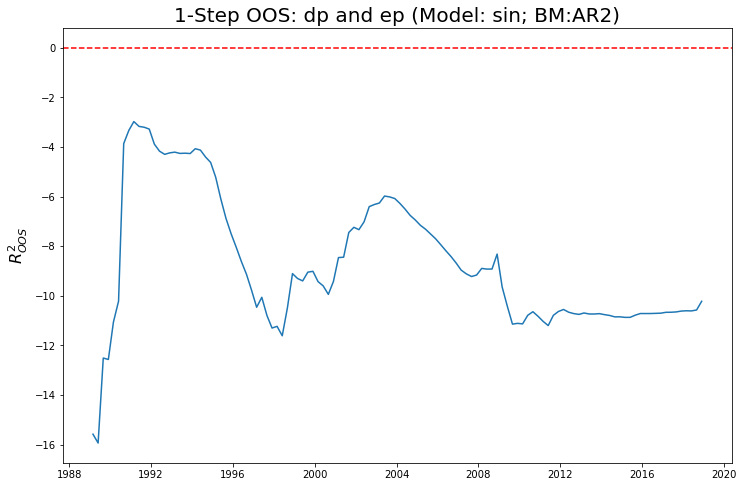

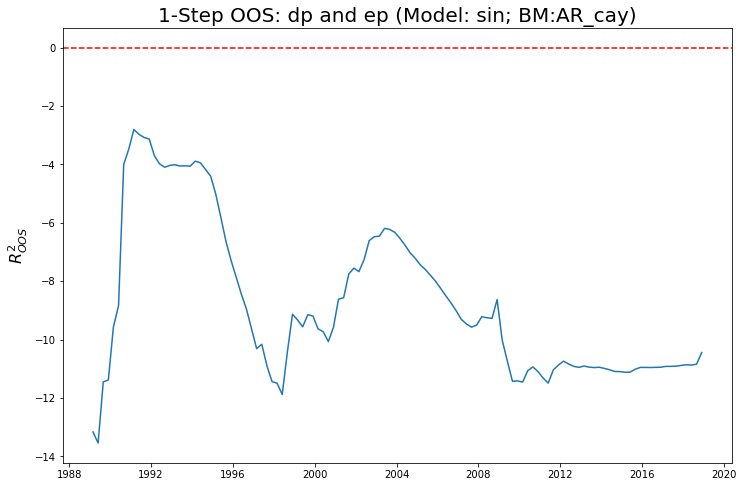

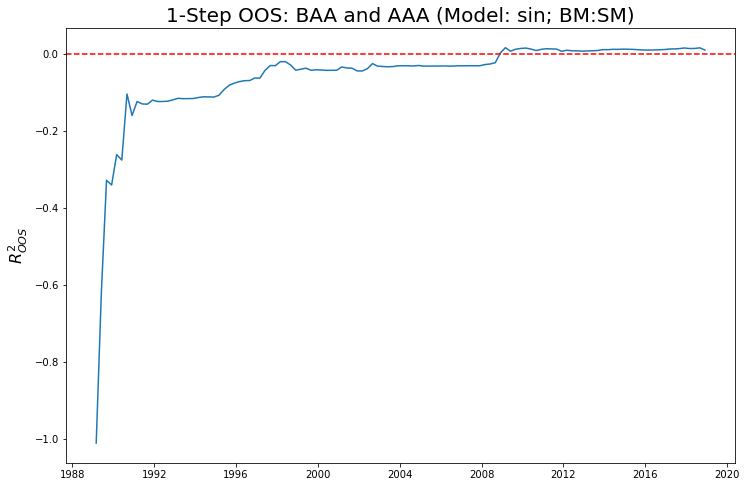

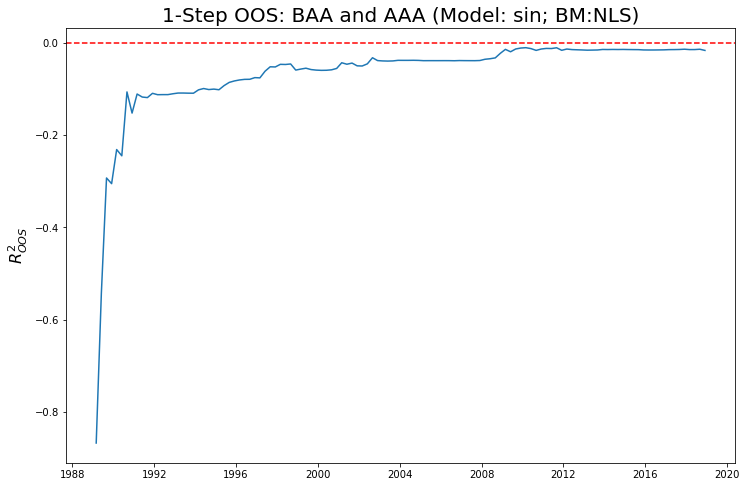

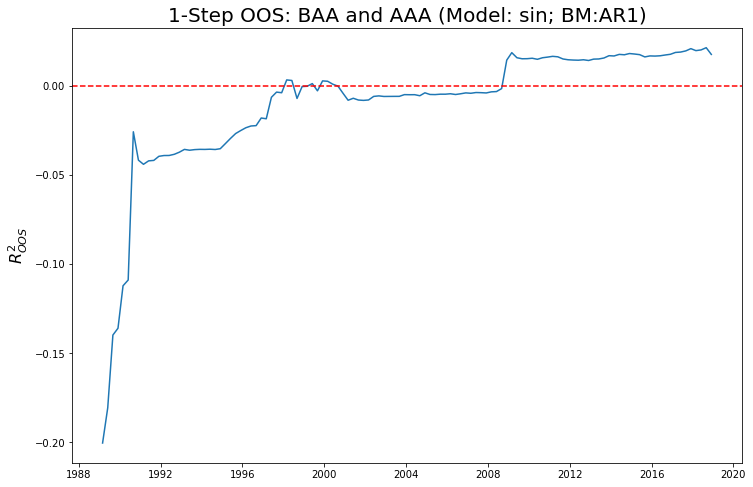

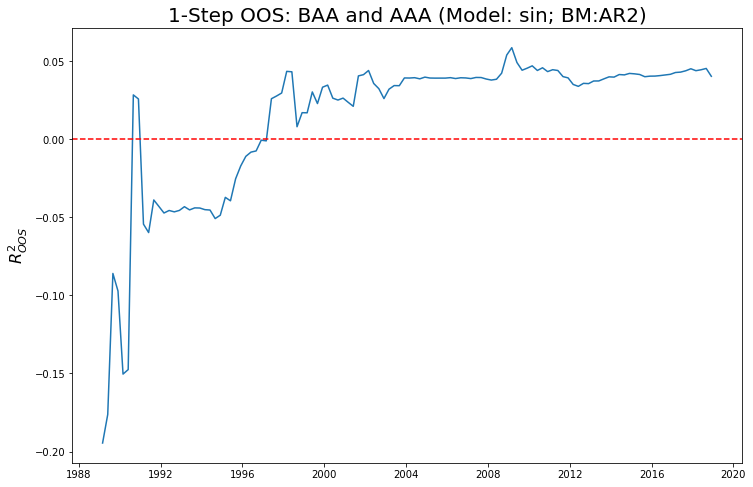

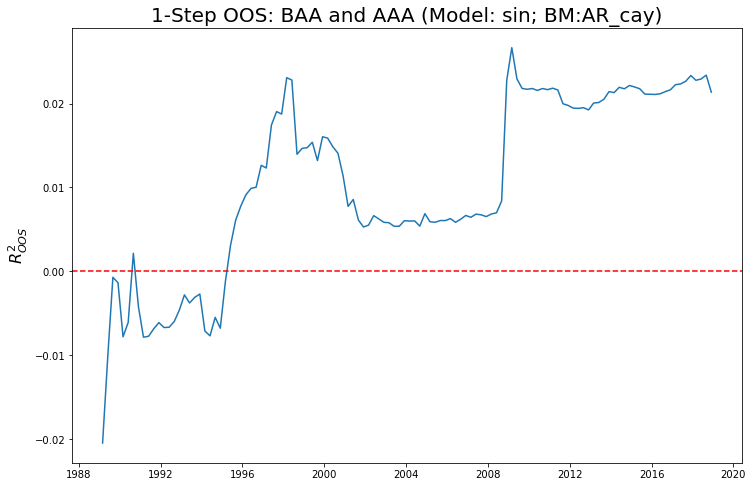

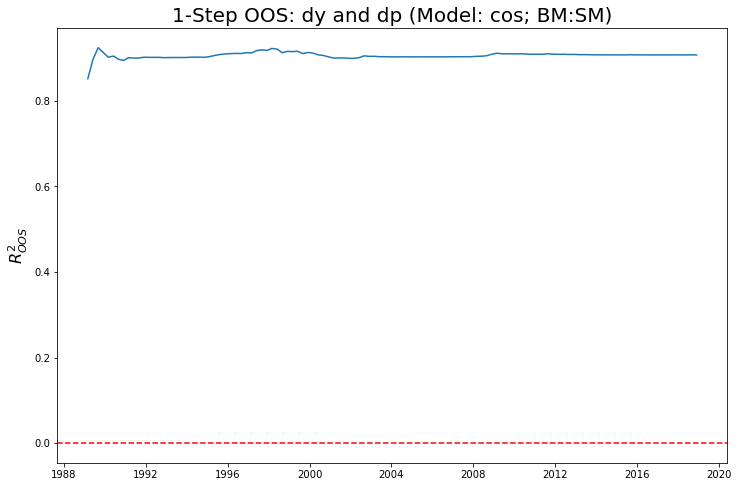

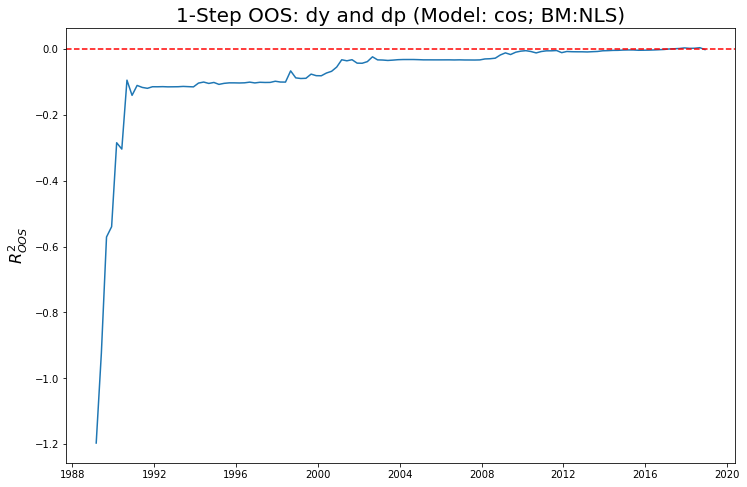

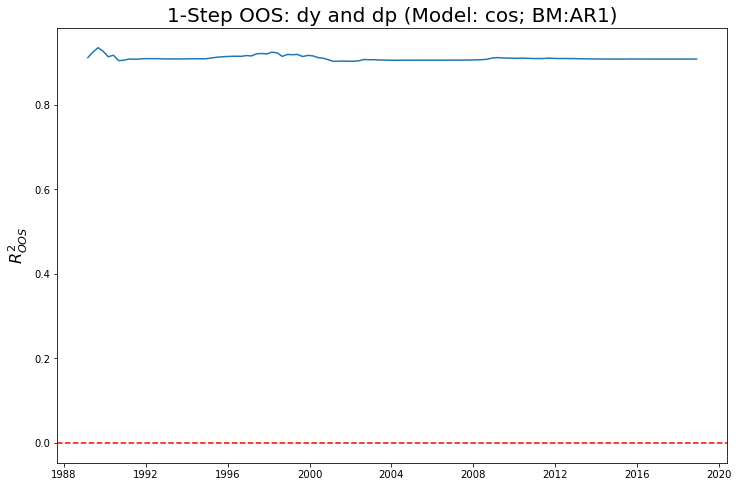

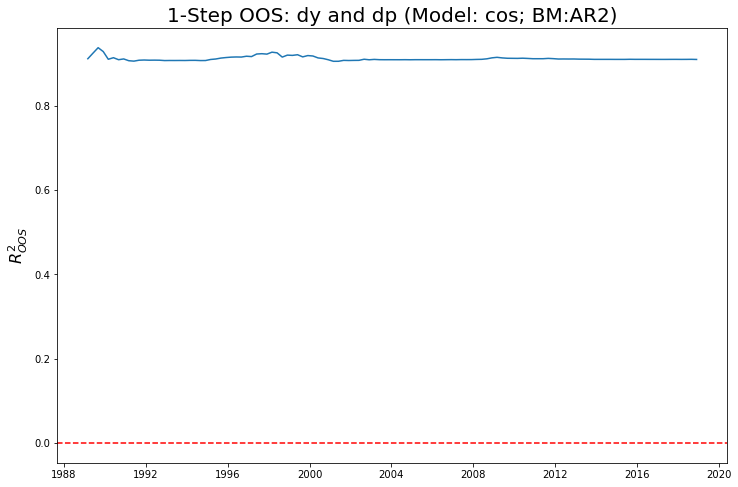

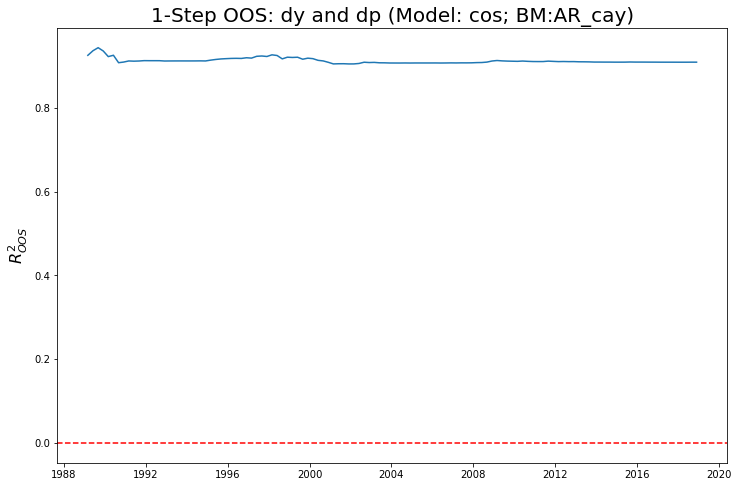

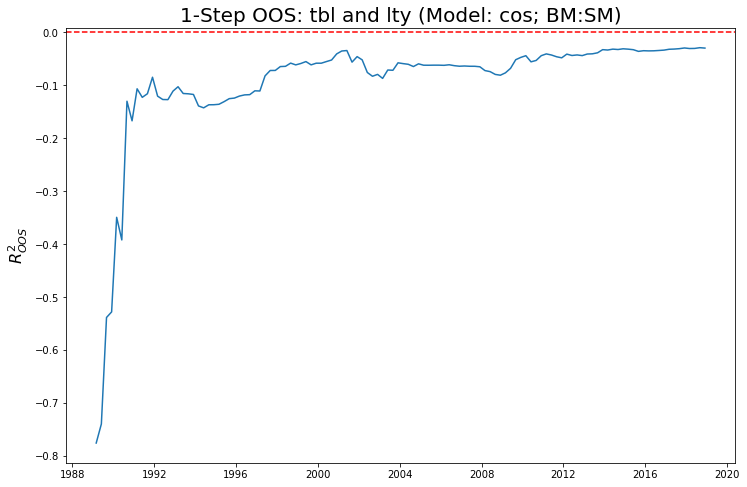

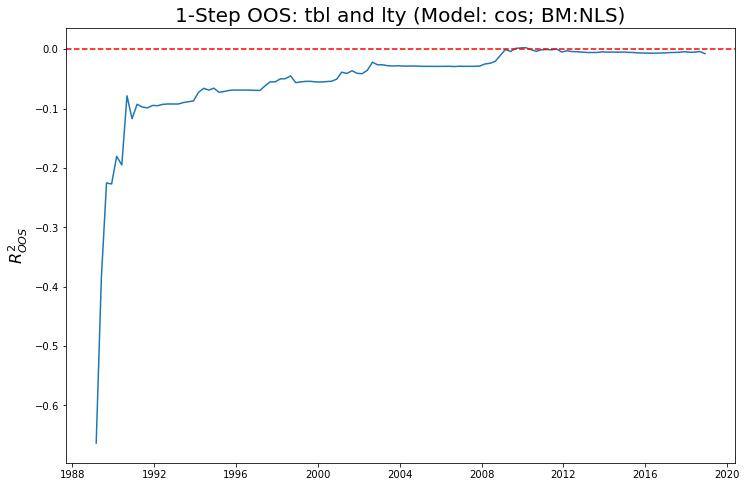

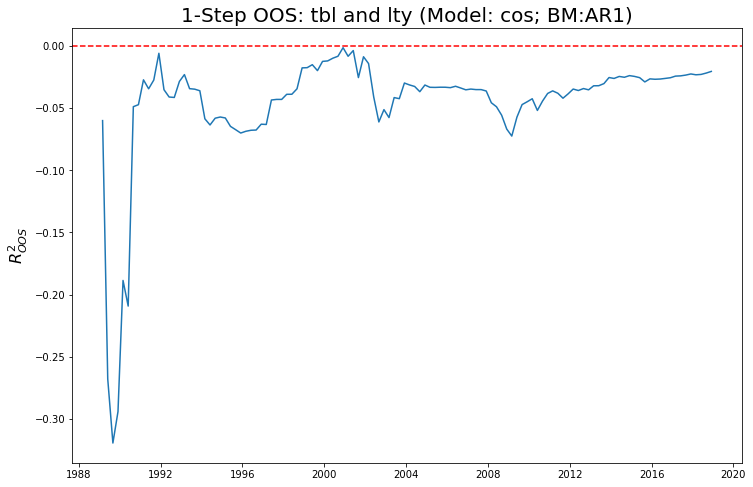

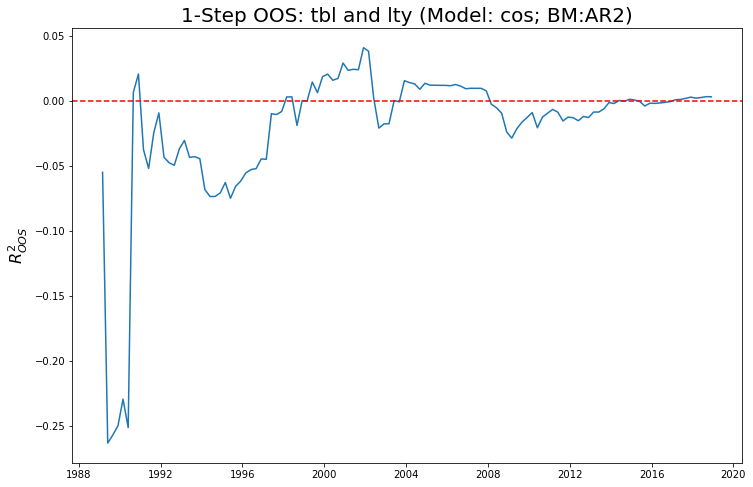

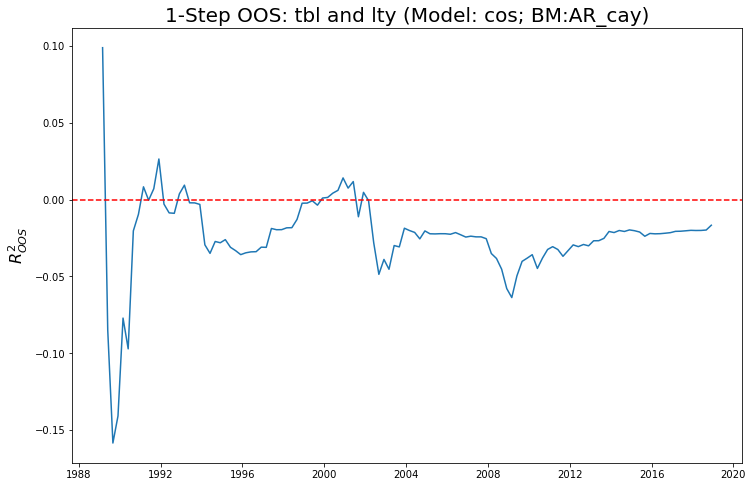

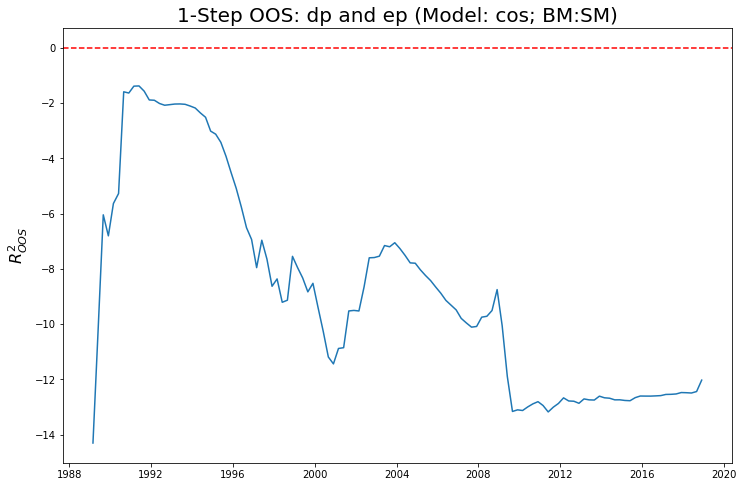

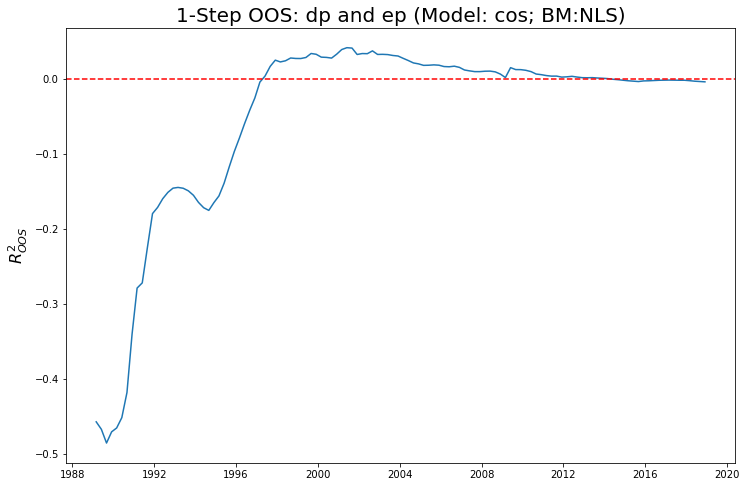

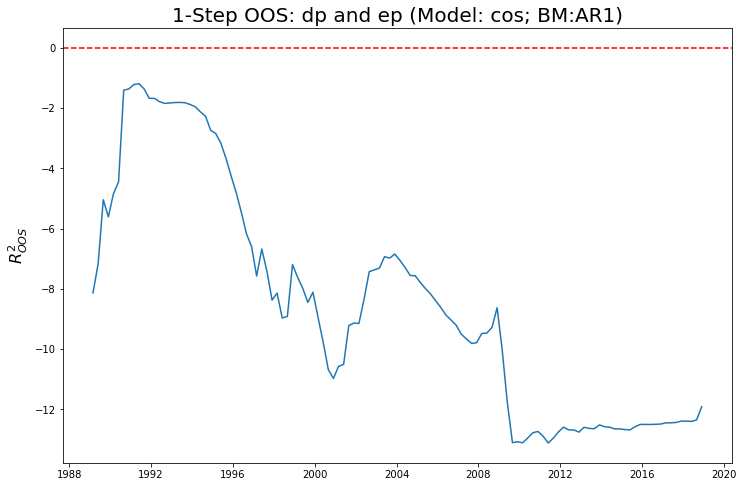

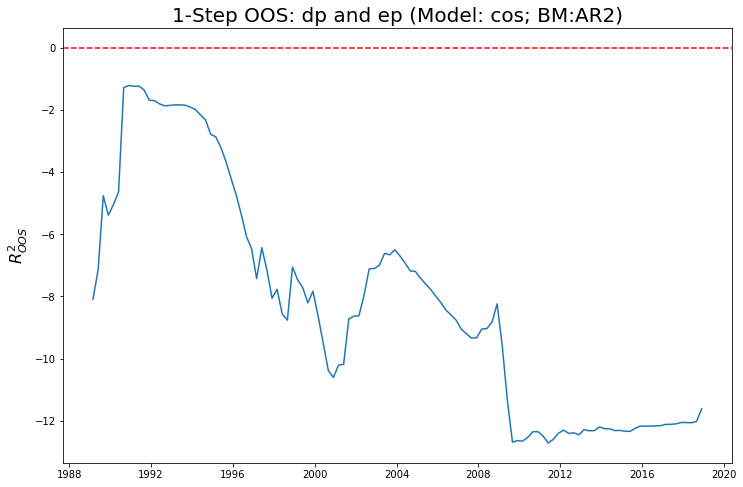

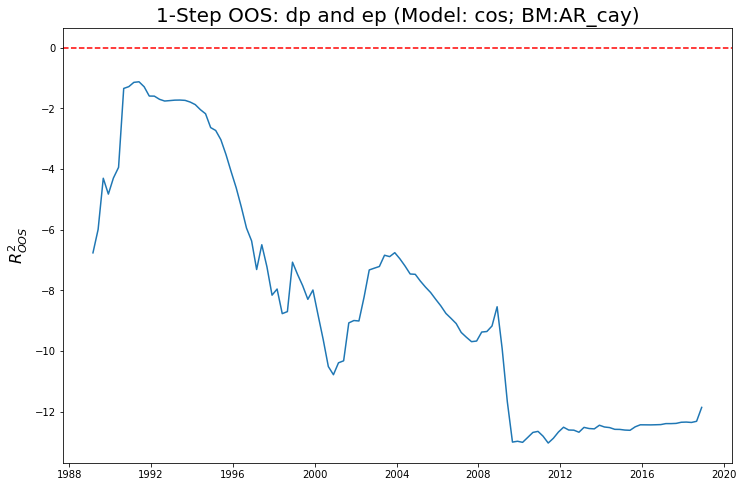

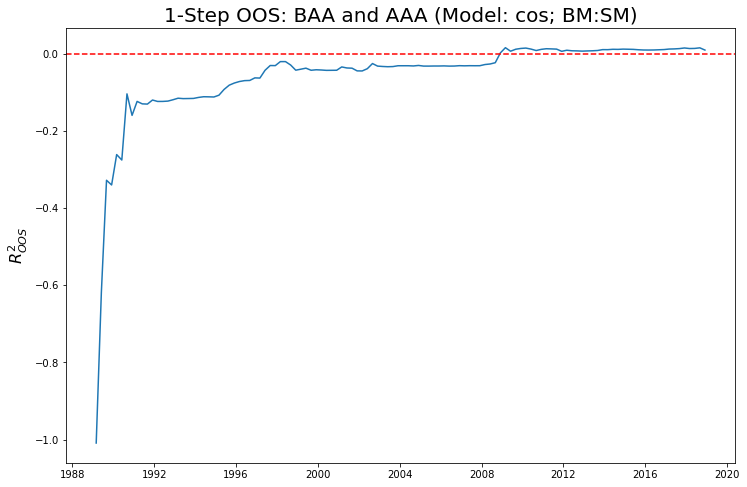

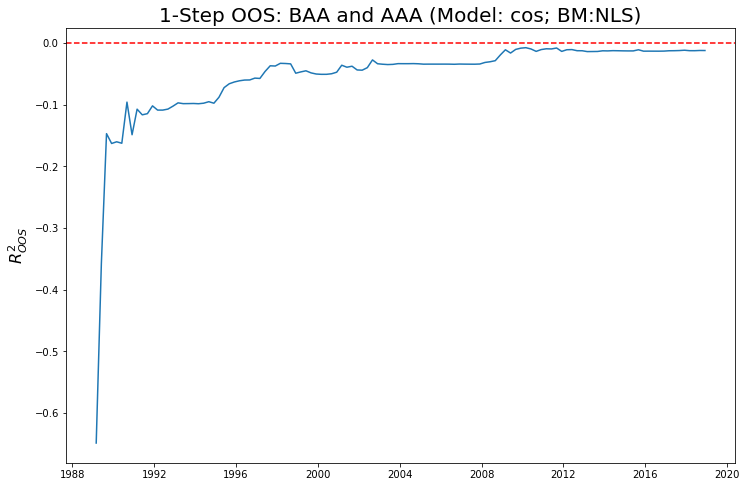

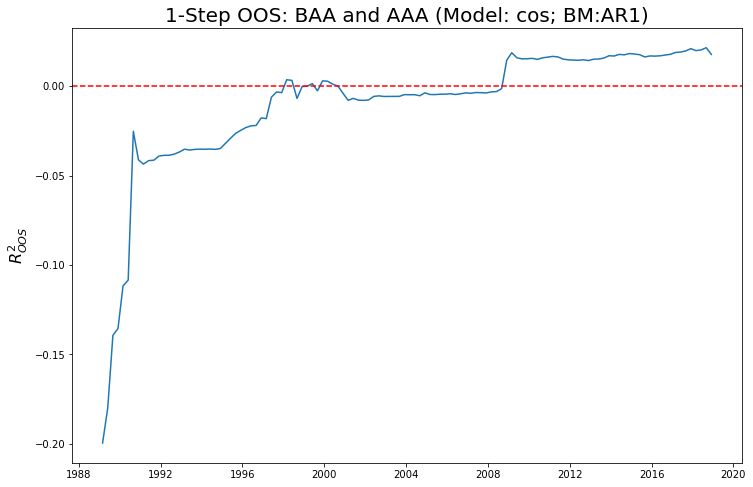

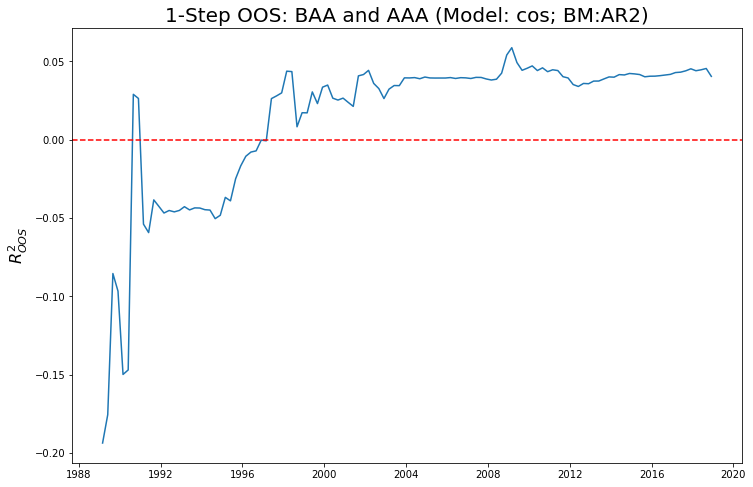

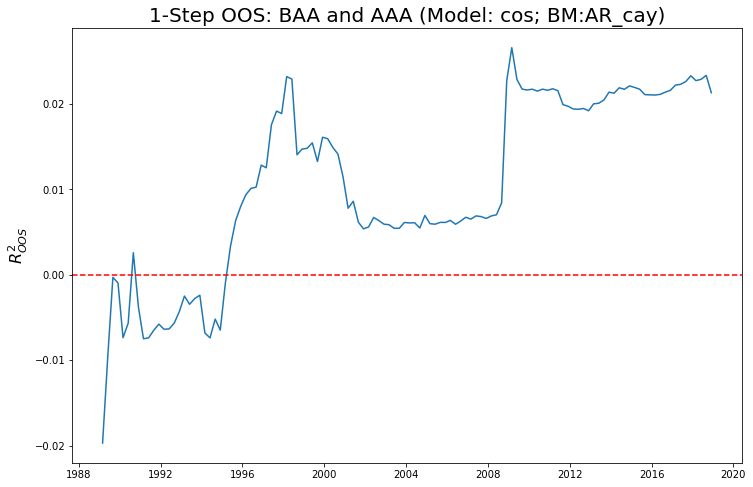

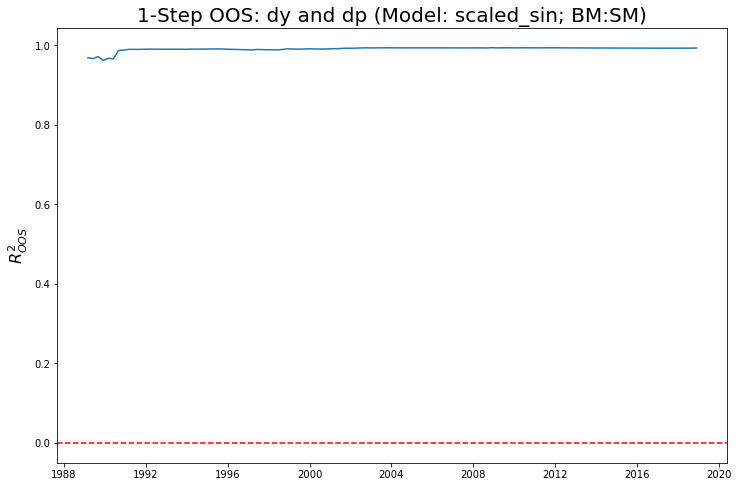

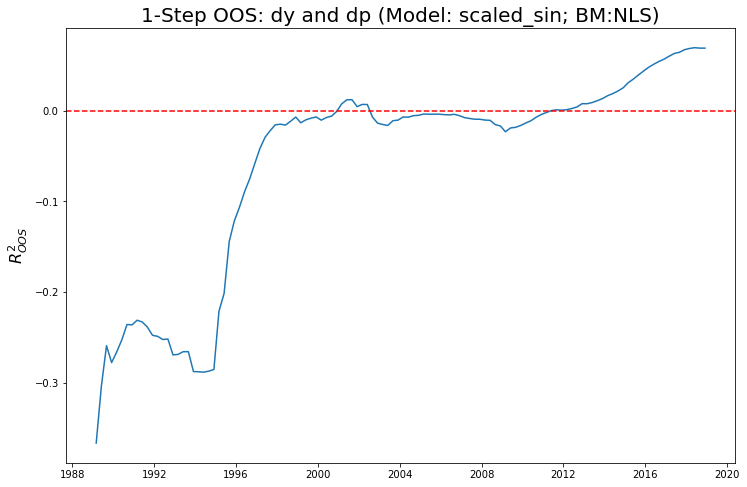

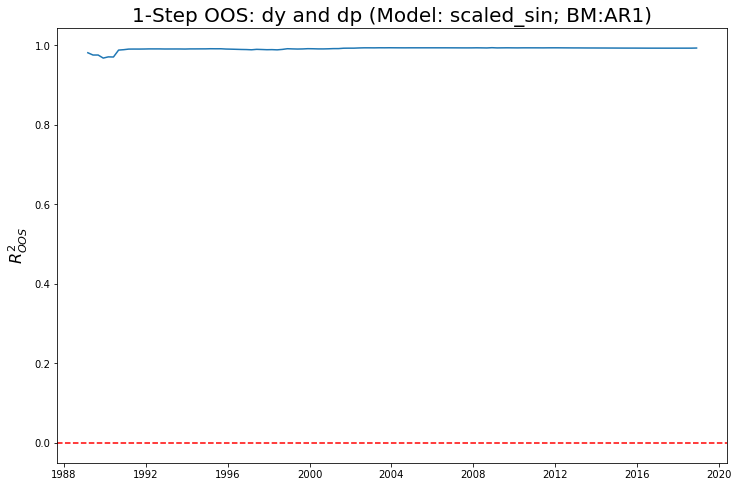

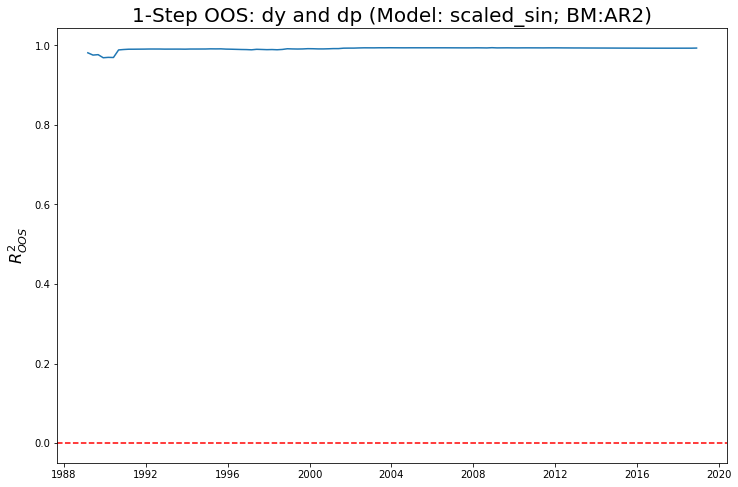

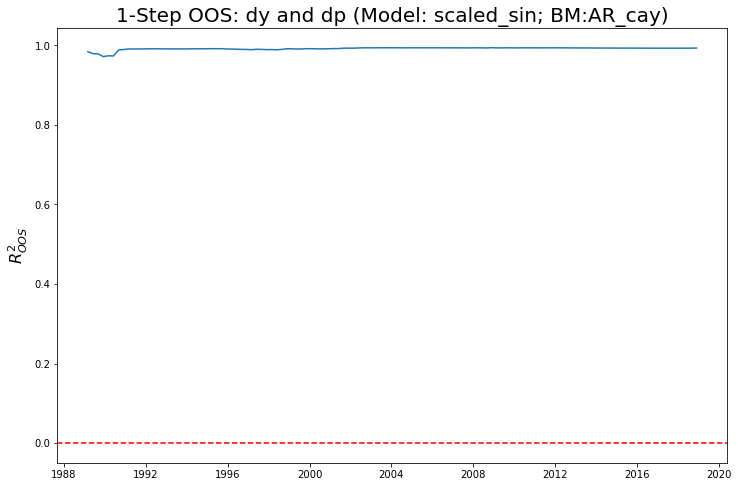

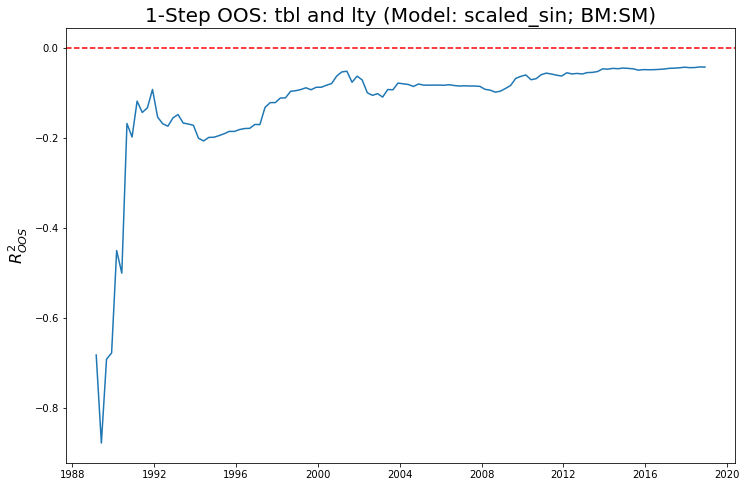

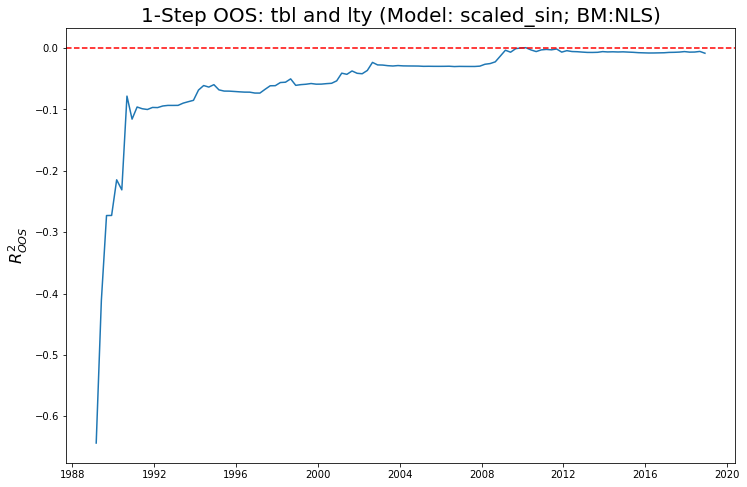

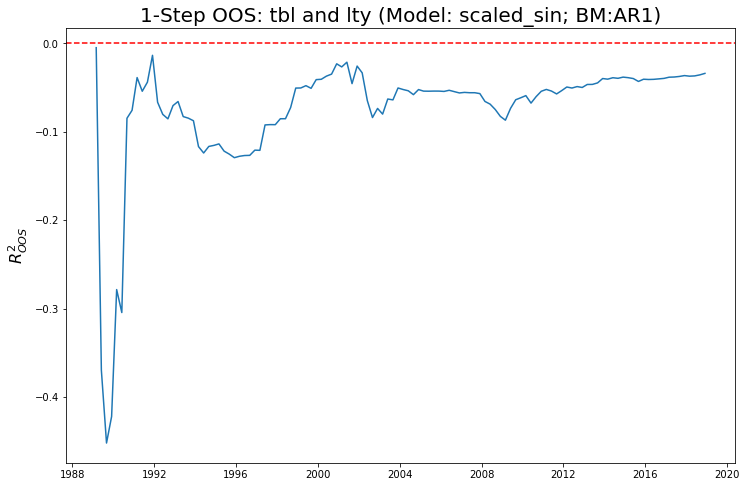

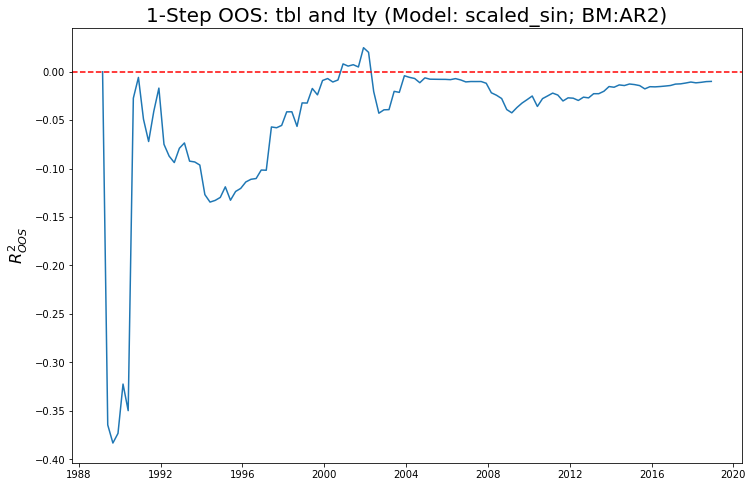

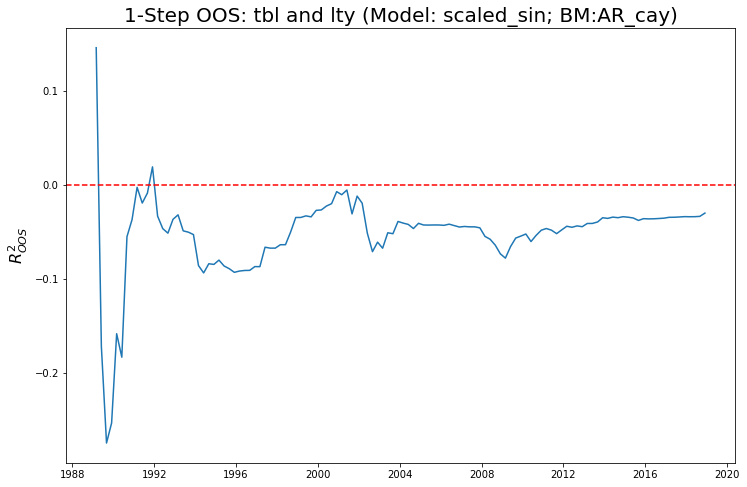

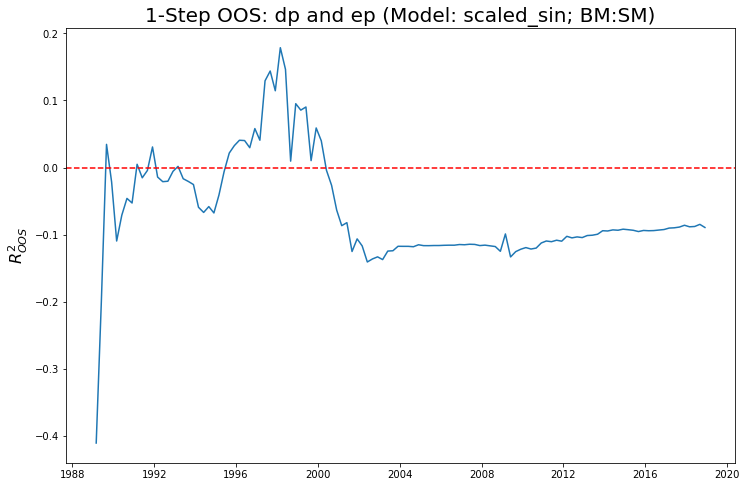

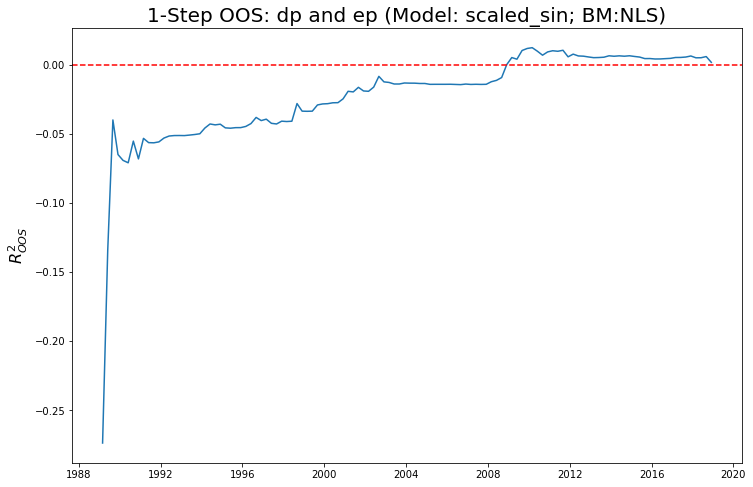

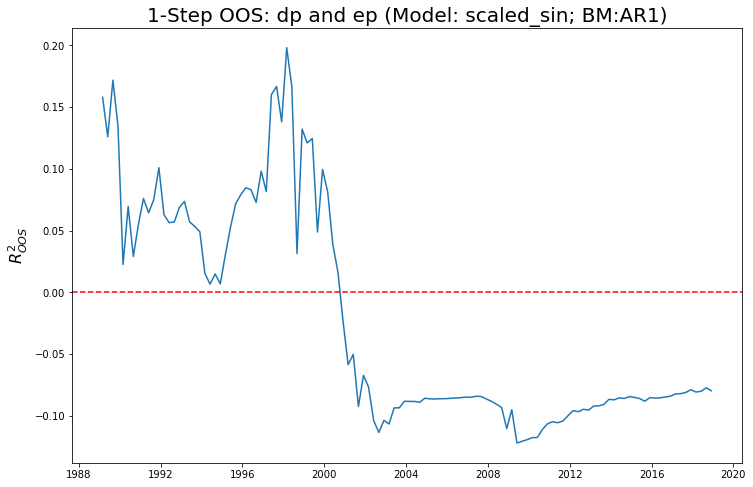

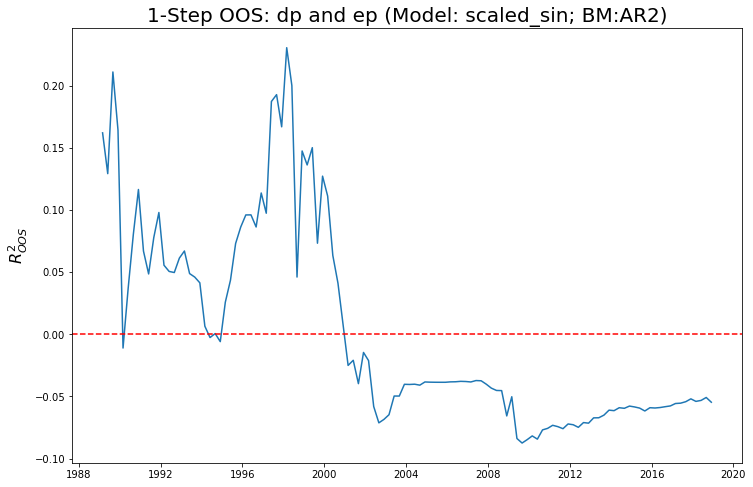

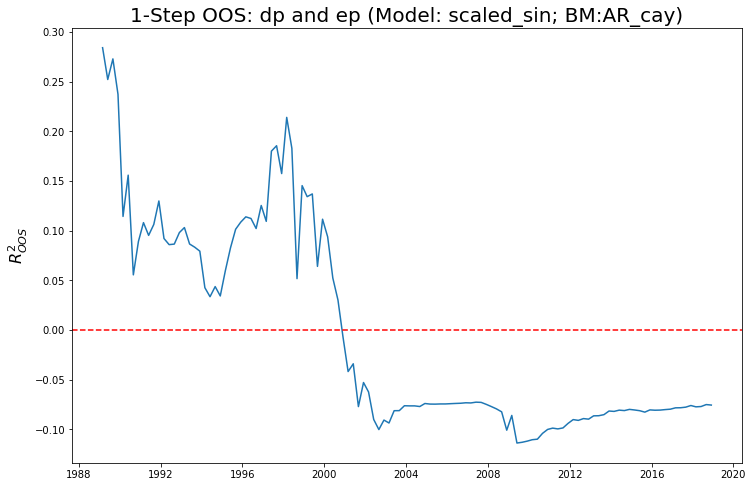

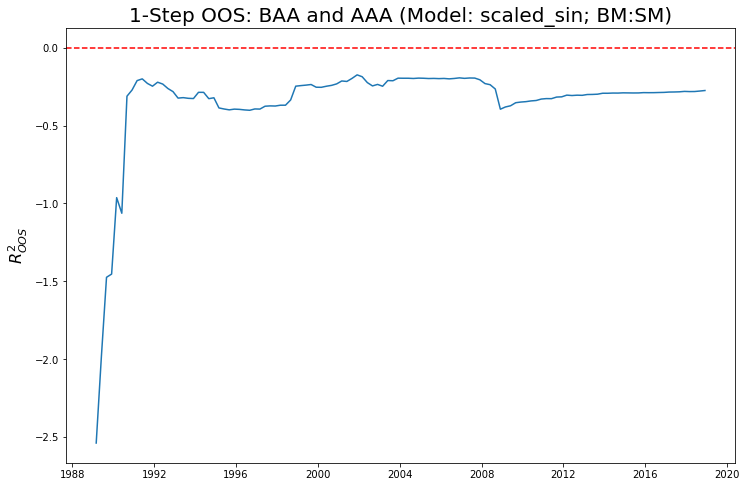

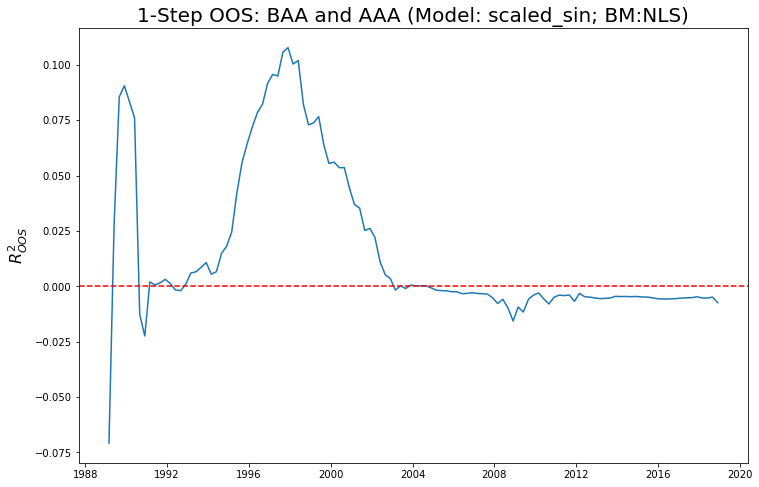

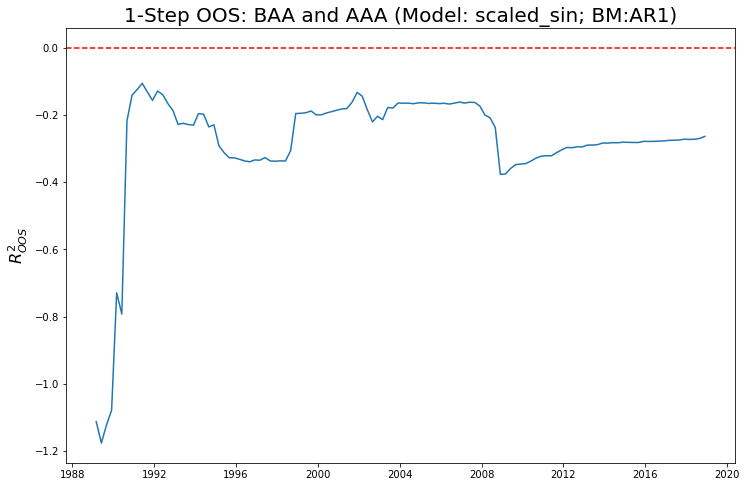

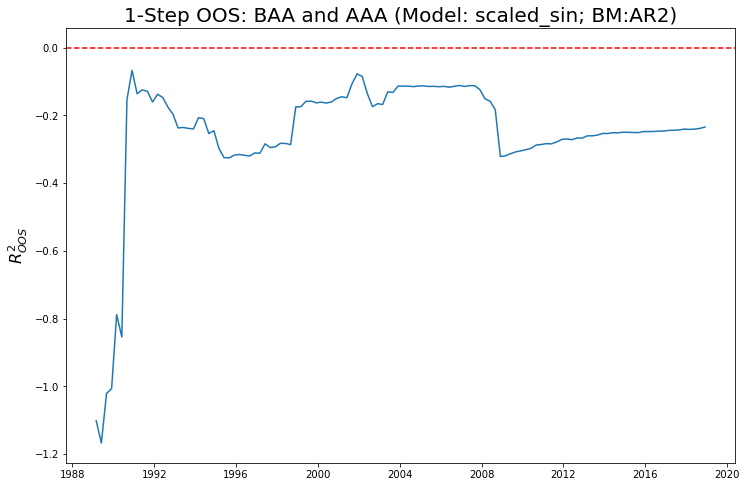

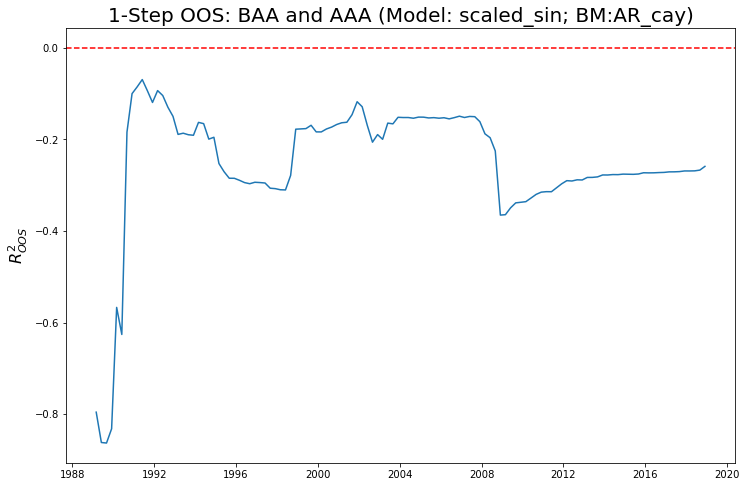

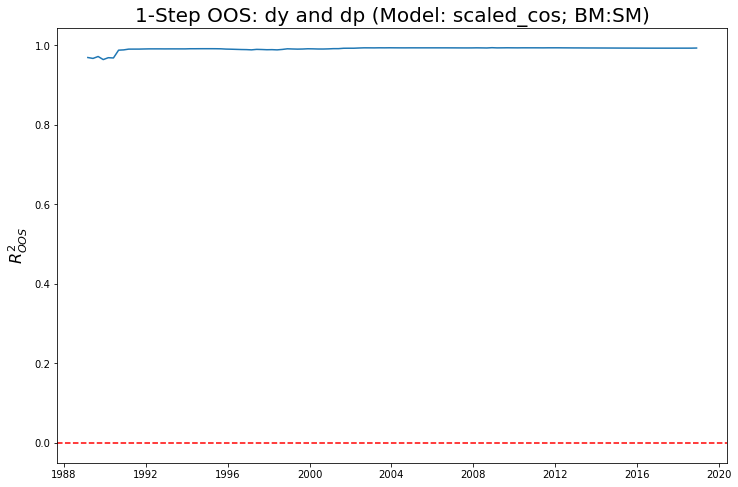

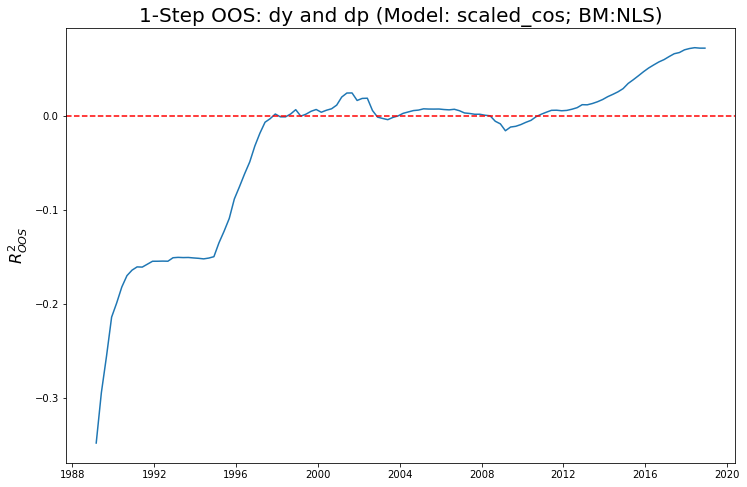

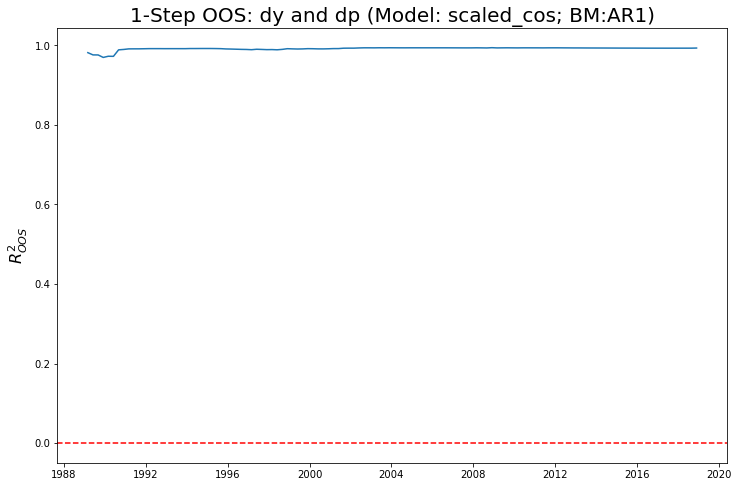

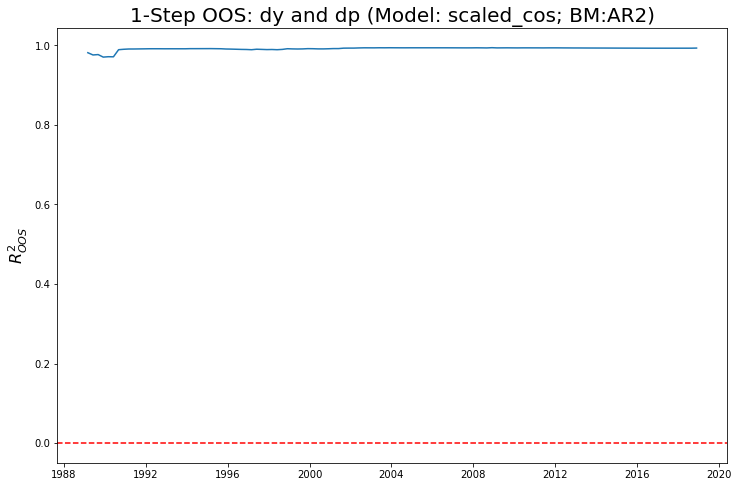

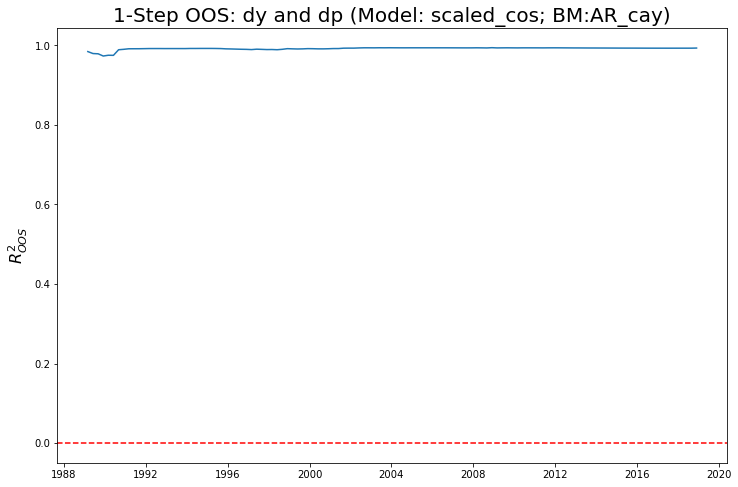

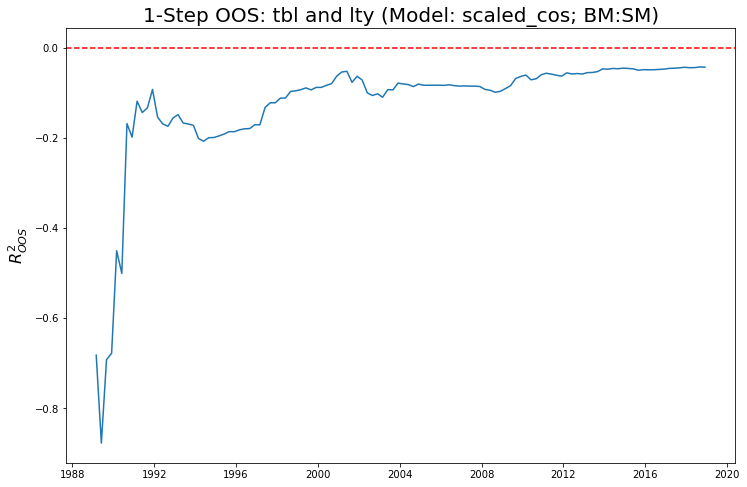

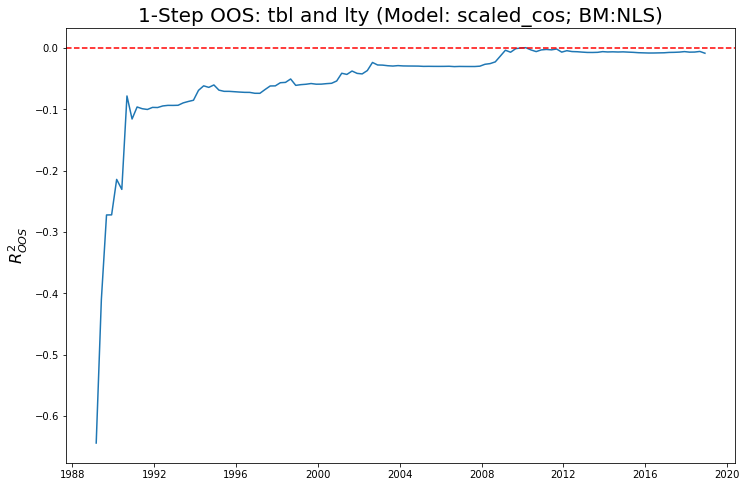

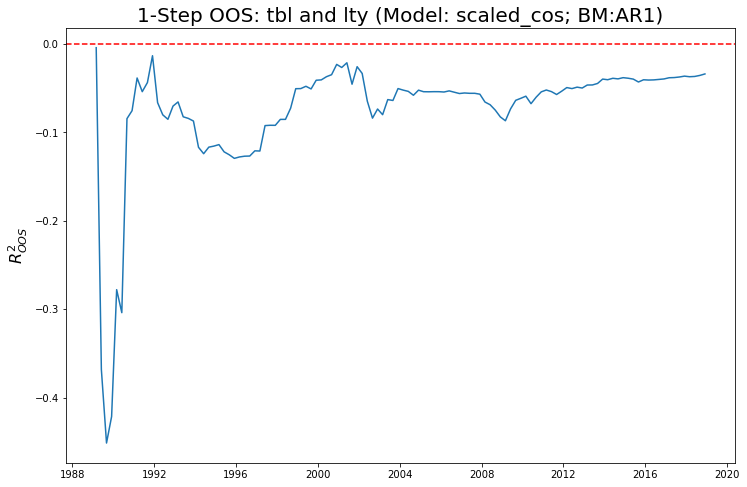

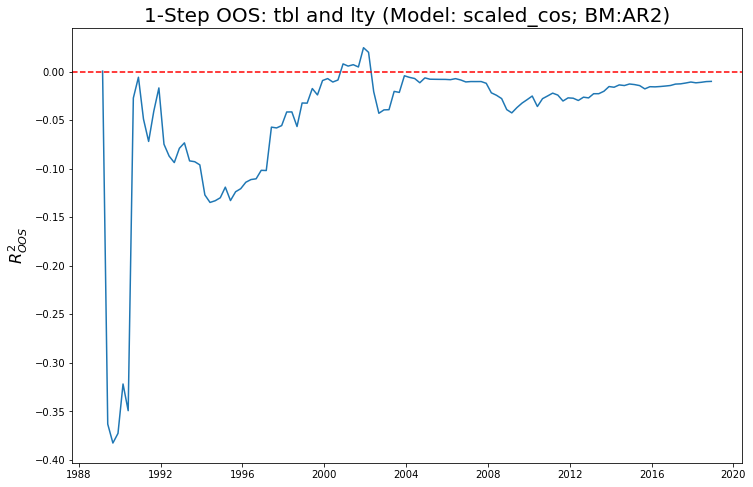

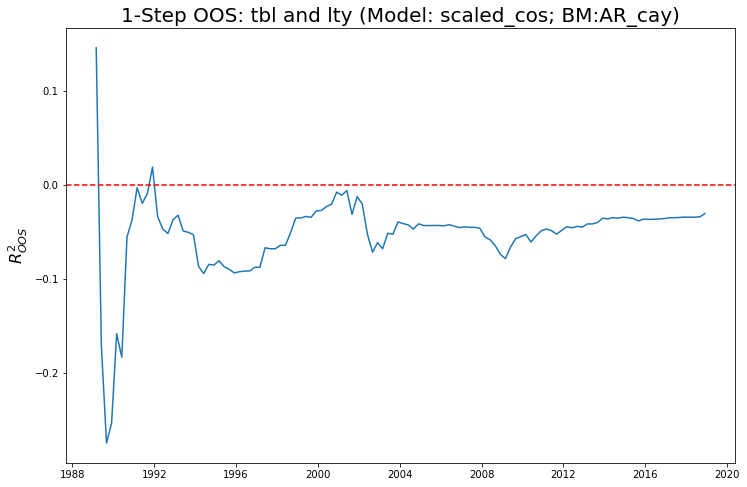

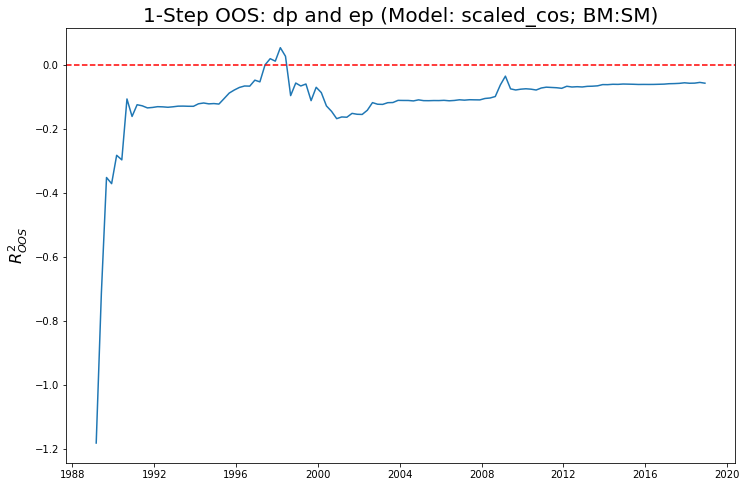

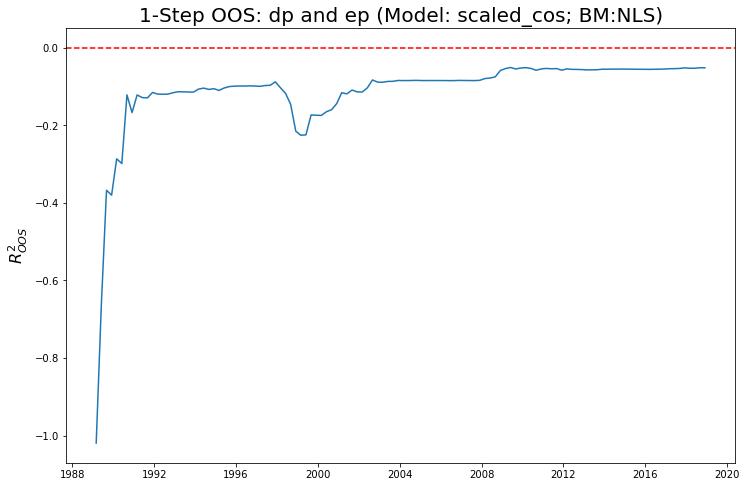

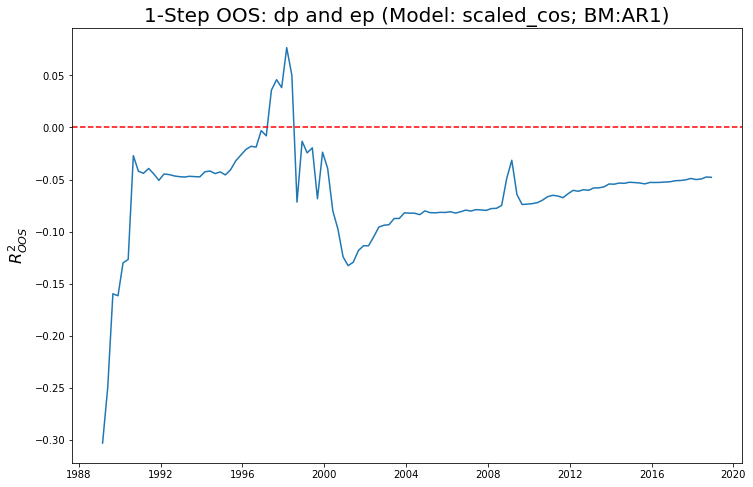

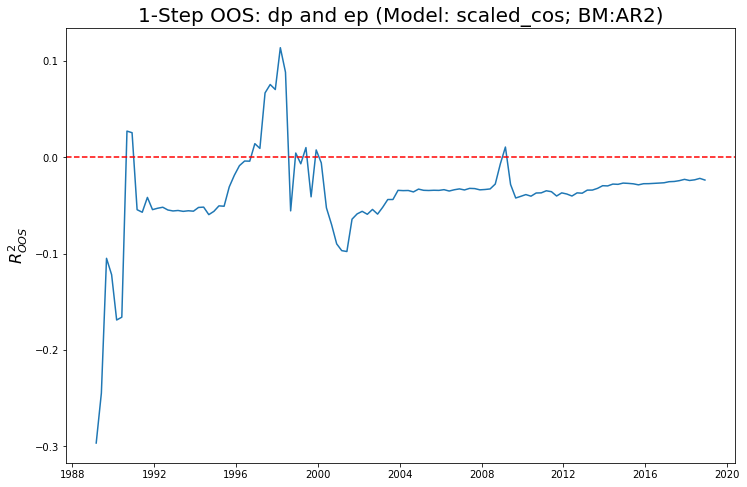

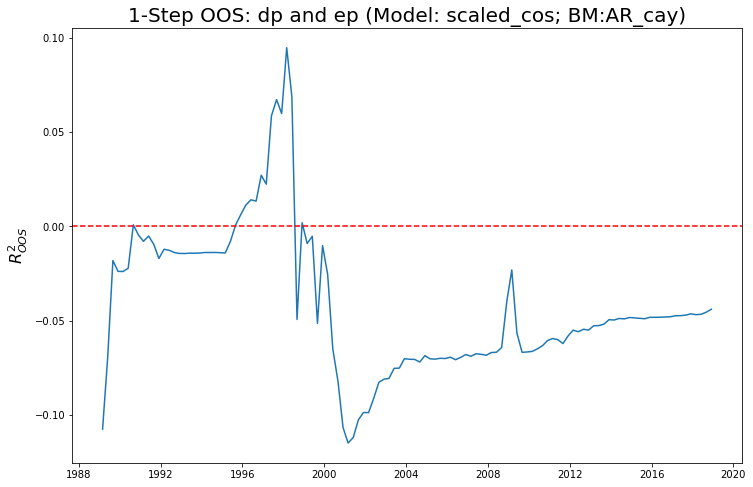

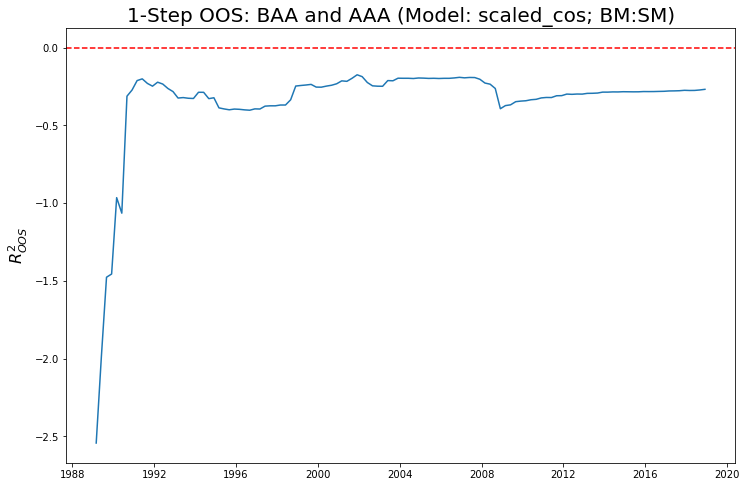

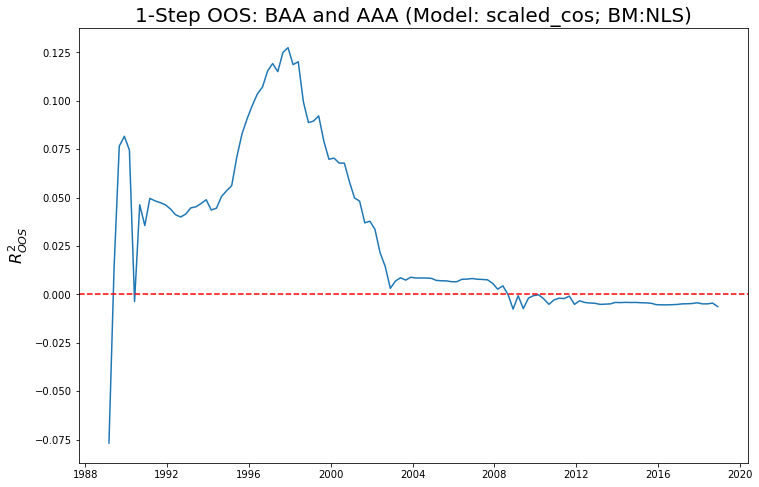

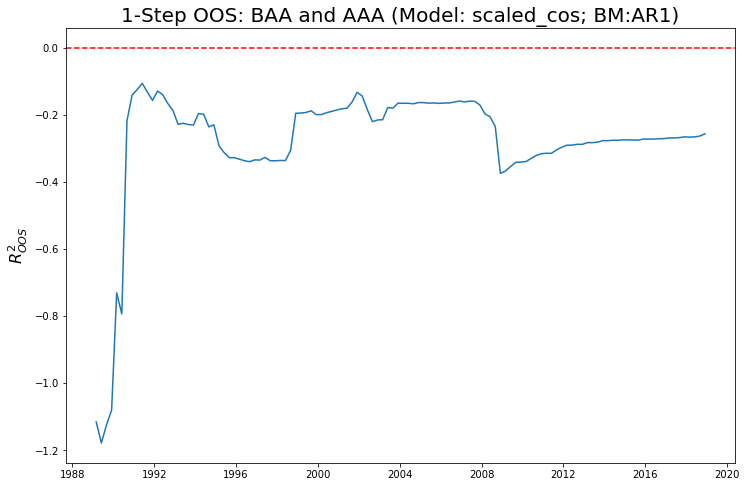

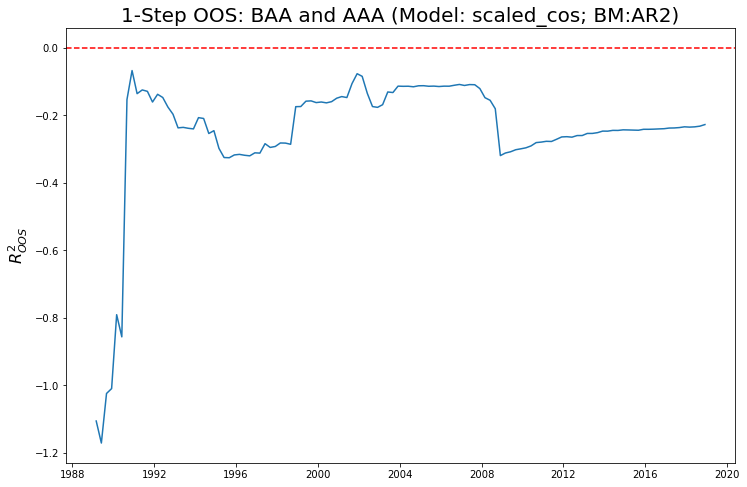

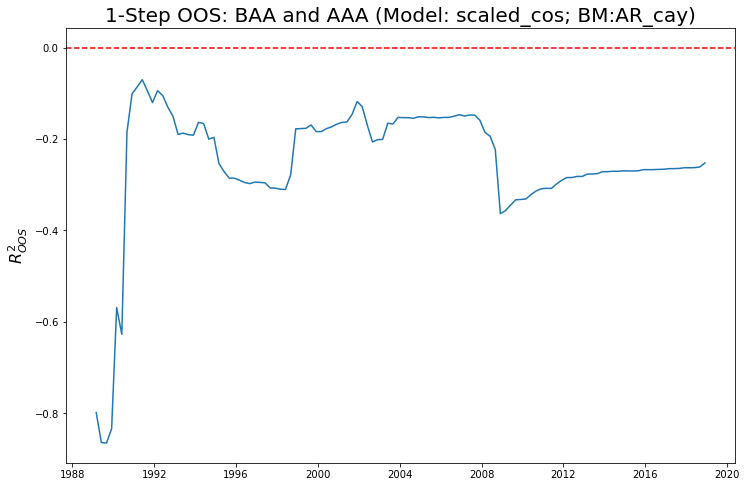

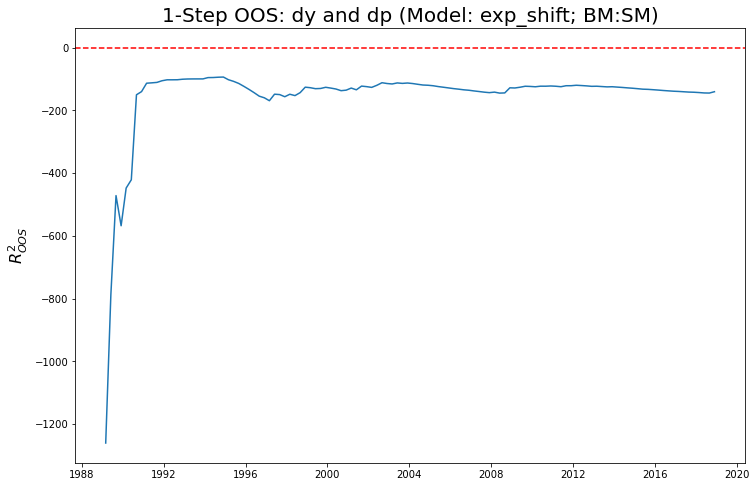

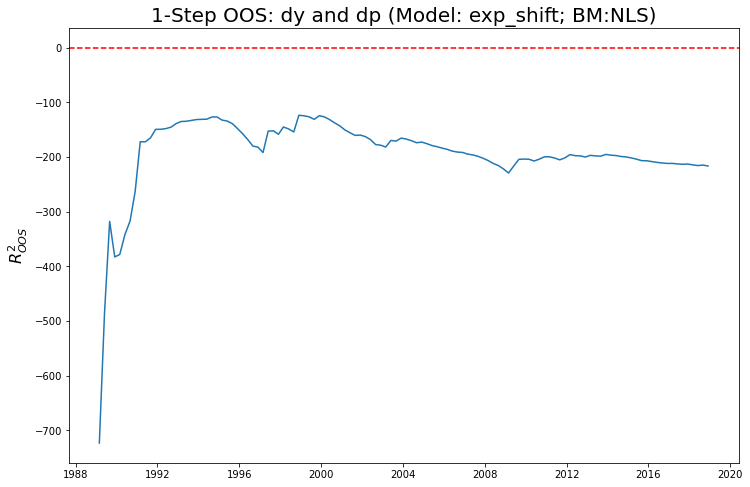

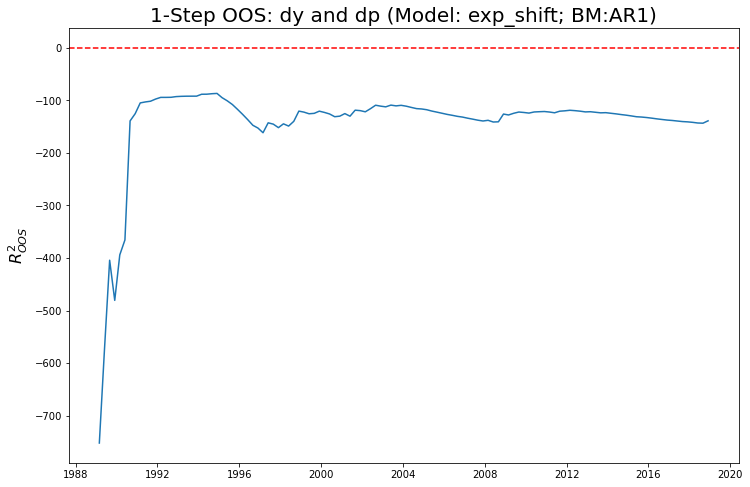

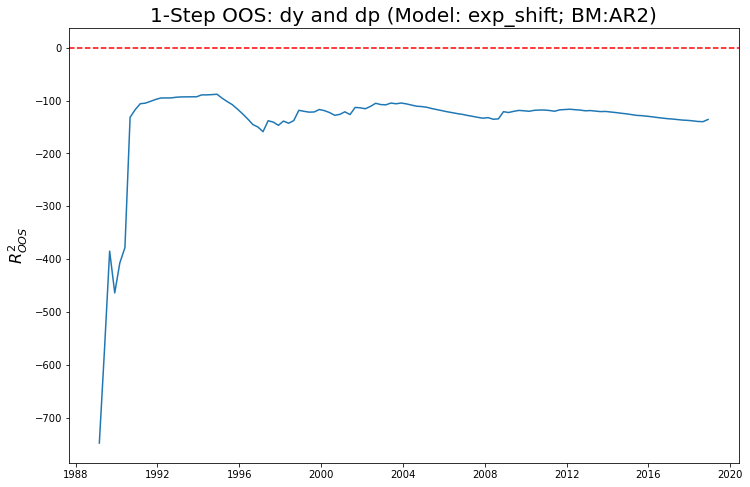

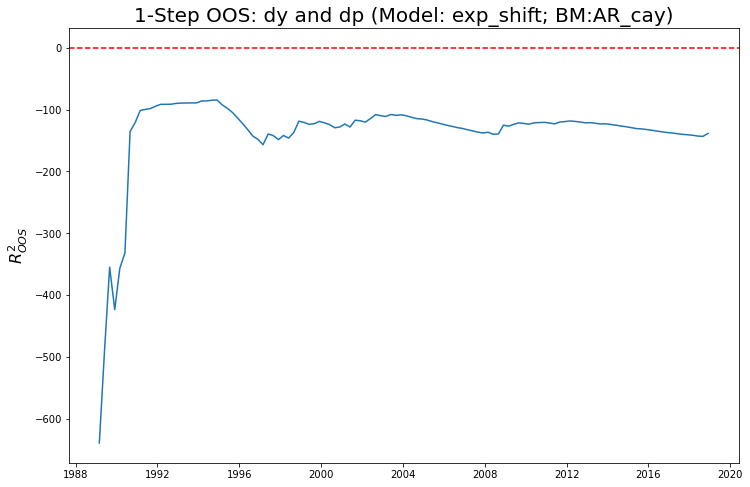

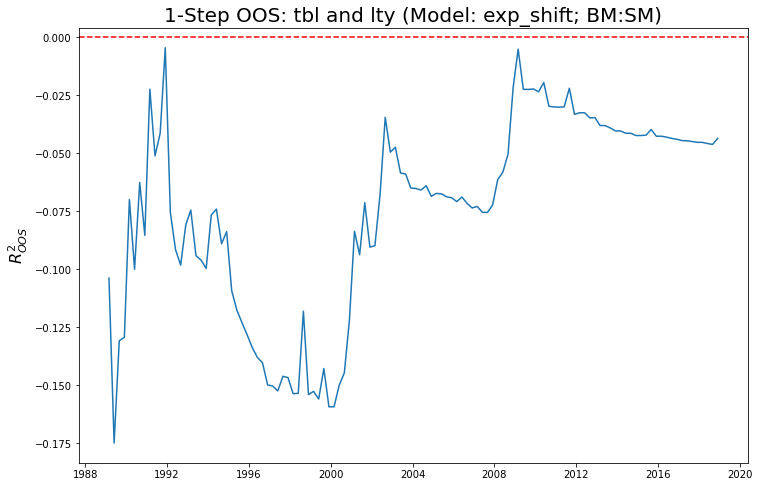

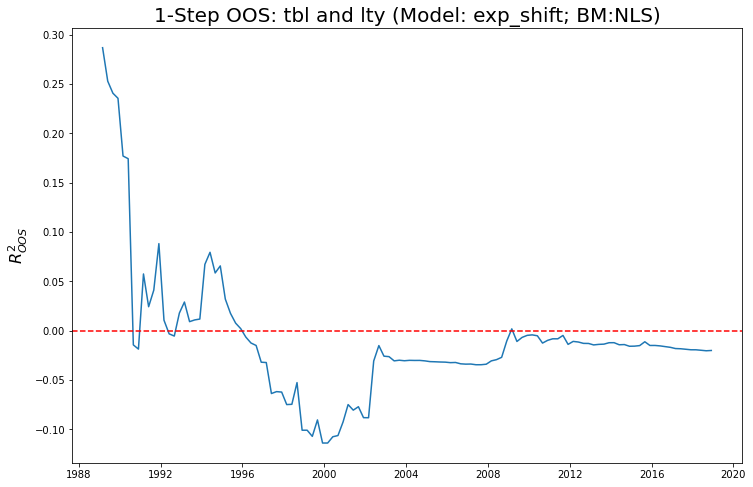

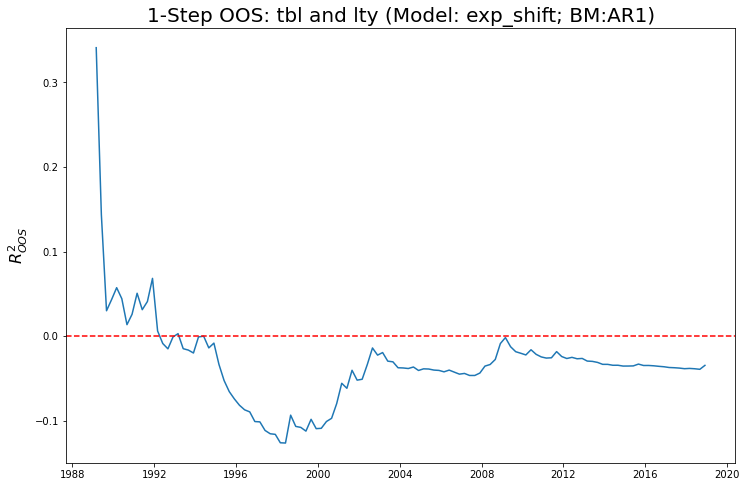

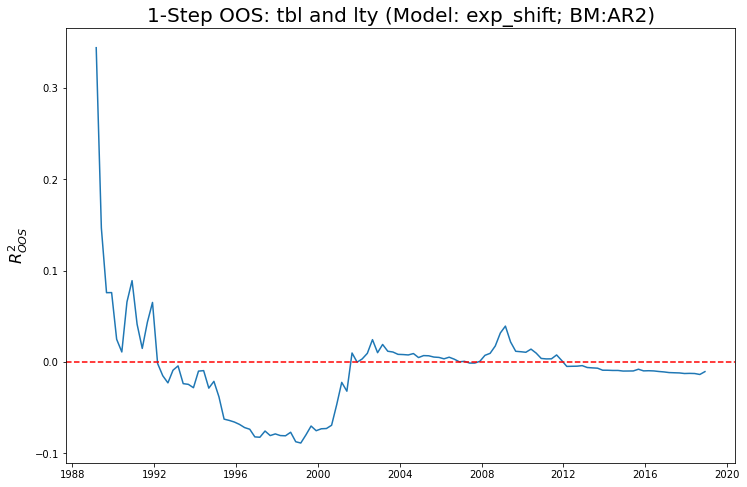

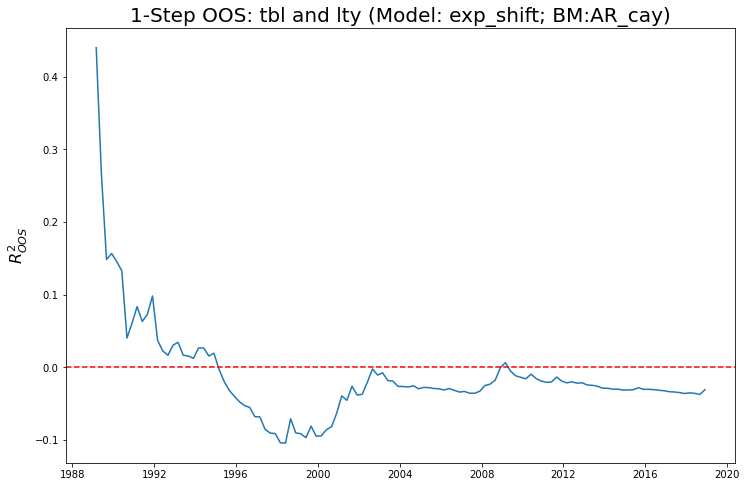

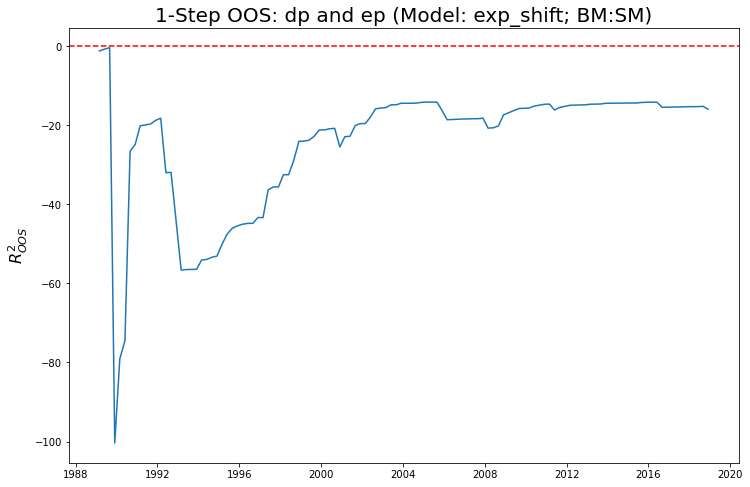

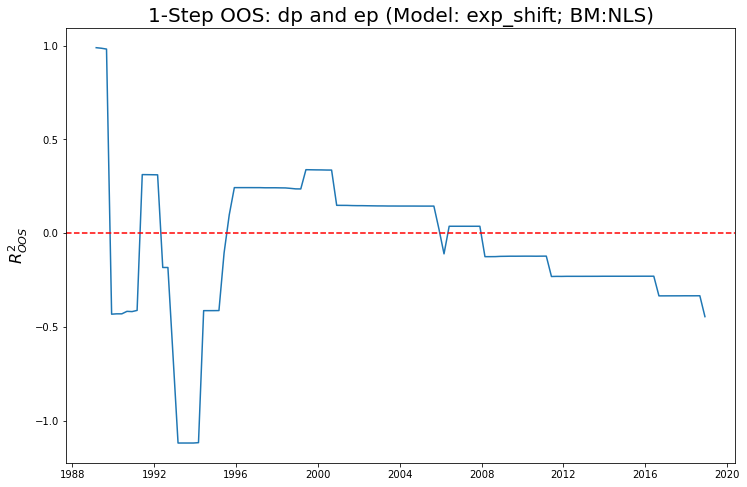

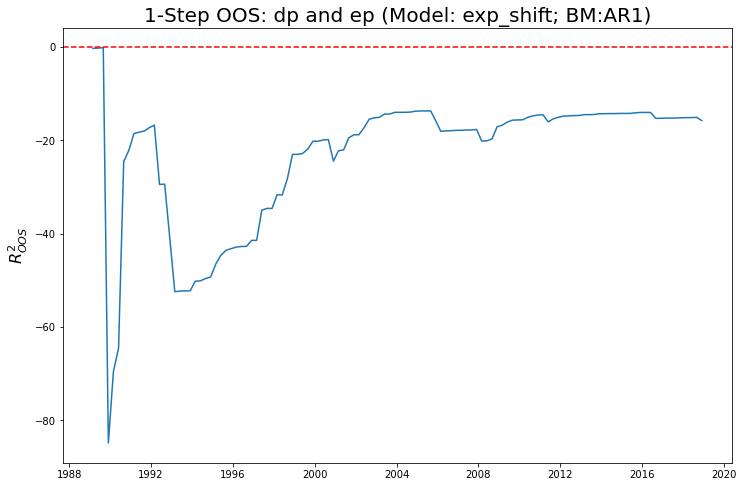

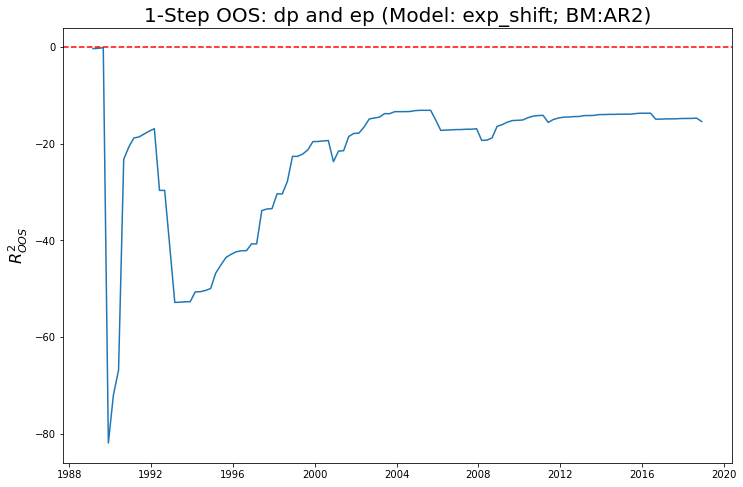

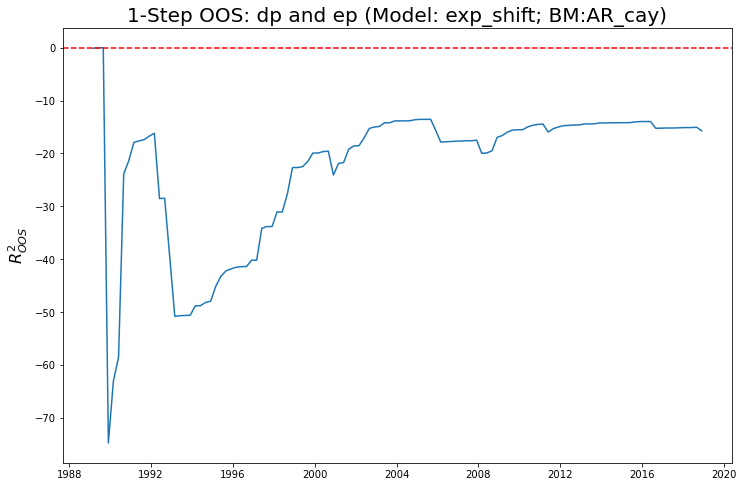

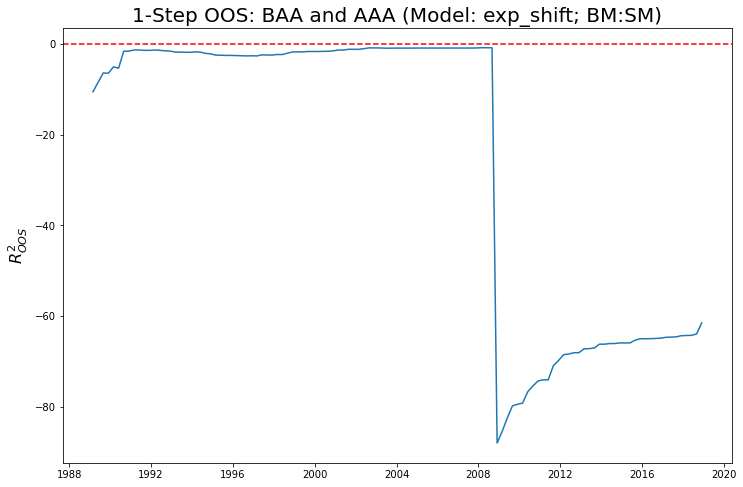

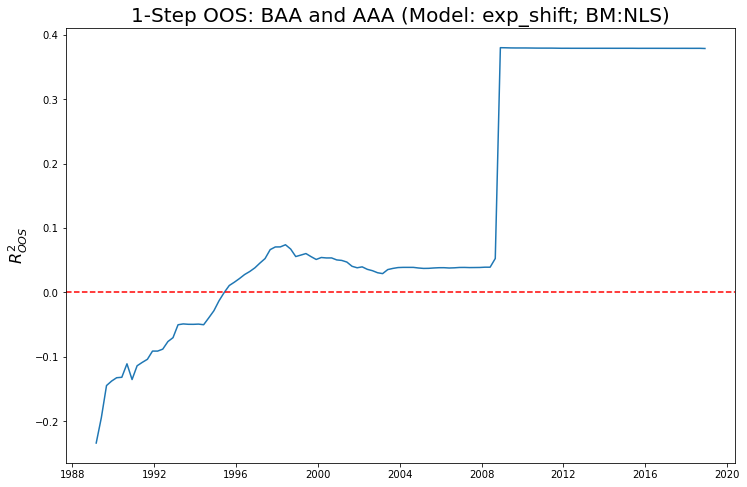

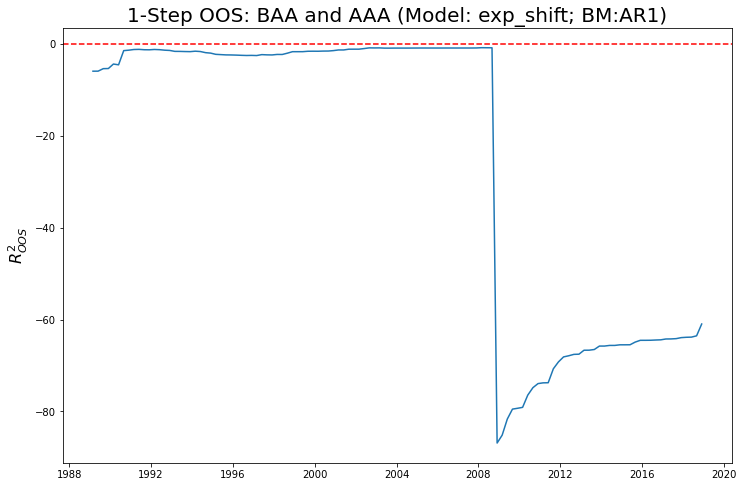

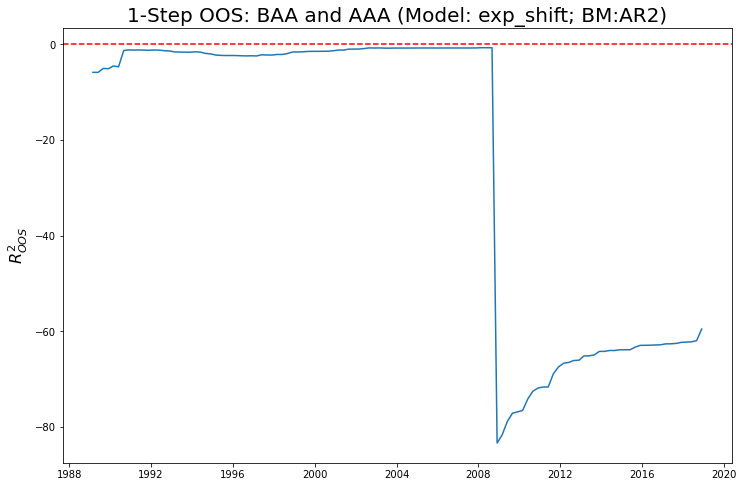

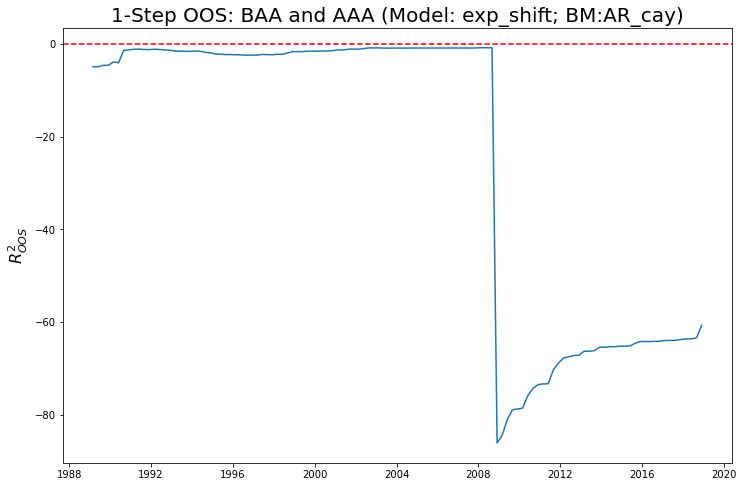

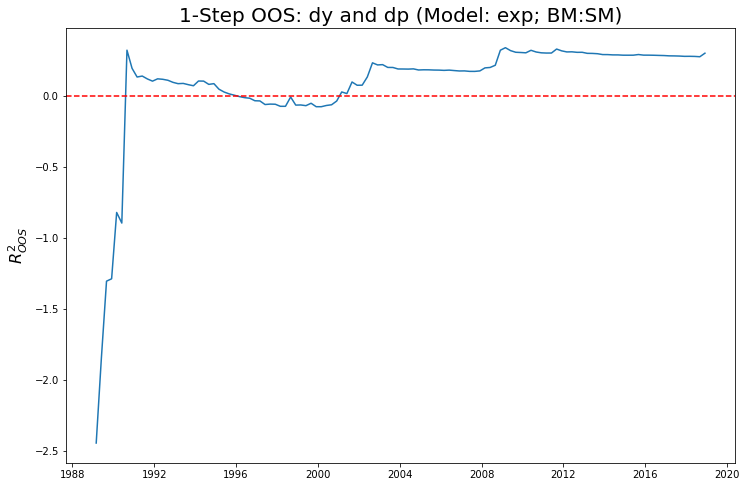

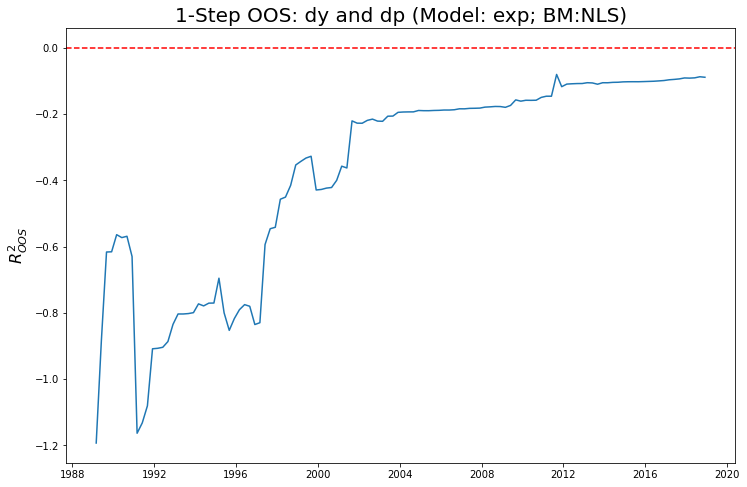

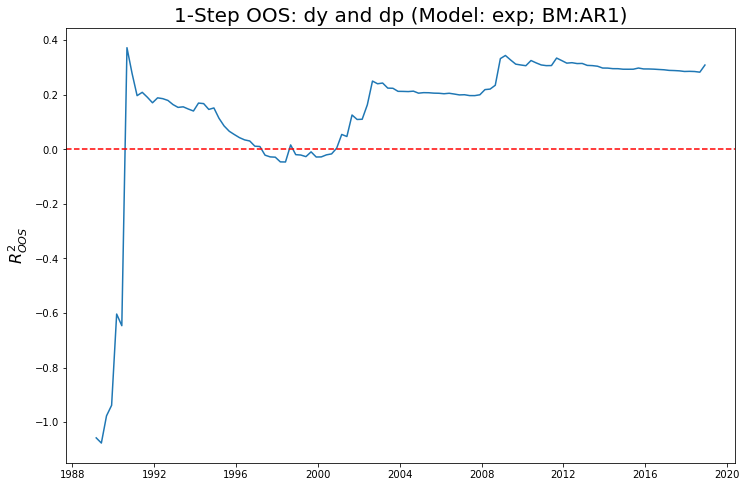

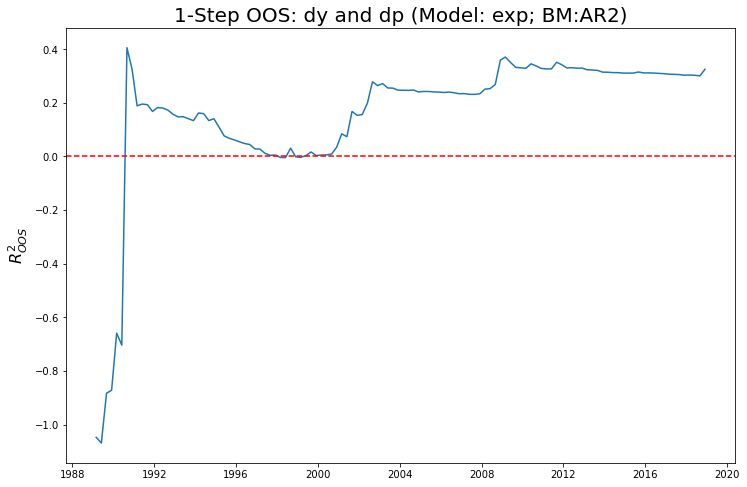

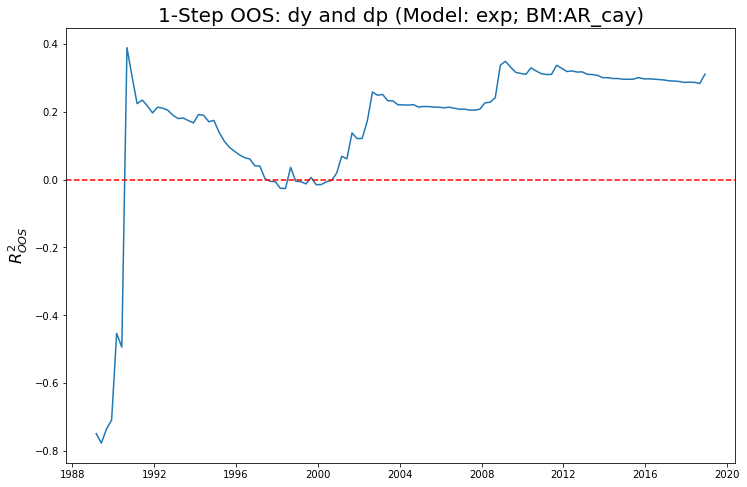

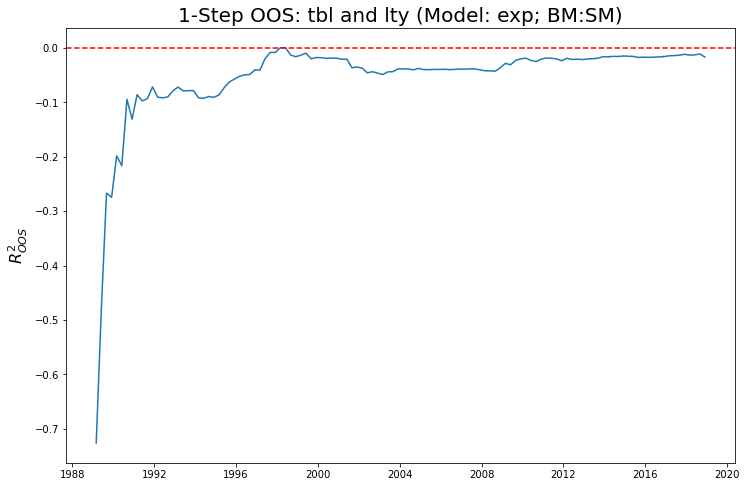

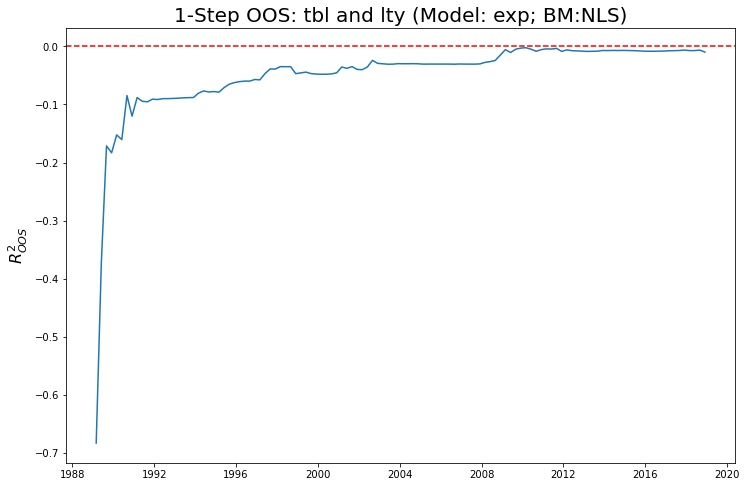

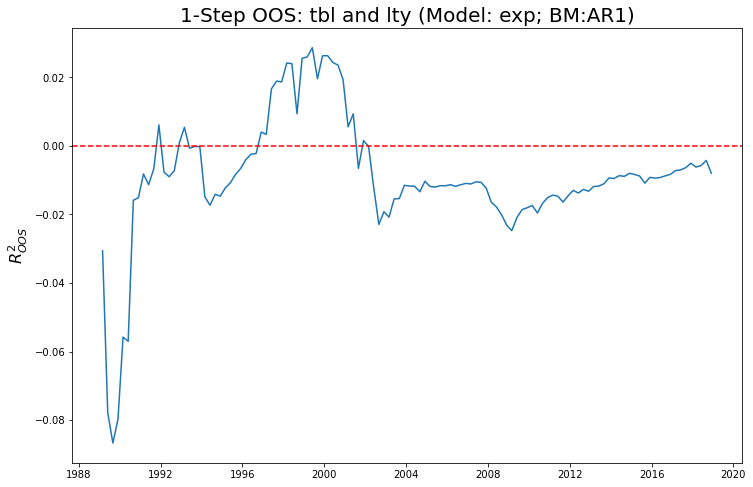

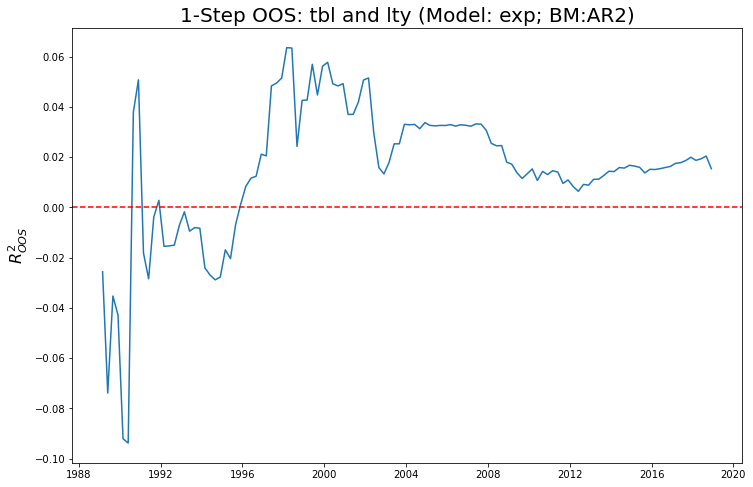

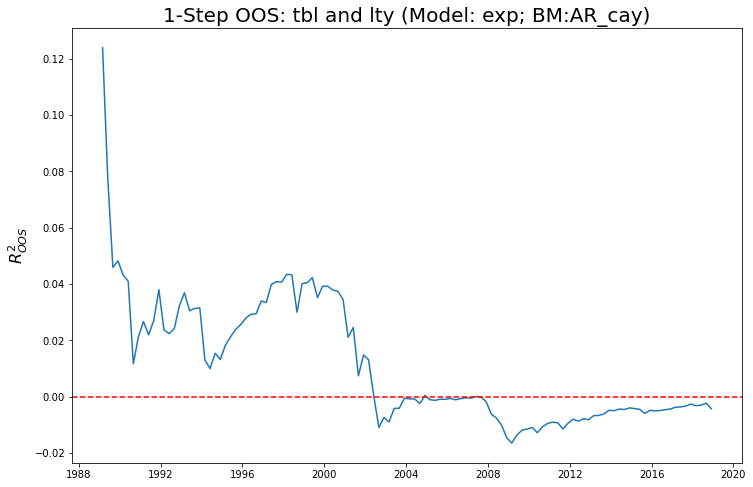

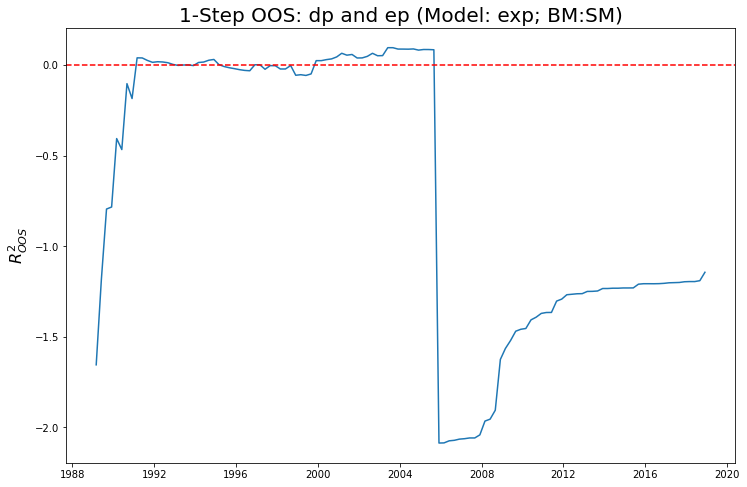

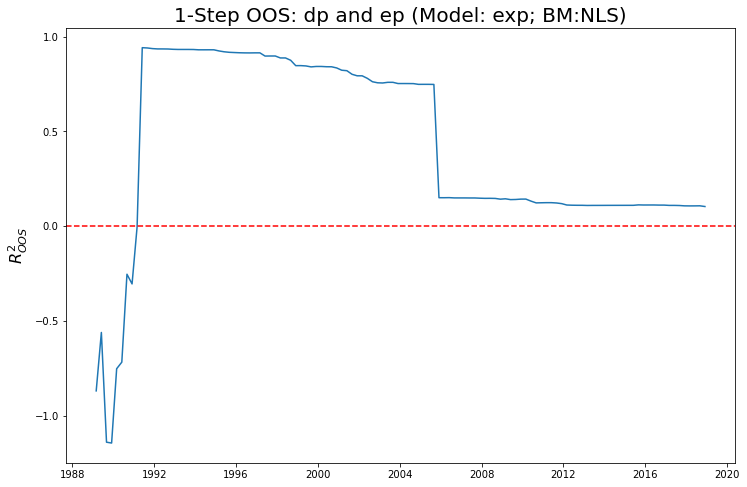

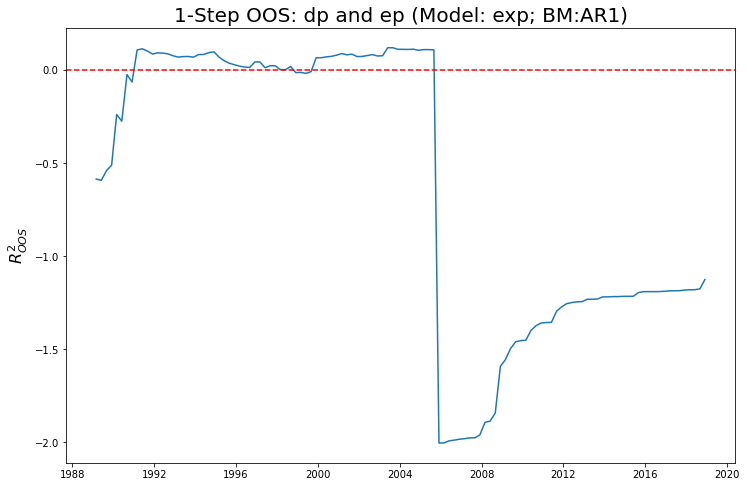

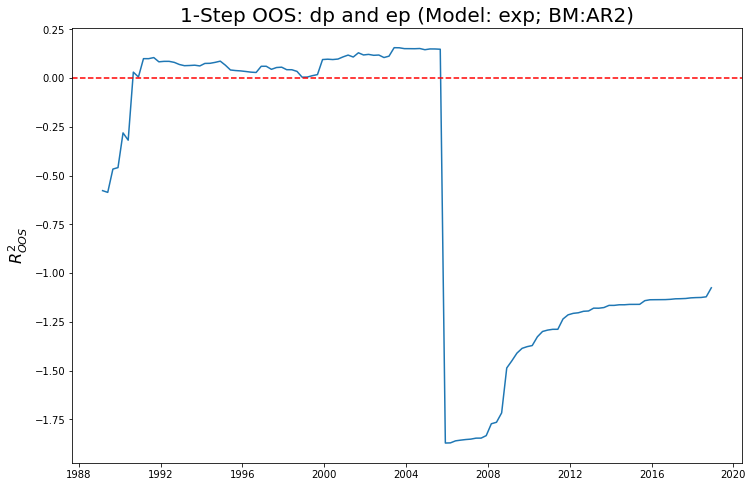

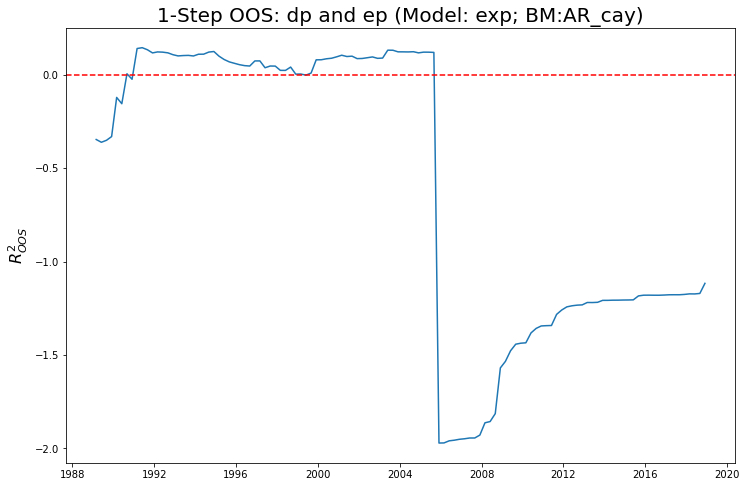

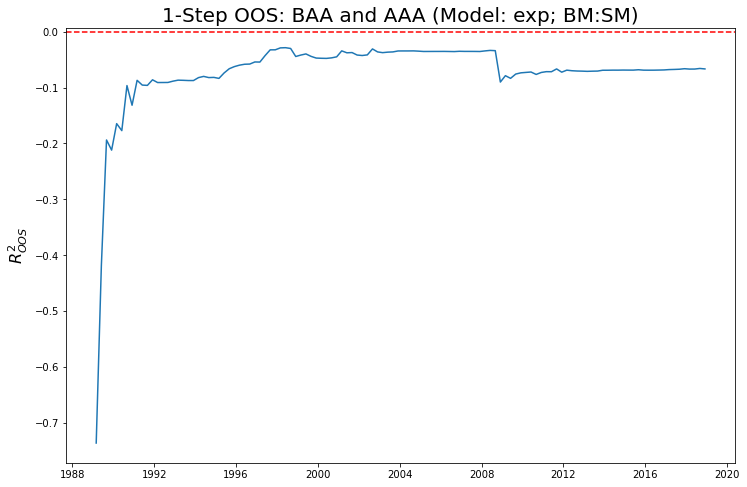

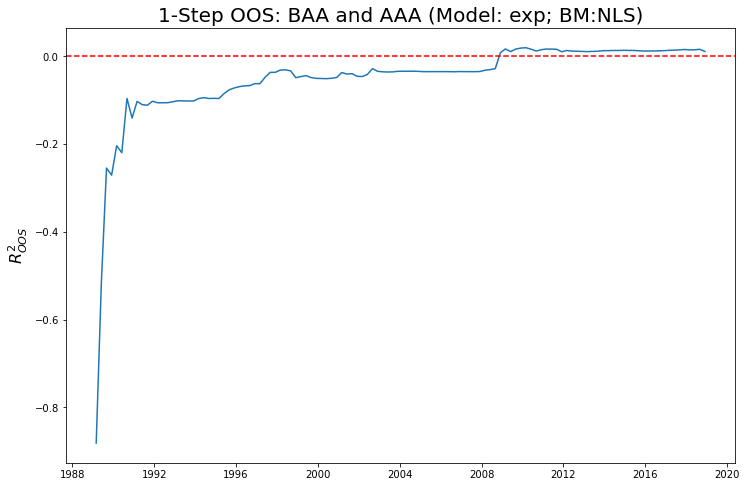

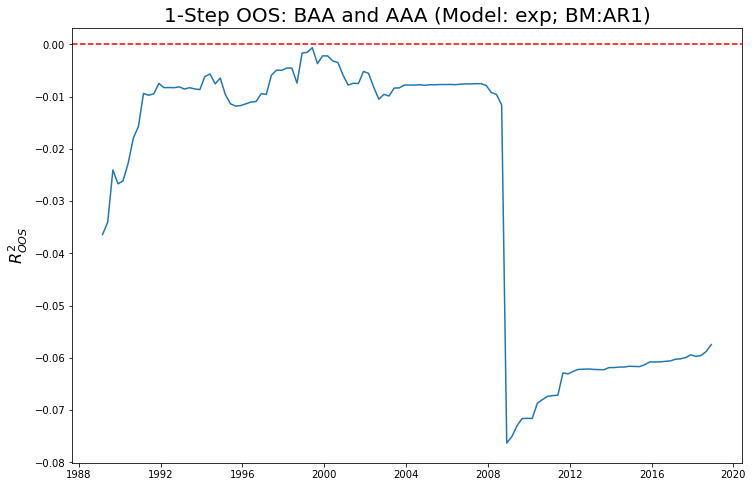

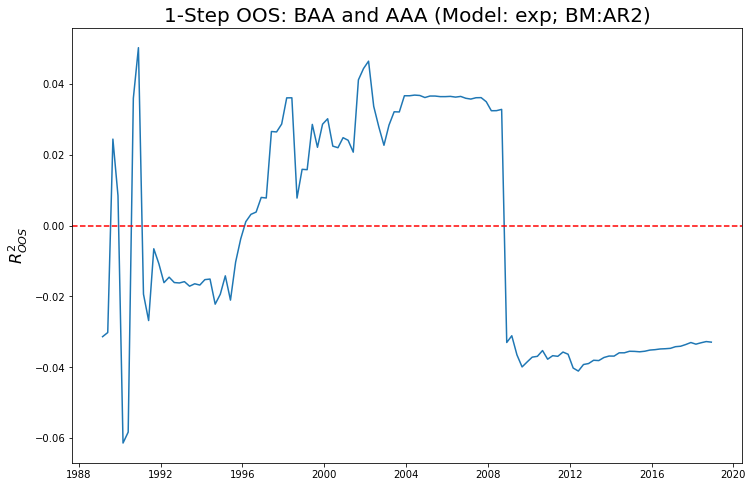

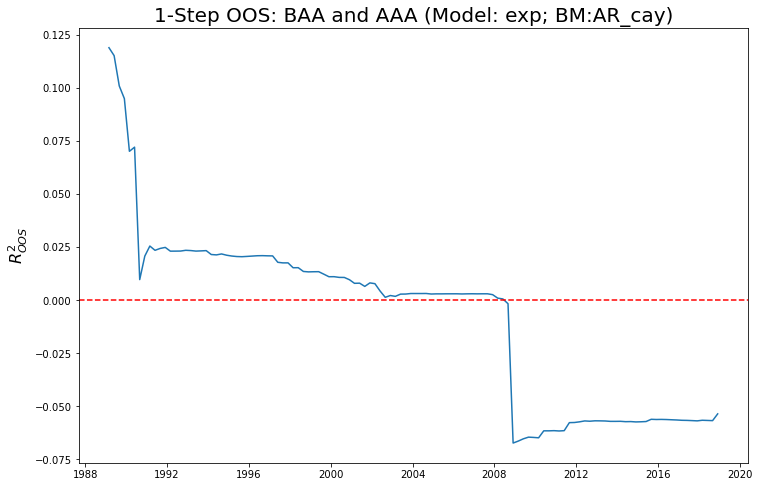

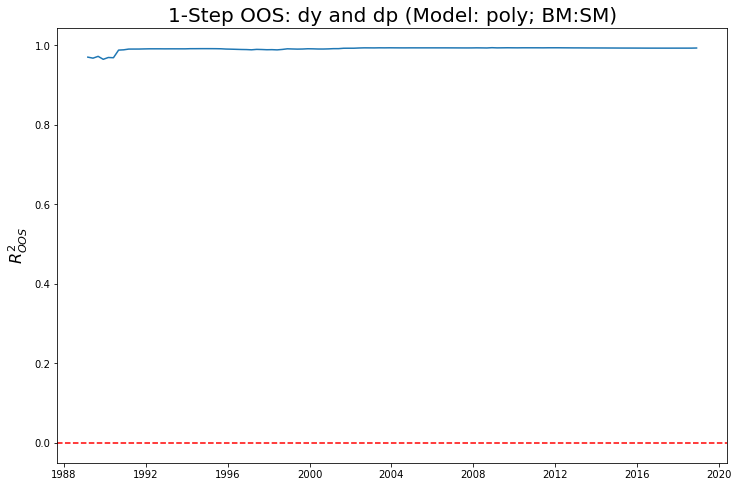

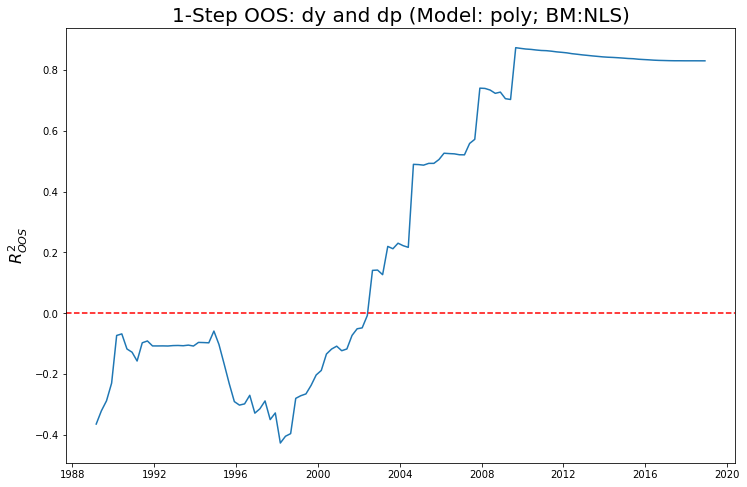

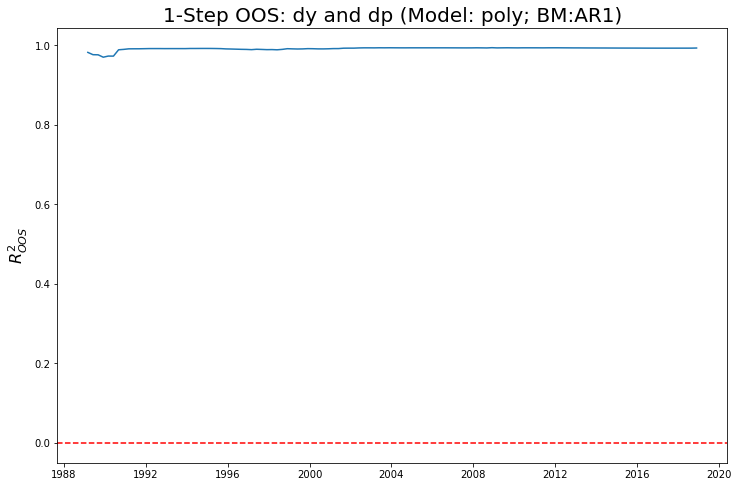

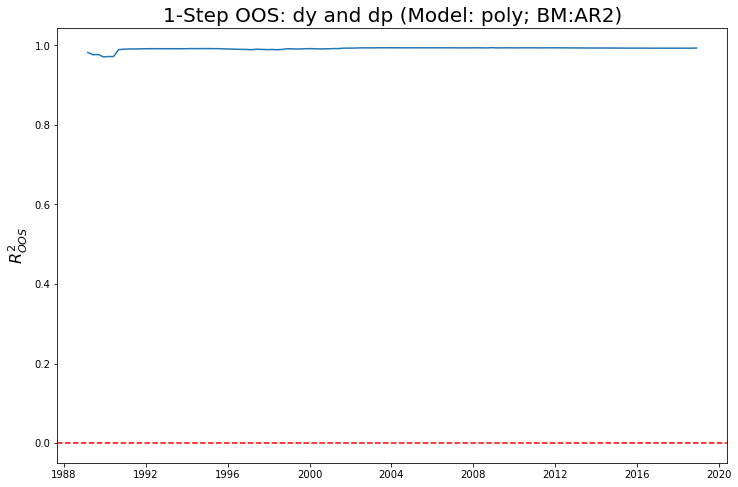

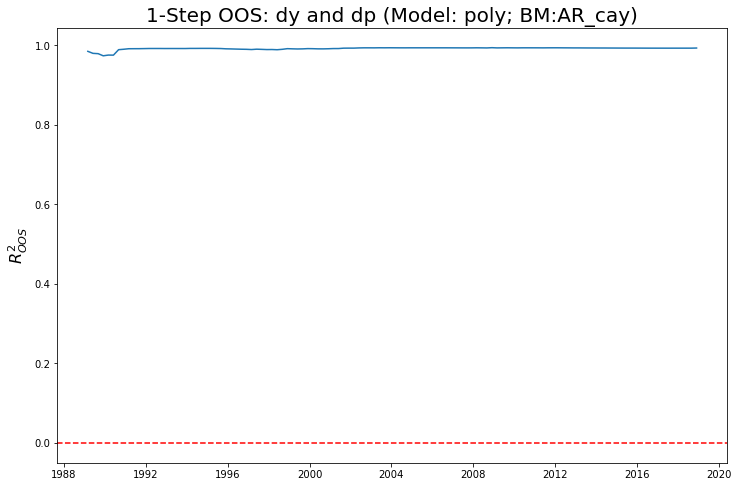

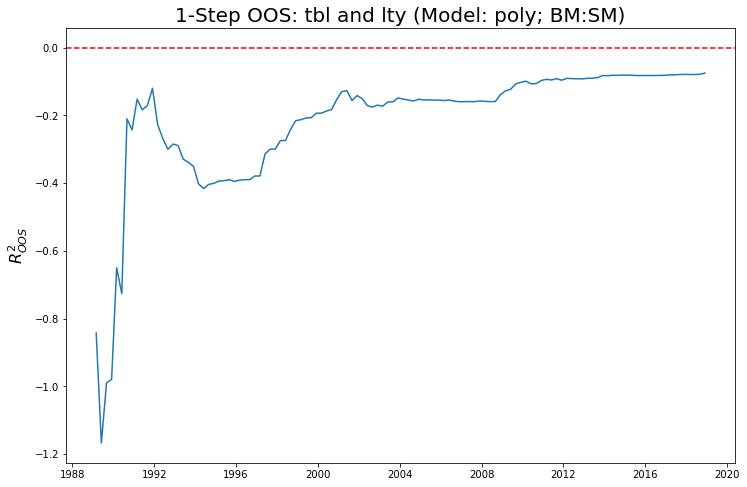

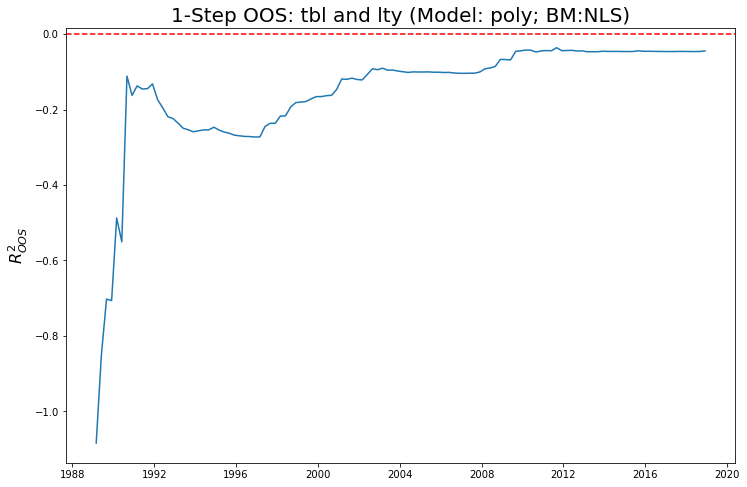

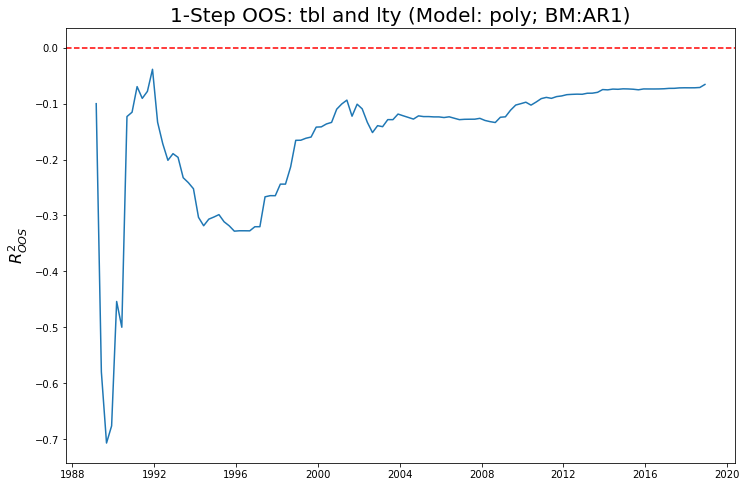

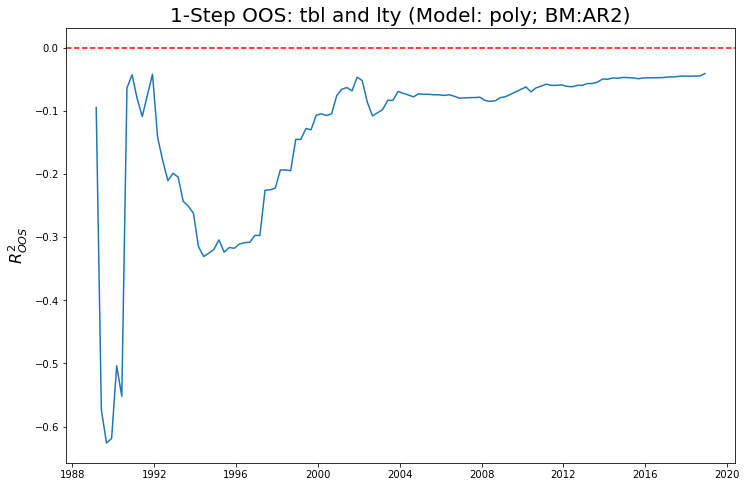

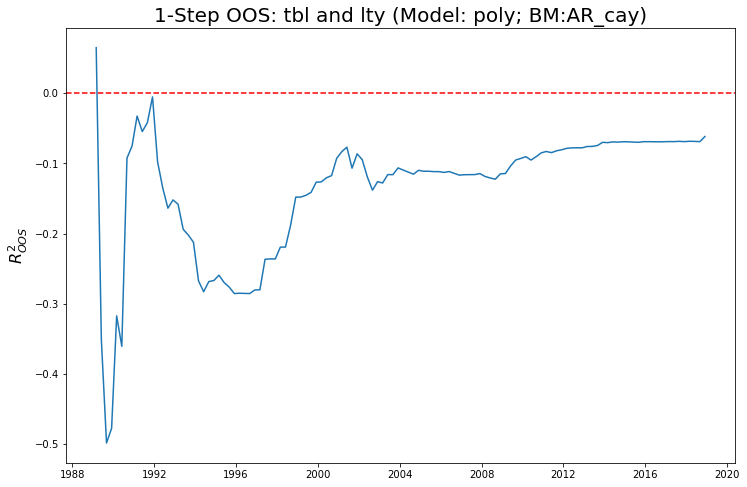

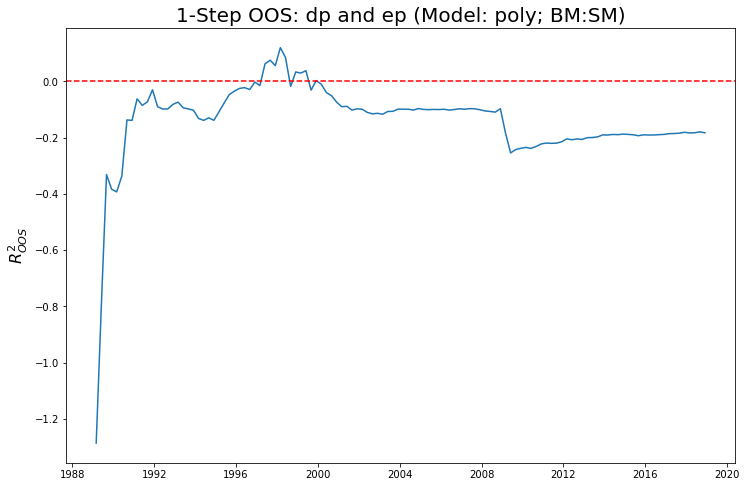

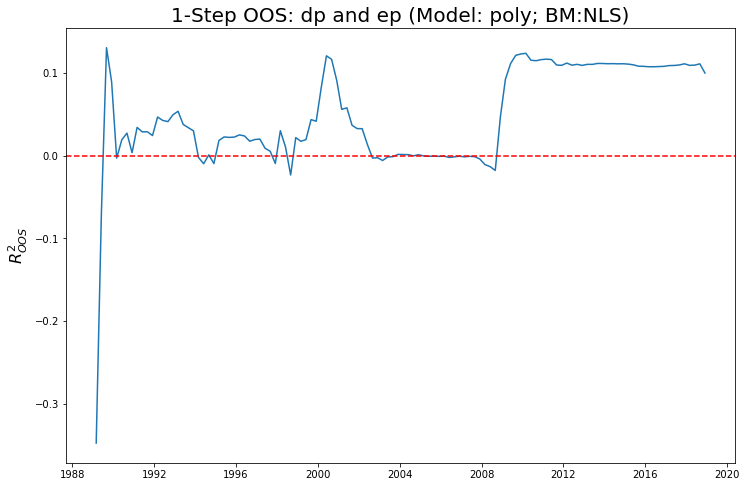

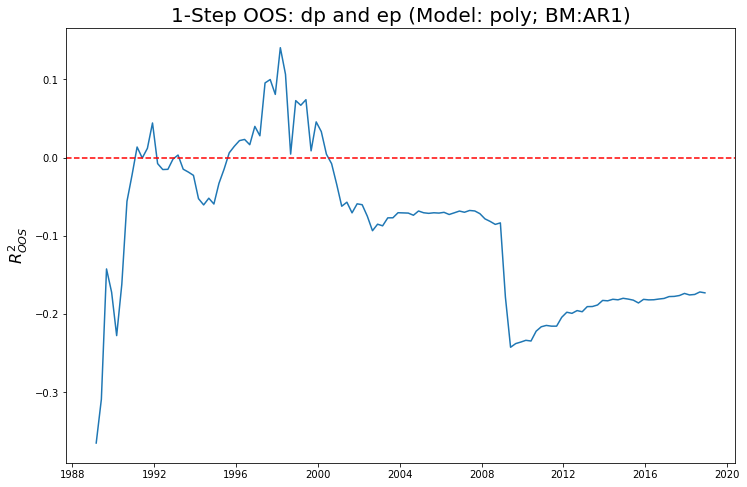

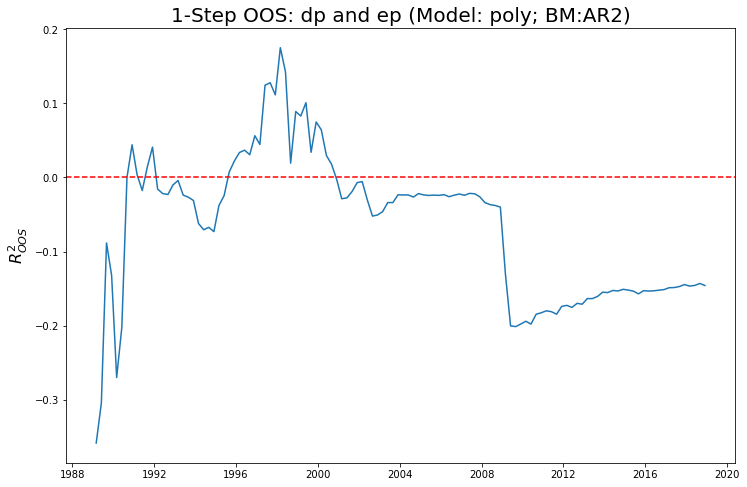

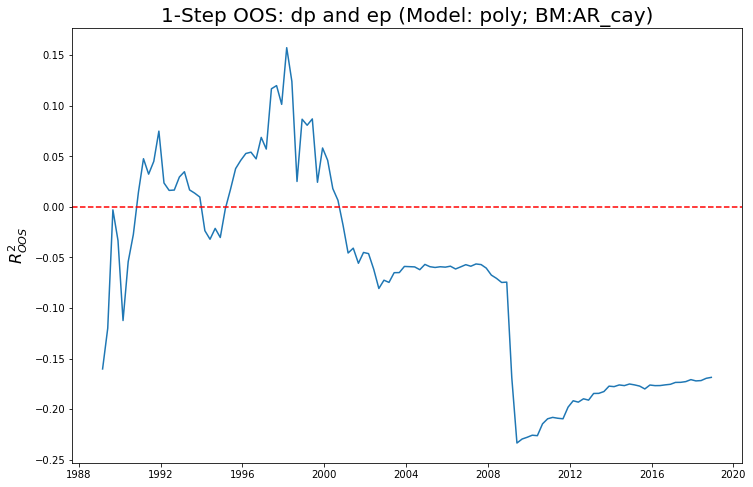

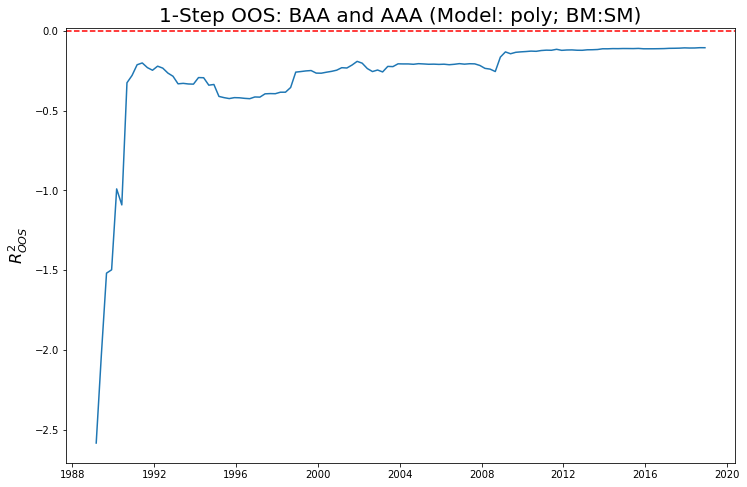

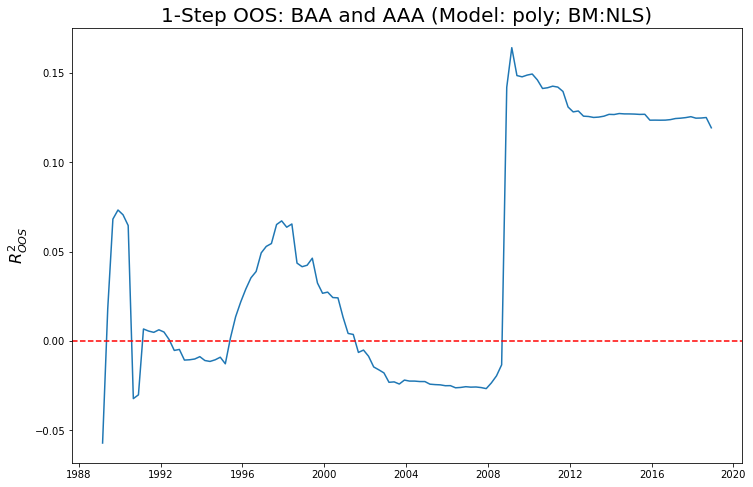

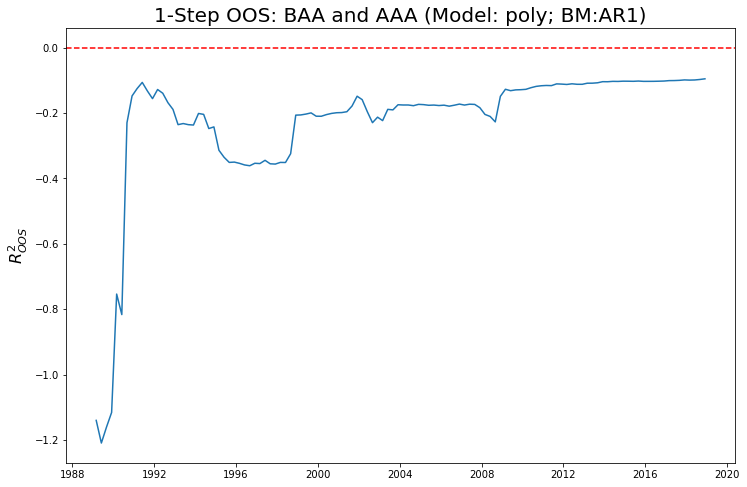

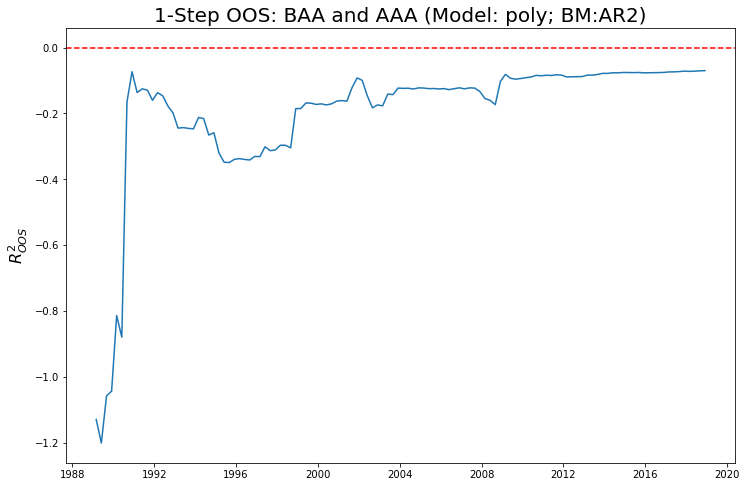

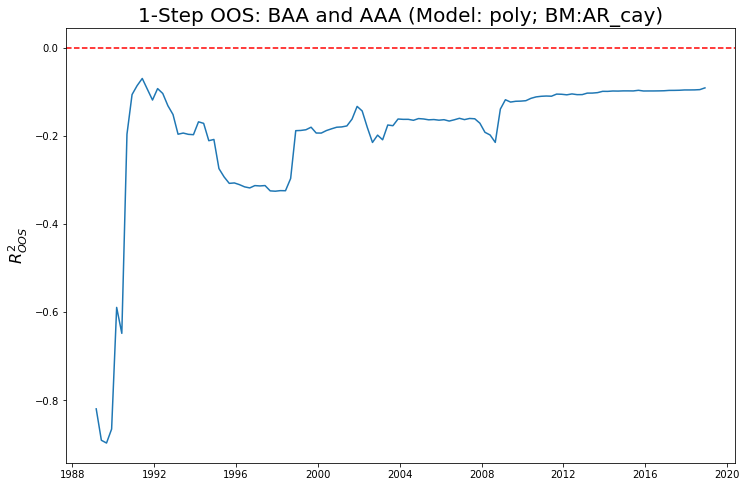

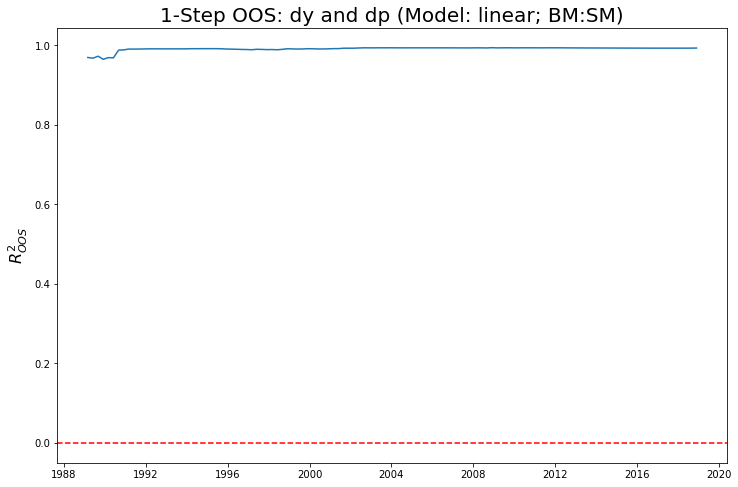

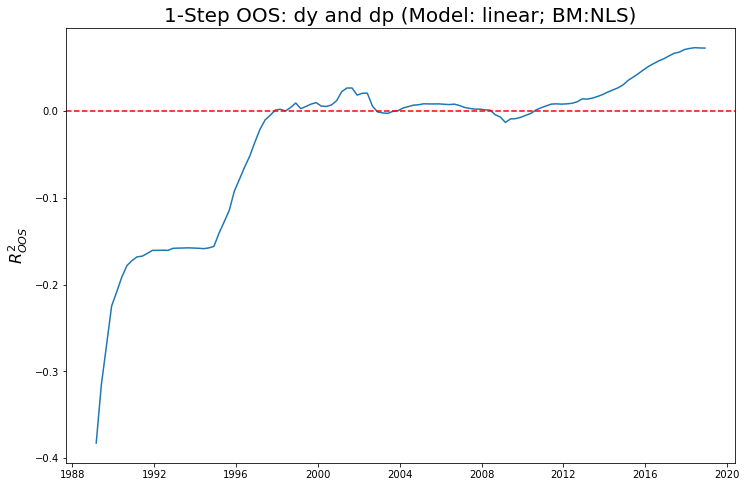

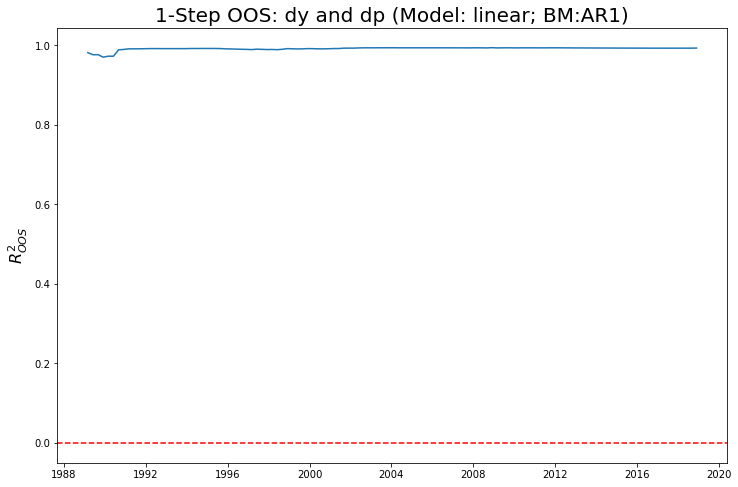

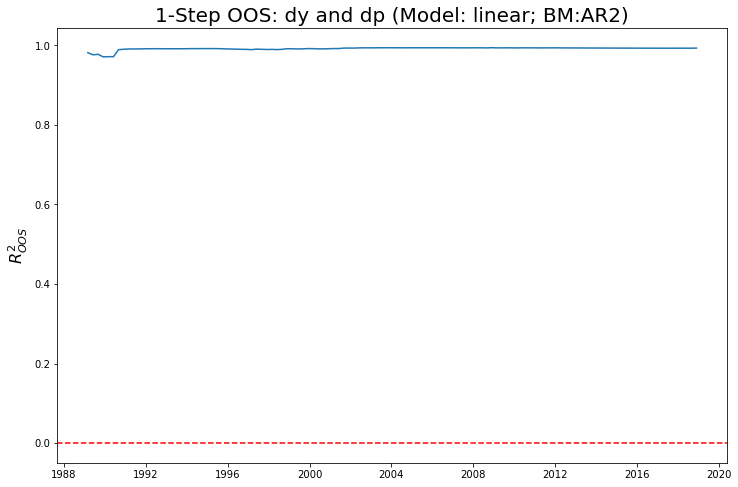

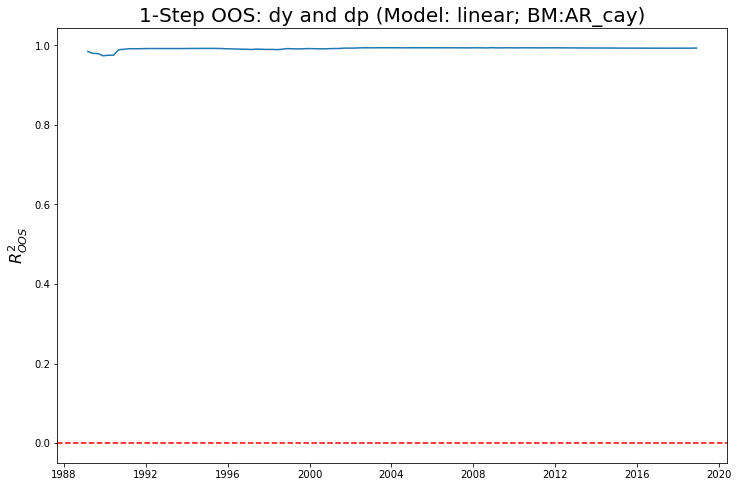

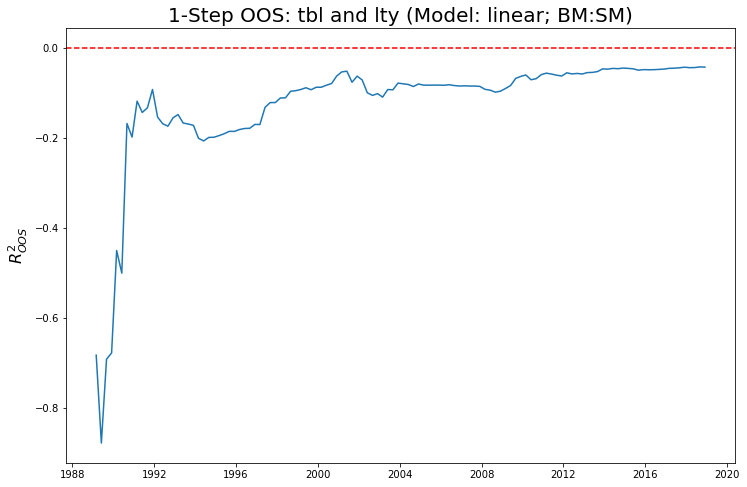

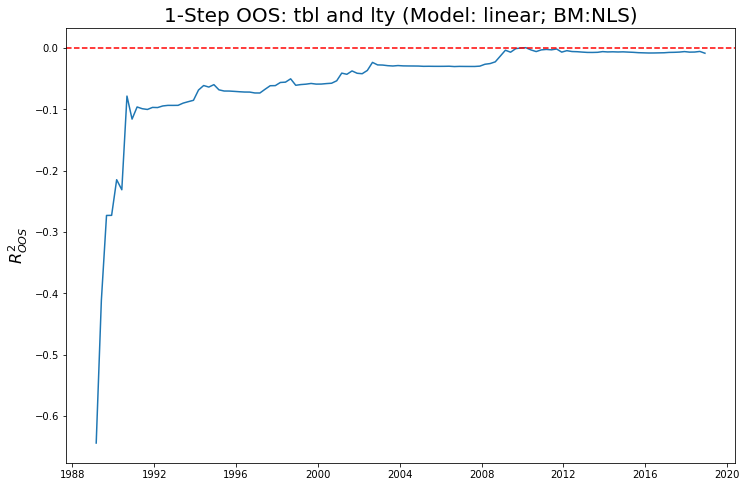

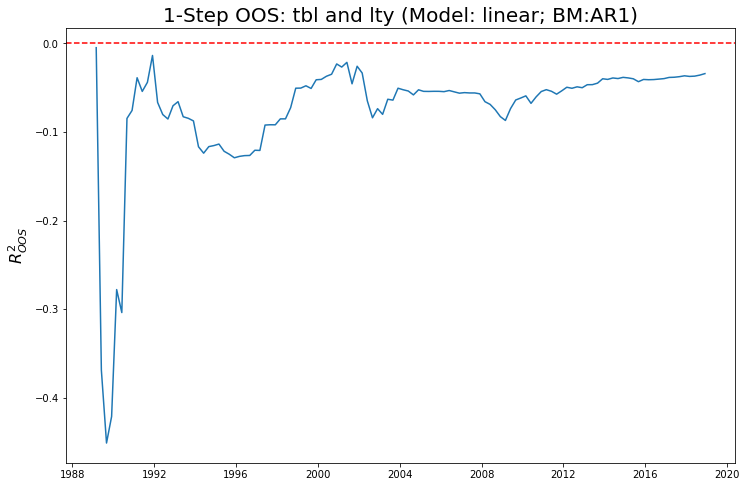

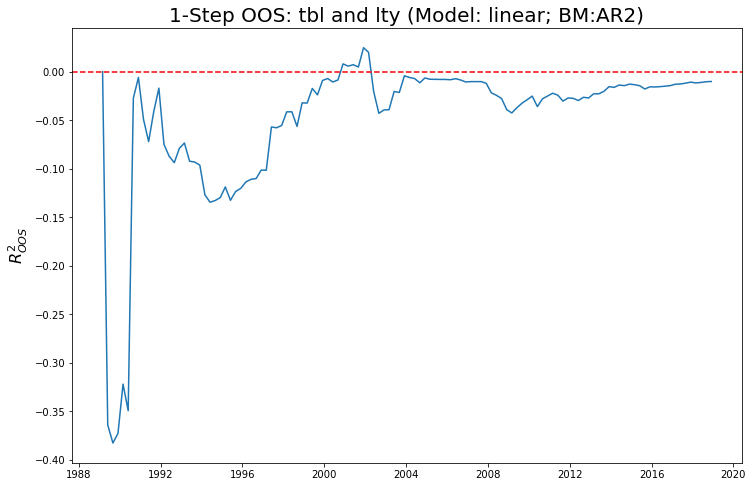

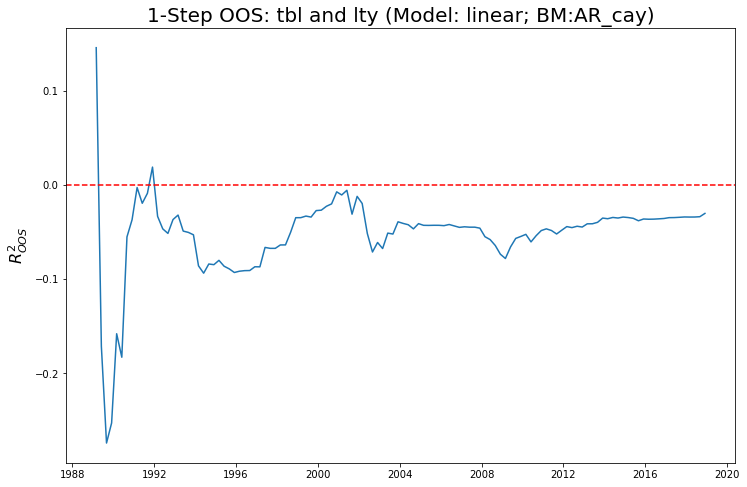

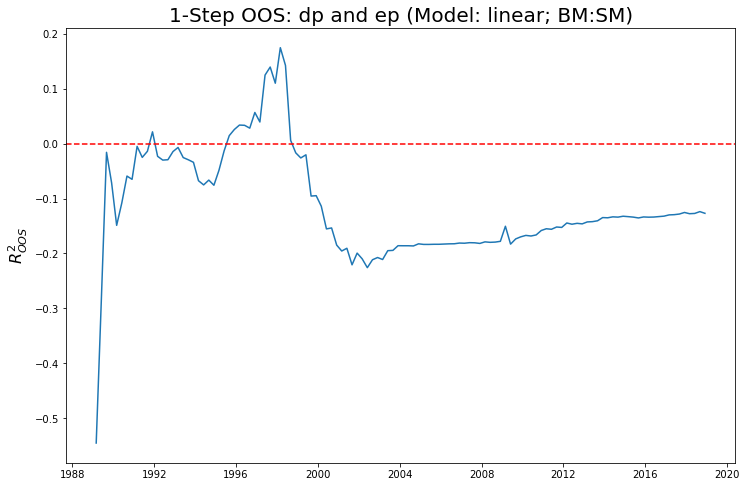

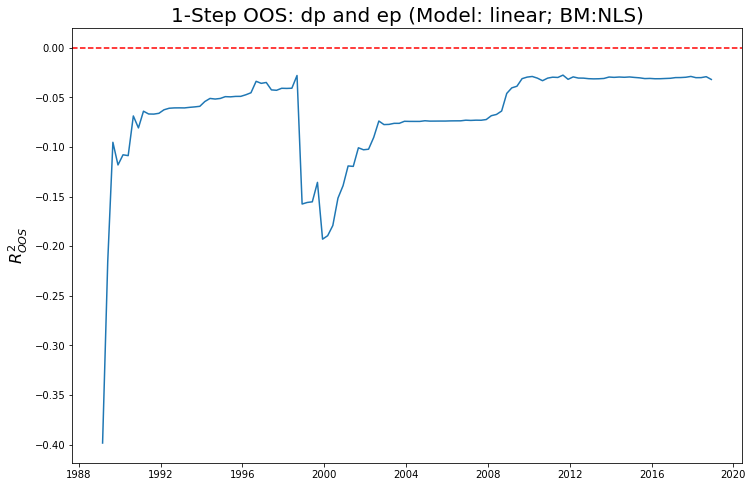

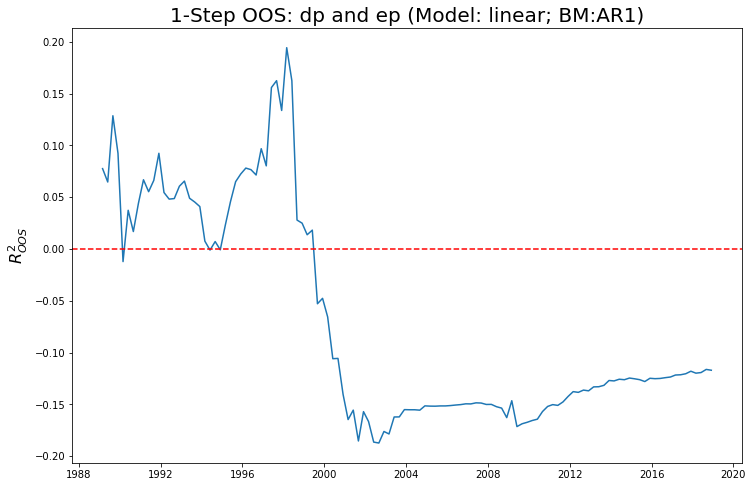

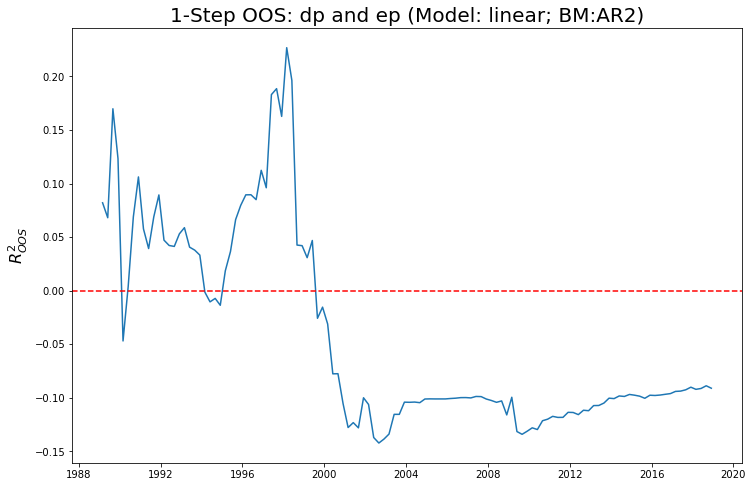

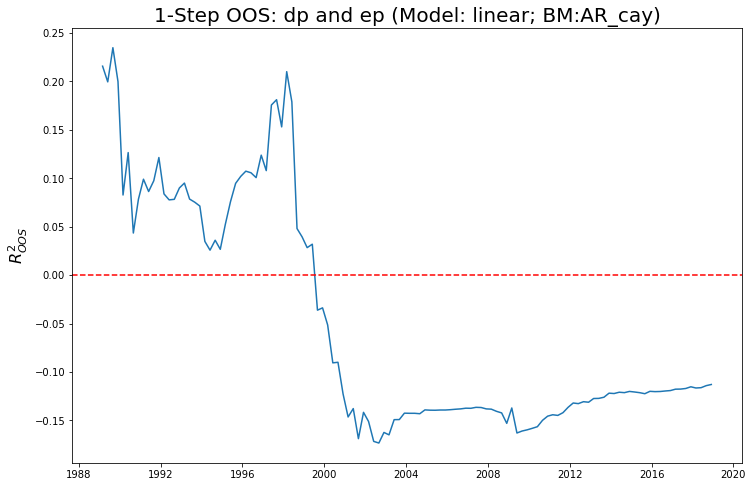

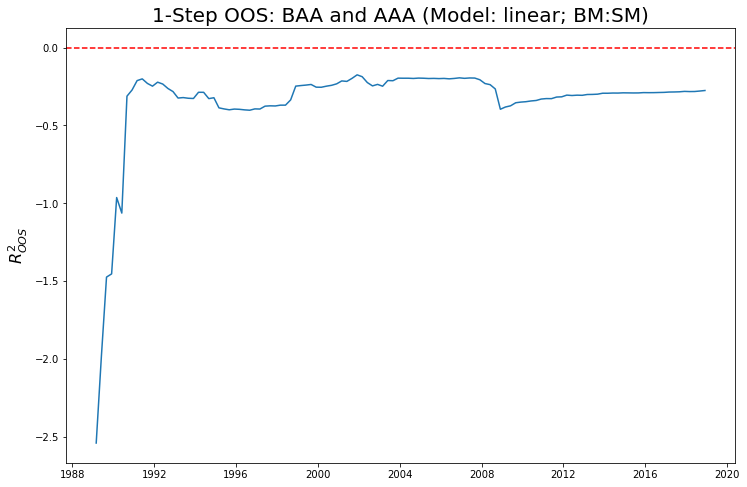

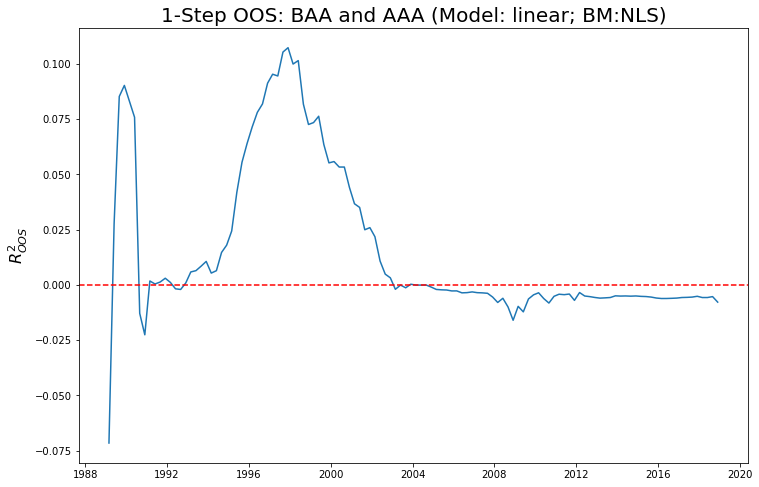

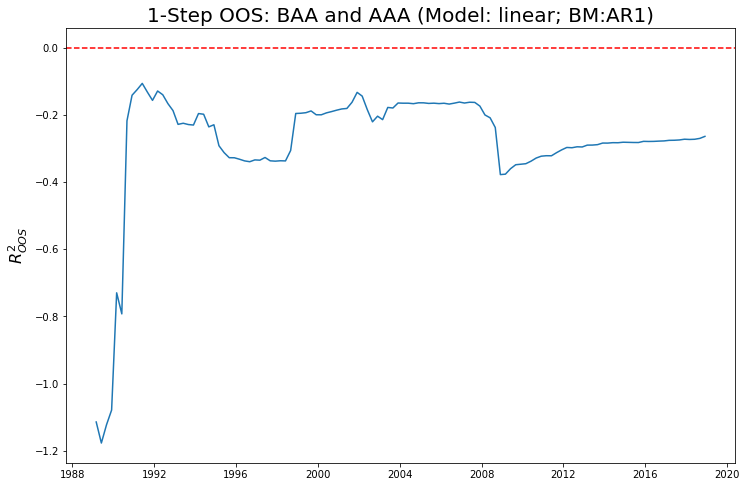

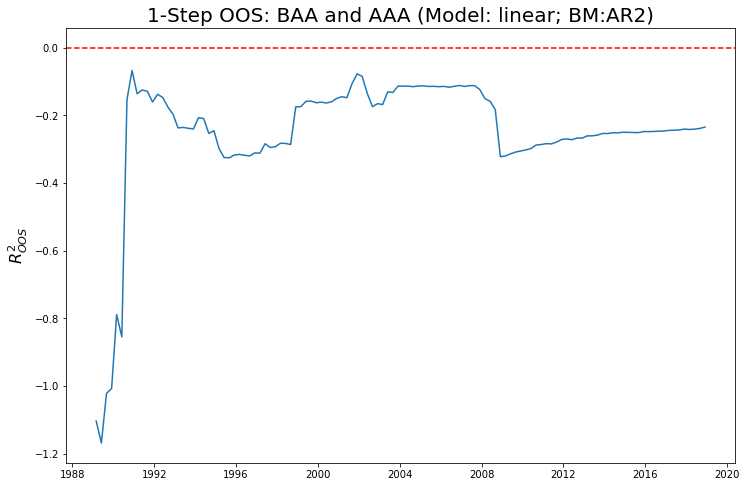

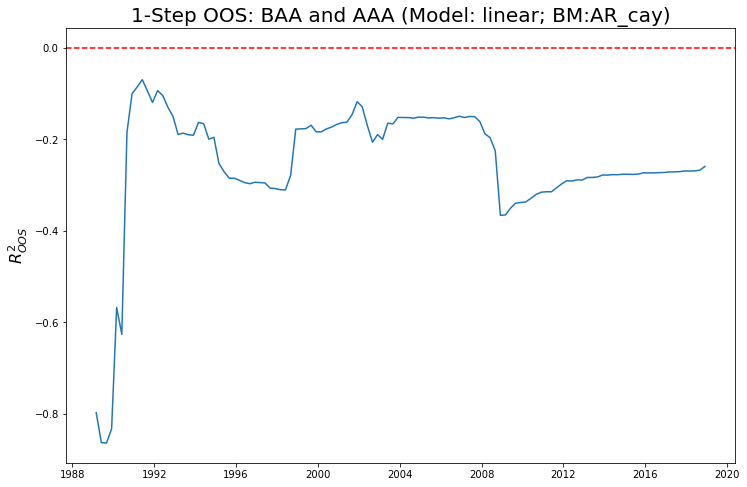

In [343]:
parent = os.getcwd()
folder = 'OOS_plots/taylor_0819'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    R2 = pd.read_excel('results/OOS_R2_taylor.xlsx', header=[0,1], index_col=0, sheet_name = k.__name__)['1989-03-01':]
    for i,j in itertools.product(co_list, base):
        fig = plt.figure(figsize = (12,8))
        plt.plot(R2[i][j])
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('1-Step OOS: '+ co_dict[i] + ' (' + 'Model: '+ k.__name__[:-5] + '; BM:' + j + ')', fontsize=20)
        plt.ylabel("$R^2_{OOS}$", fontsize=16)
        plt.savefig(os.path.join(path, k.__name__[:-5] + '_' + i + '_' + j))

## Regenerate results for project 2

In [275]:
writer_R2 = pd.ExcelWriter('results/OOS_R2_project2.xlsx', engine='xlsxwriter')

for f in fun_list:
    oos_MSE = pd.read_excel('results/OOS_MSE_start0.xlsx', header=[0,1], index_col=0, sheet_name = f)
    for i, j in itertools.product(base, co_list):
        cumu_sum = []
        target_sum = []
        cumu_R2 = []
        k = i + '_MSE'
        for R in range(len(oos_MSE[j][k])):
            target_sum.append(oos_MSE[j]['NLS_MSE'][-(R+1):].sum())
            cumu_sum.append(oos_MSE[j][k][-(R+1):].sum())
        cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
        cumulate_R2.loc[j].loc[i] = cumu_R2
    cumulate_R2.T.to_excel(writer_R2, sheet_name=f)
writer_R2.save()
writer_R2.close()

In [276]:
fun_list = ['sin_func',
            'cos_func',
            'scaled_sin_func',
            'scaled_cos_func',
            'exp_shift_func',
            'exp_func',
            'poly_func']

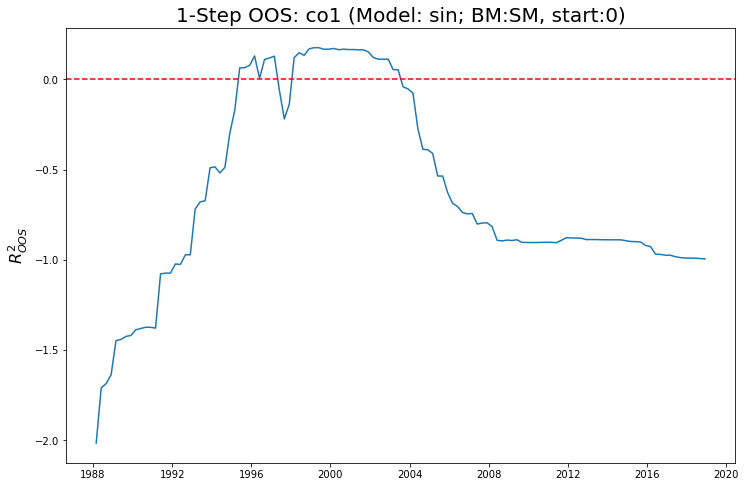

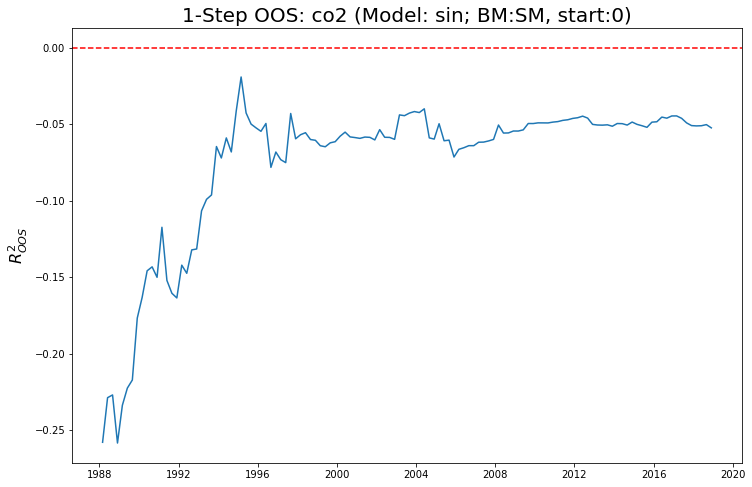

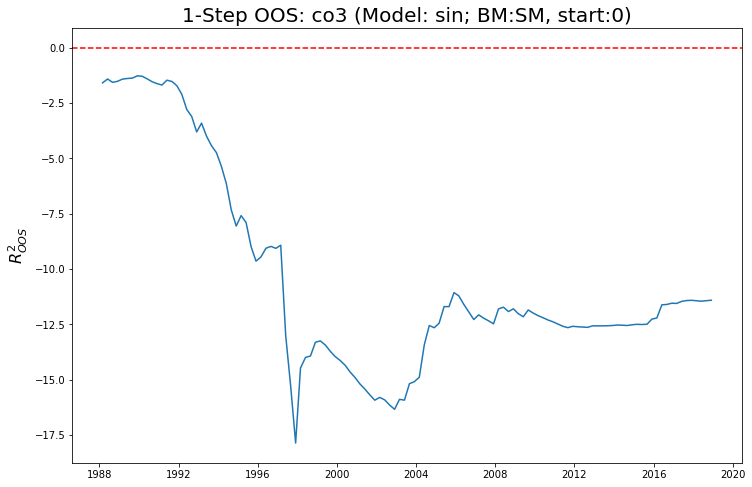

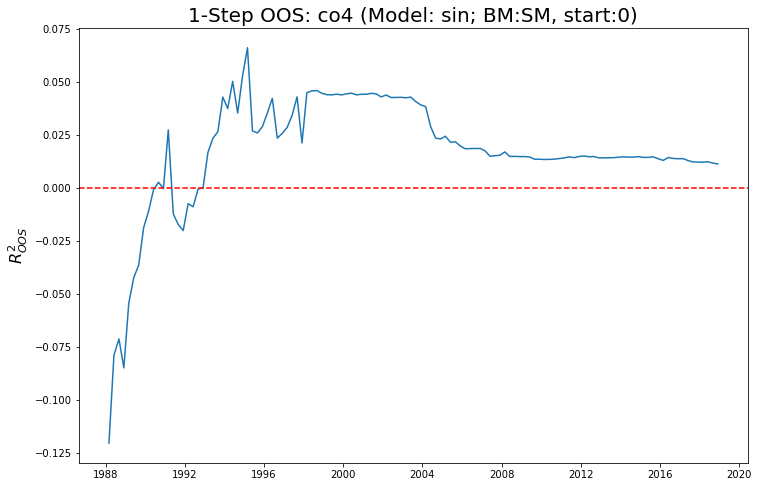

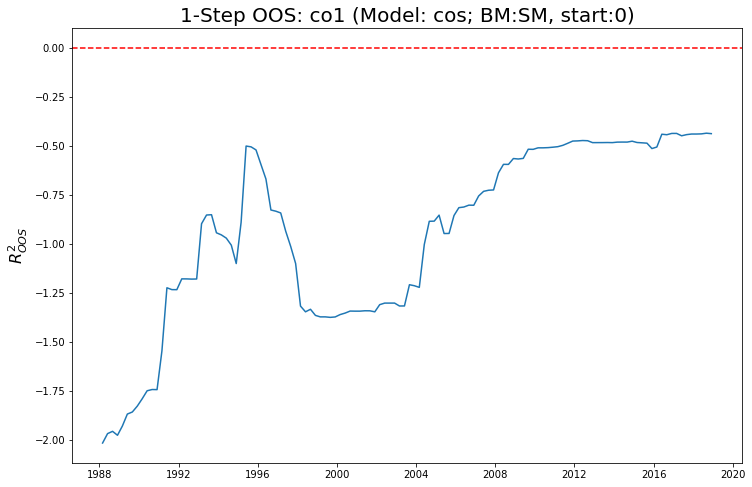

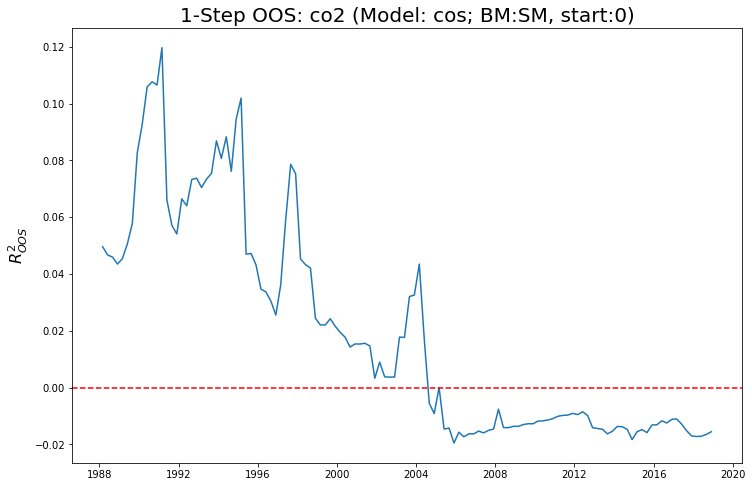

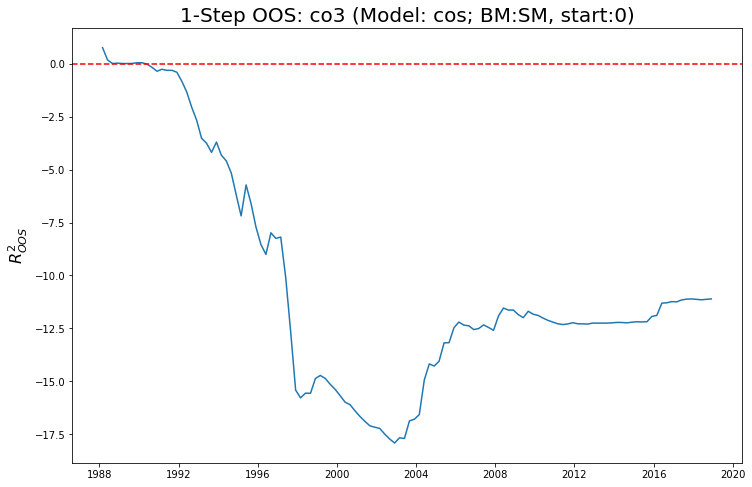

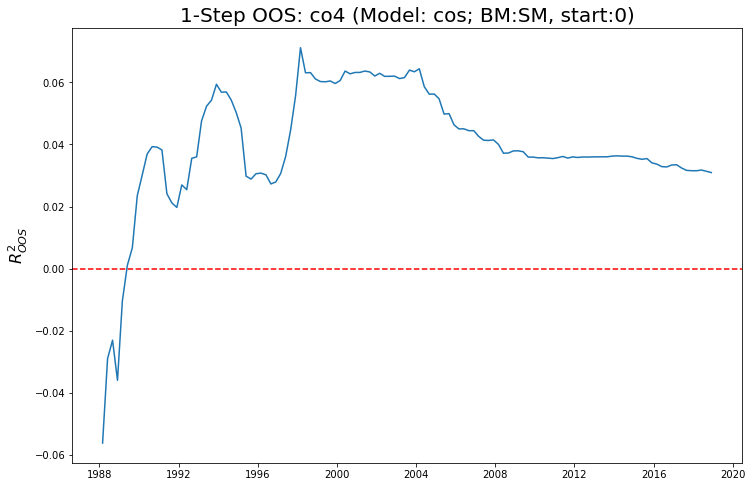

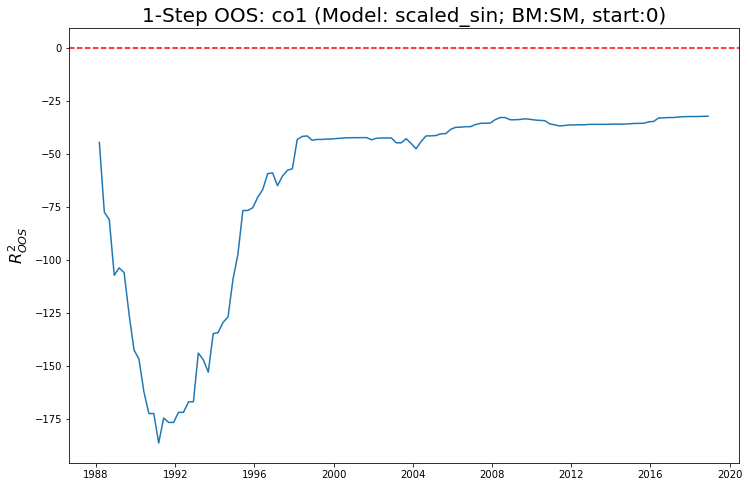

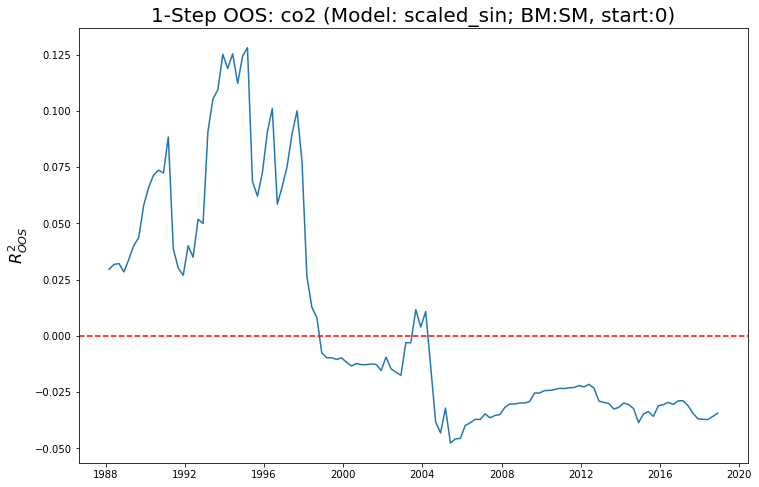

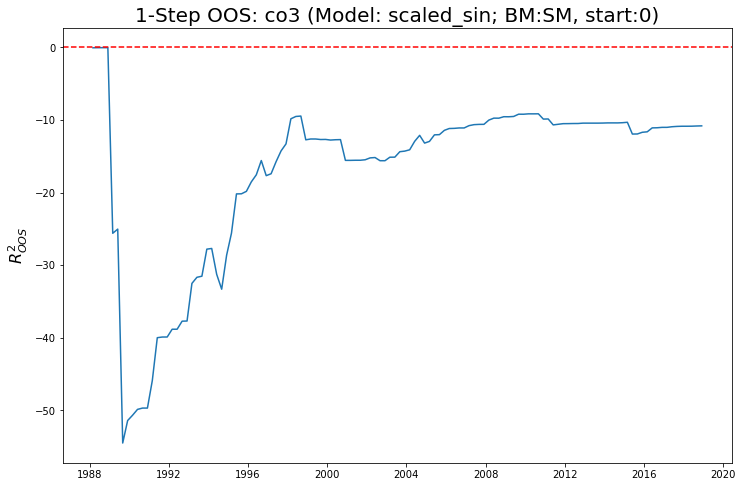

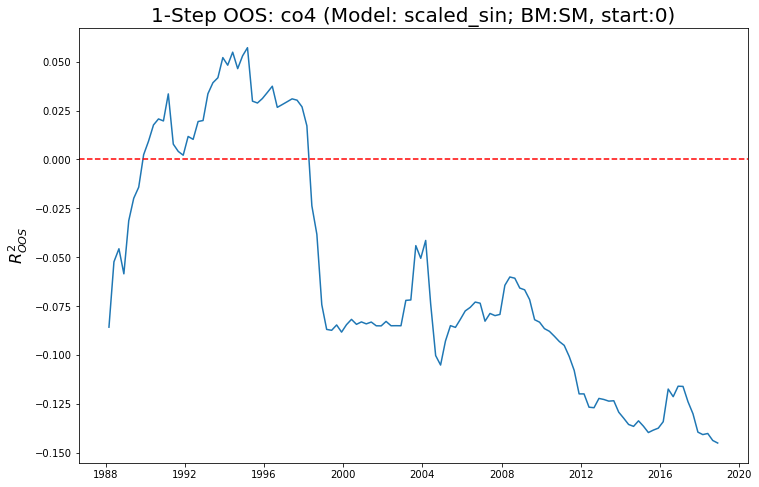

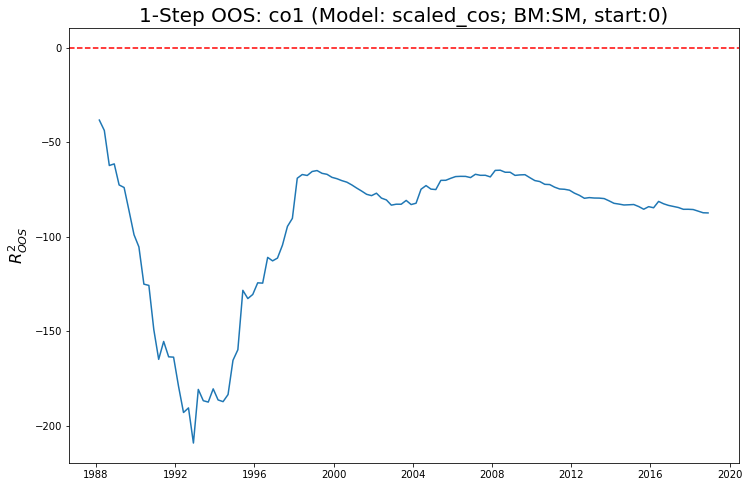

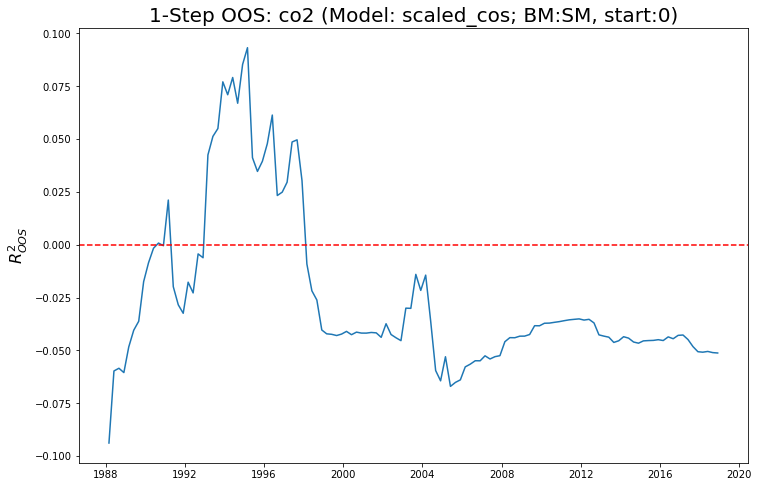

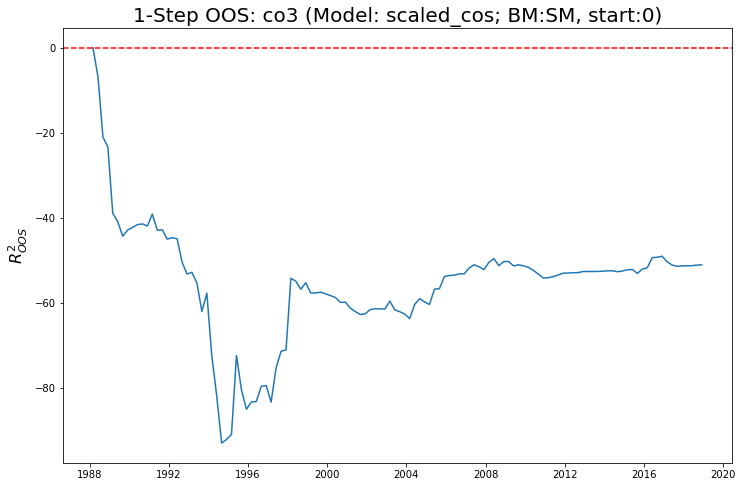

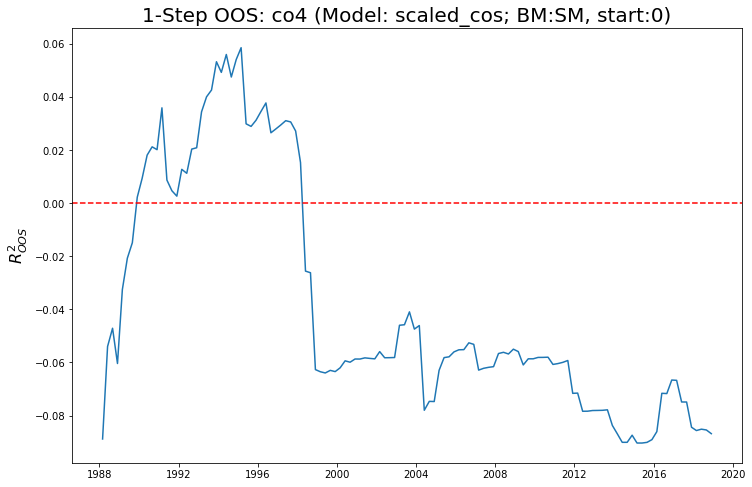

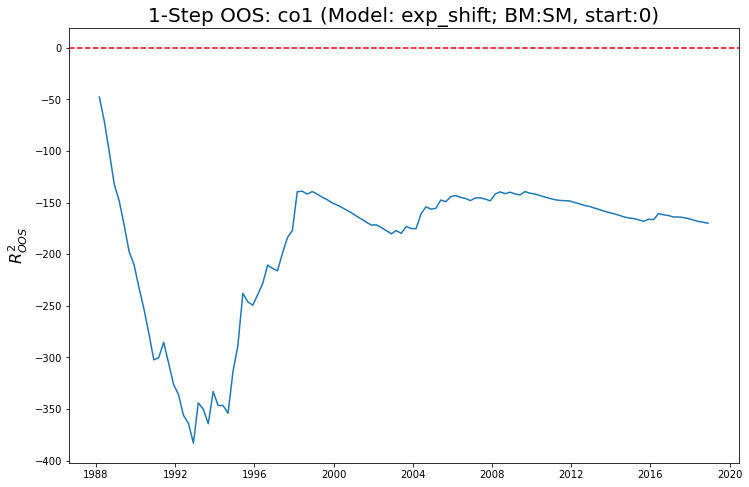

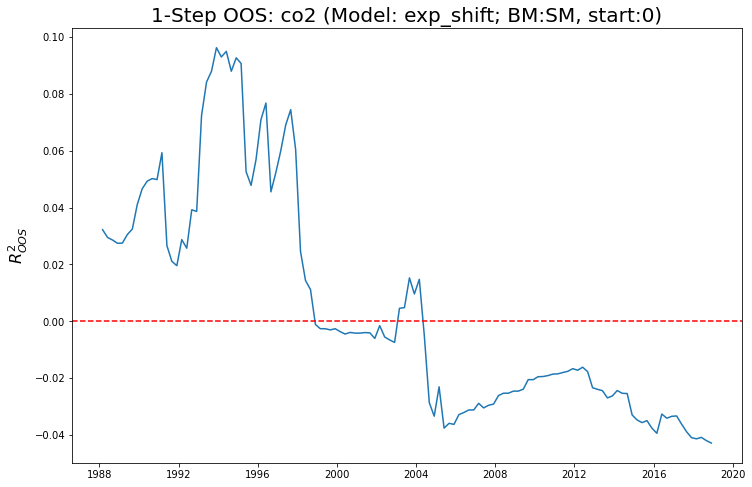

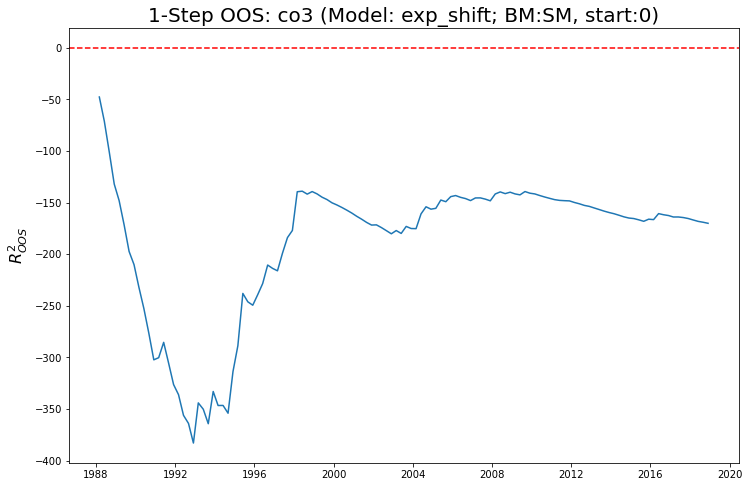

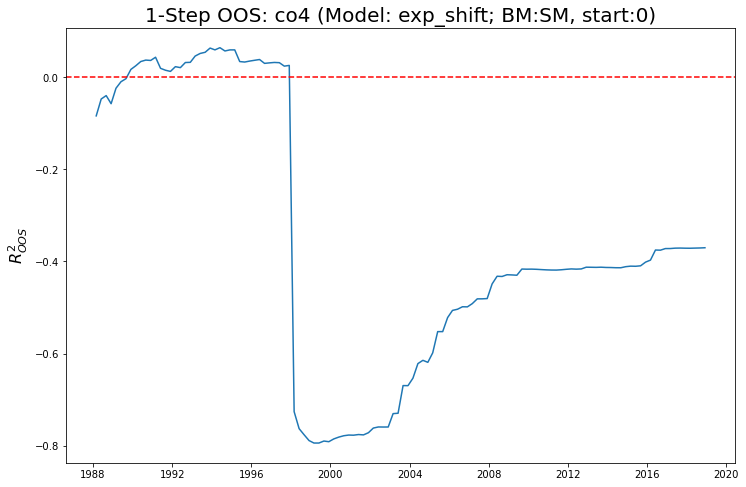

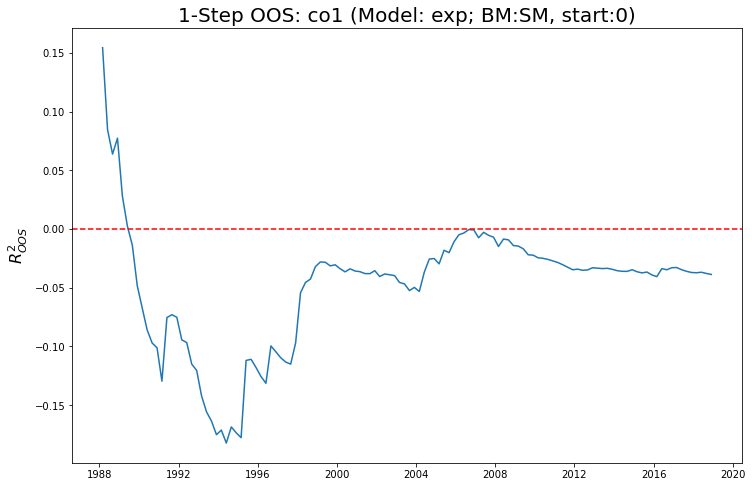

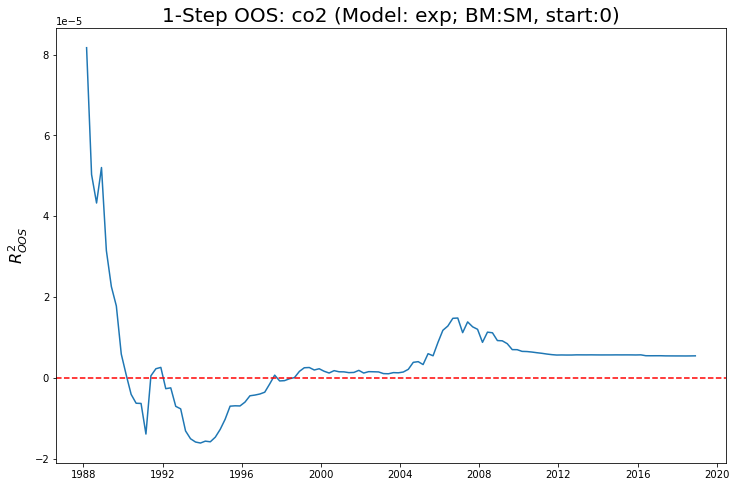

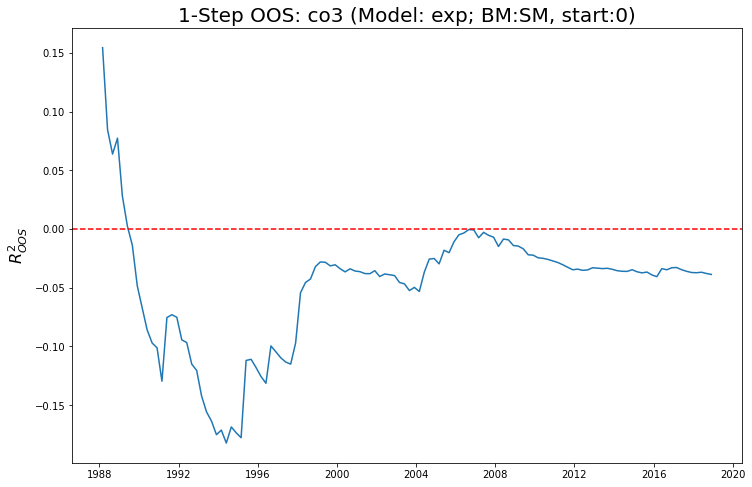

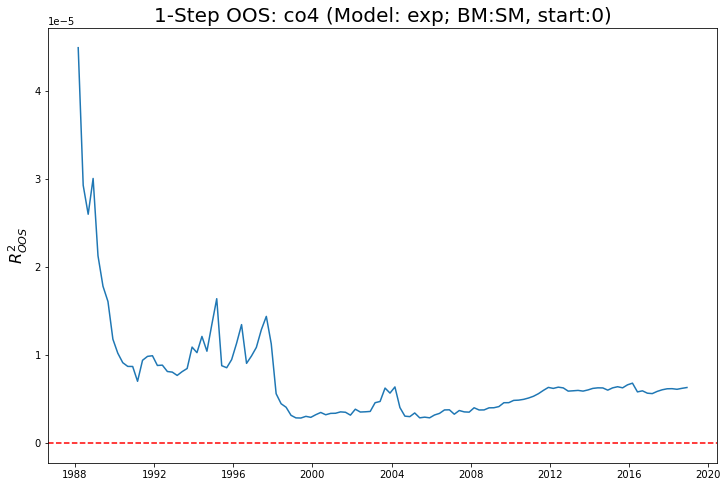

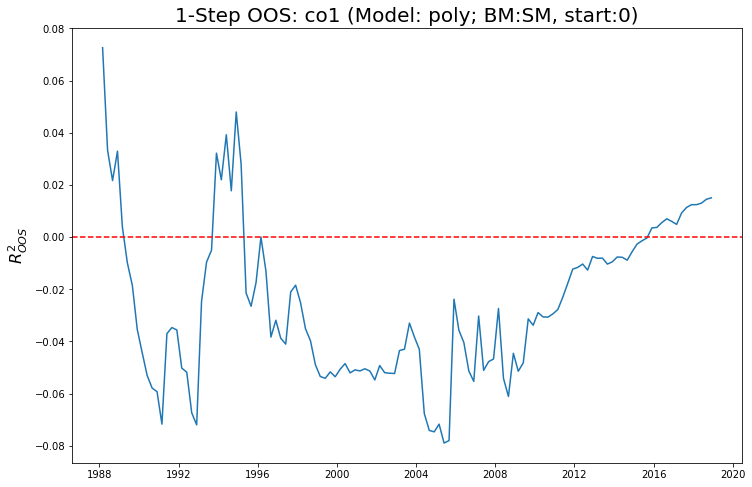

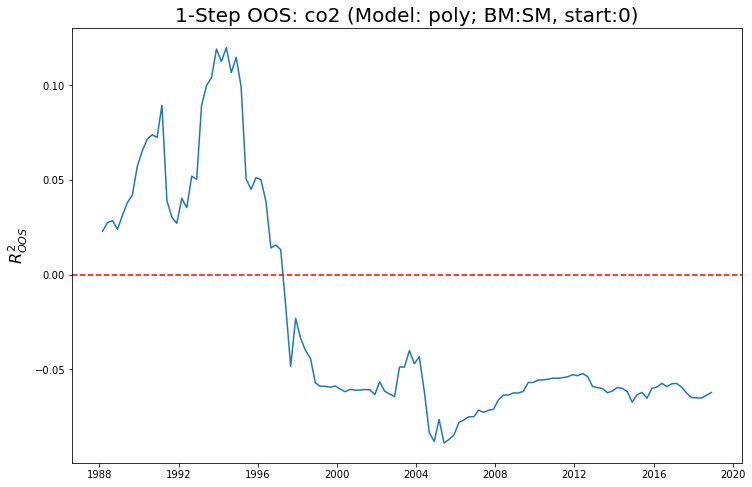

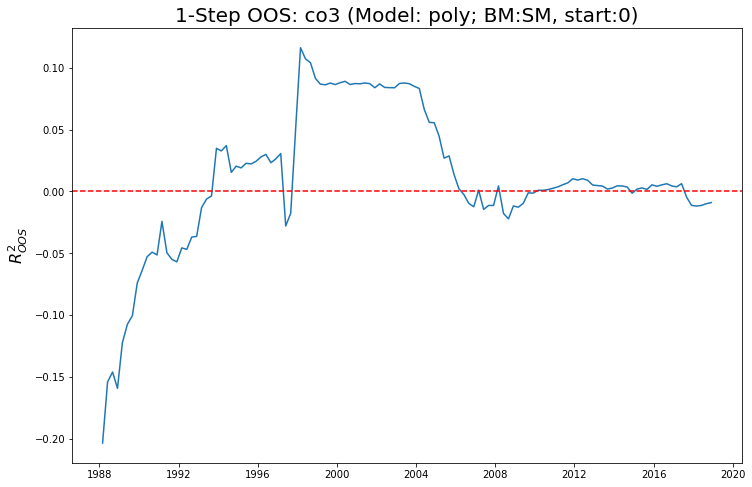

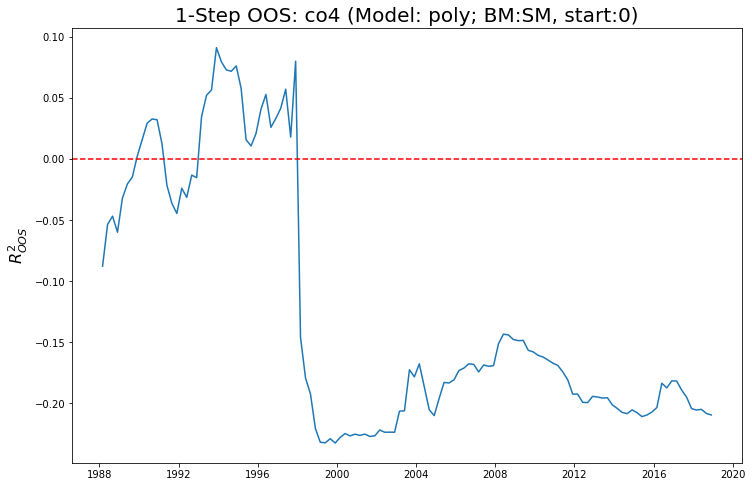

In [277]:
parent = os.getcwd()
folder = 'OOS_plots/project2'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    R2 = pd.read_excel('results/OOS_R2_project2.xlsx', header=[0,1], index_col=0, sheet_name = k)
    for i in co_list:
#         print(i)
        fig = plt.figure(figsize = (12,8))
        plt.plot(R2[i]['SM'])
        plt.axhline(y=0, color='r', linestyle='--')
        
        plt.title('1-Step OOS: '+ i + ' (' + 'Model: '+ k[:-5] + '; BM:' + 'SM' + ', start:0)', fontsize=20)
        plt.ylabel("$R^2_{OOS}$", fontsize=16)
        plt.savefig(os.path.join(path, k[:-5] + '_' + i + '_' + 'SM' + '_0'))

# Plot U

In [26]:
results = pd.read_excel('results/full_sample.xlsx', header=[0,1], index_col=[0,1])
results_taylor = pd.read_excel('results/Taylor_fullsample.xlsx', header=[0,1], index_col=[0,1])

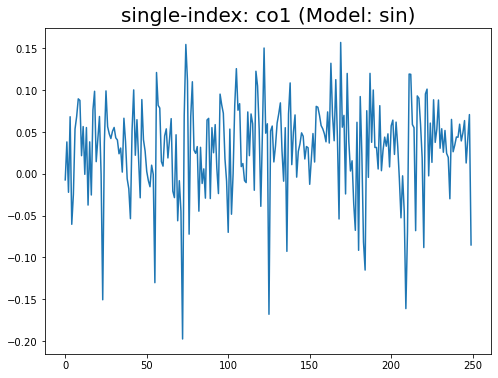

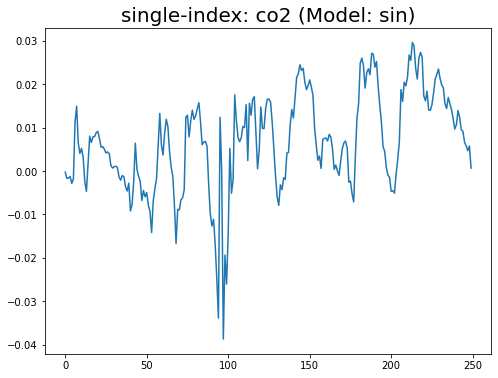

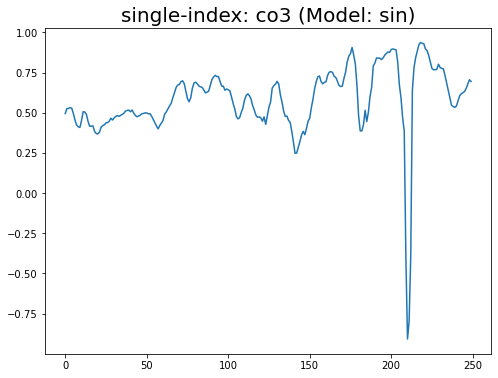

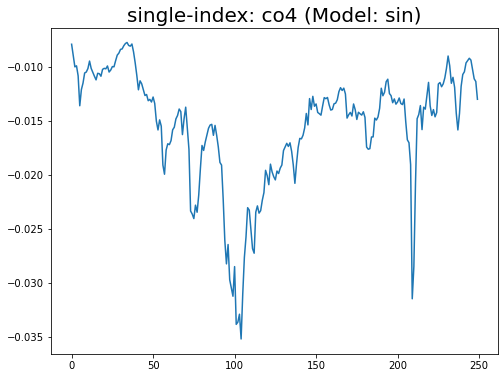

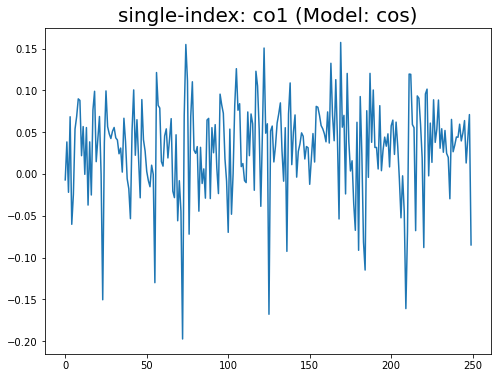

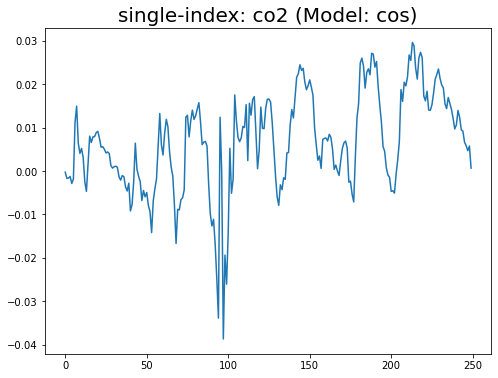

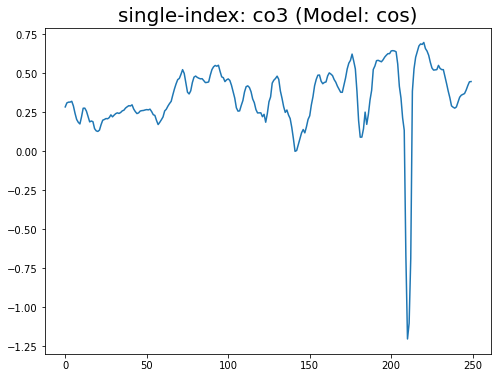

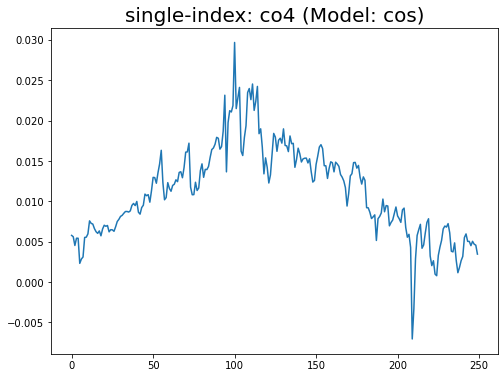

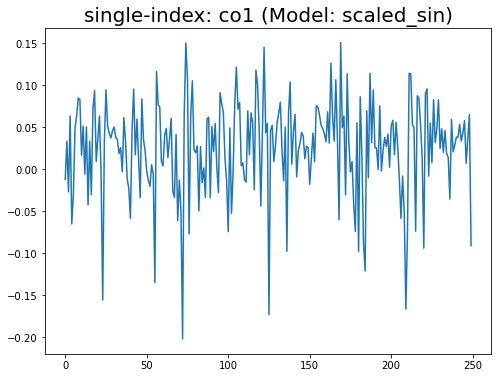

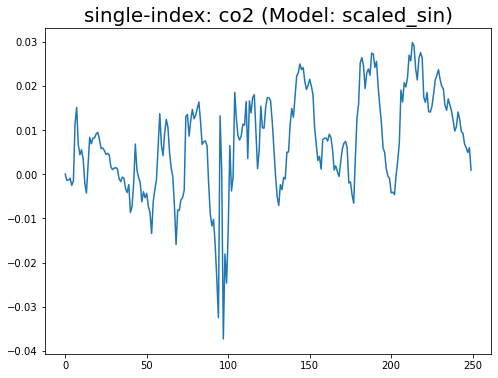

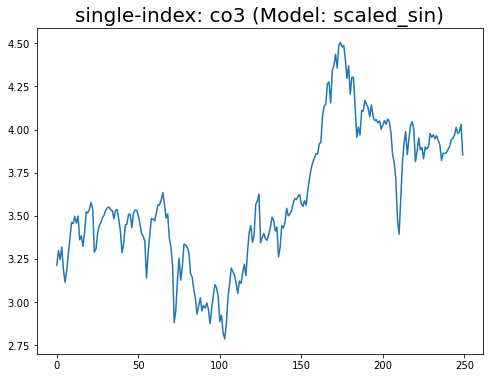

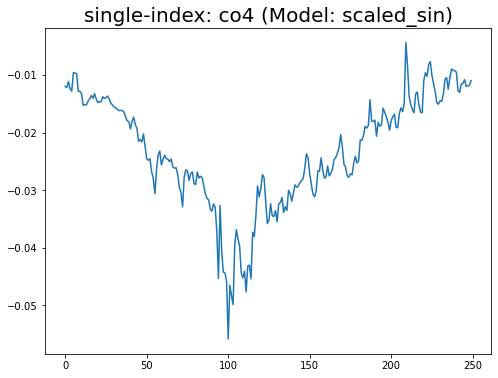

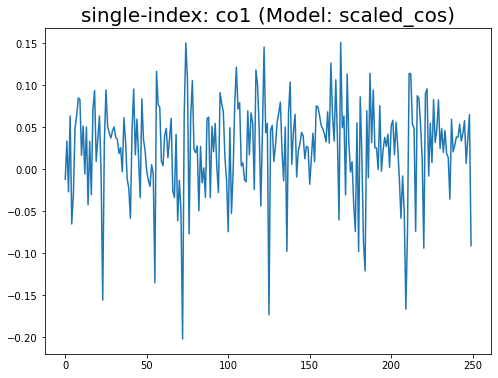

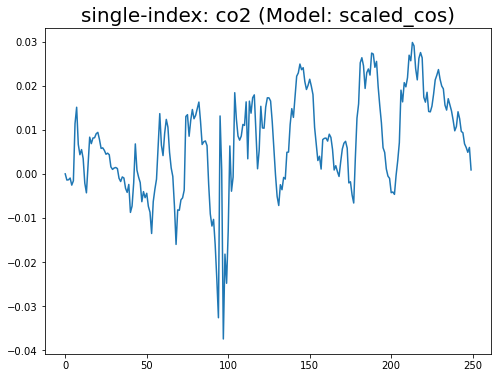

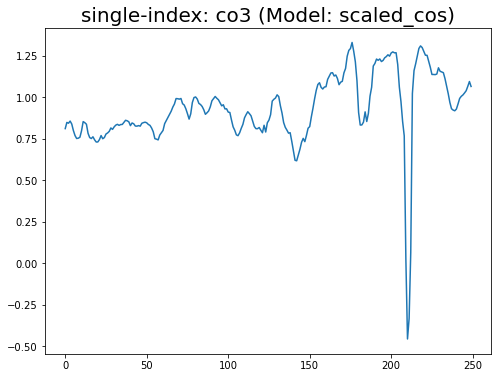

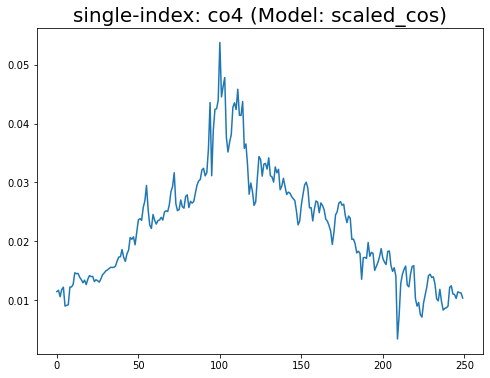

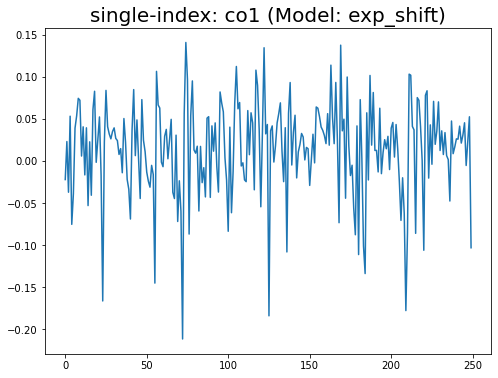

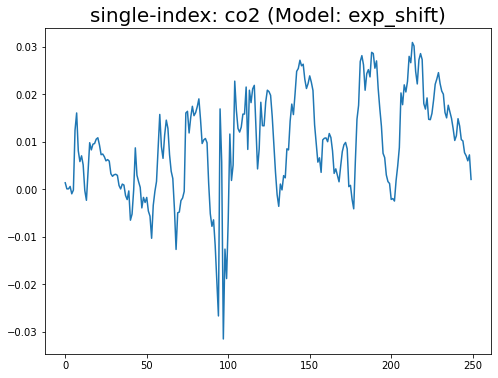

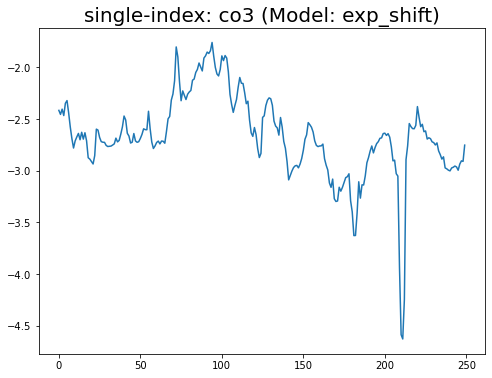

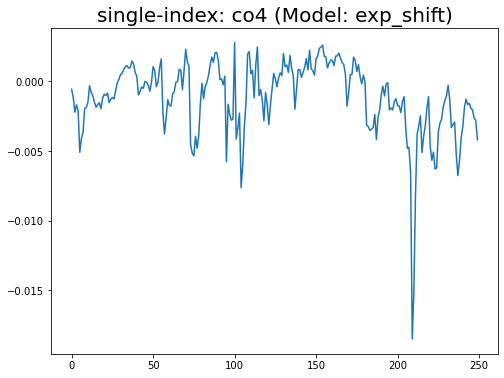

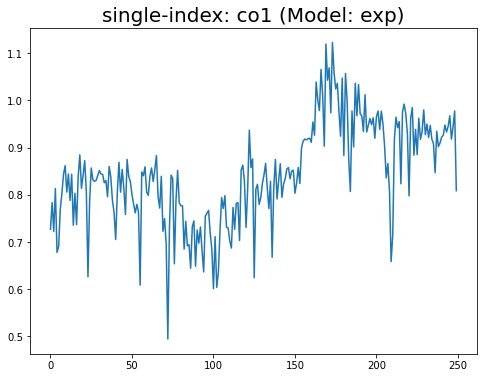

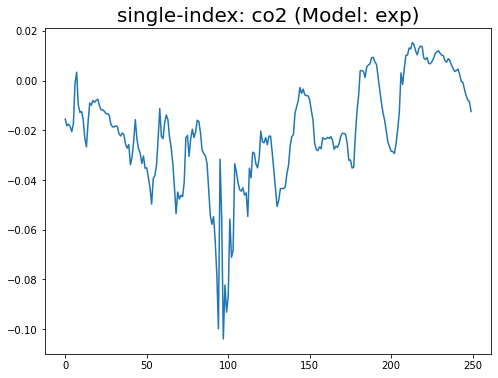

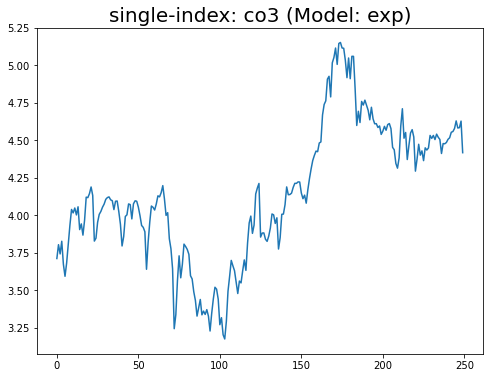

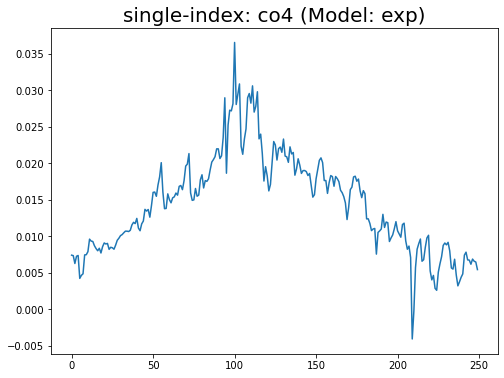

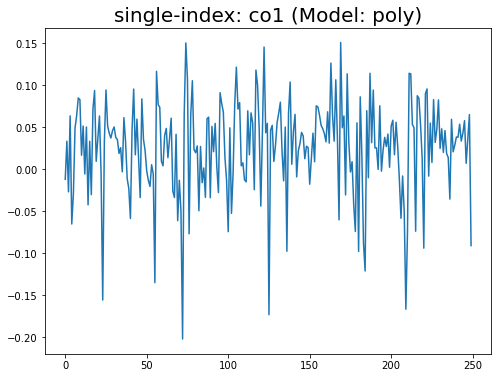

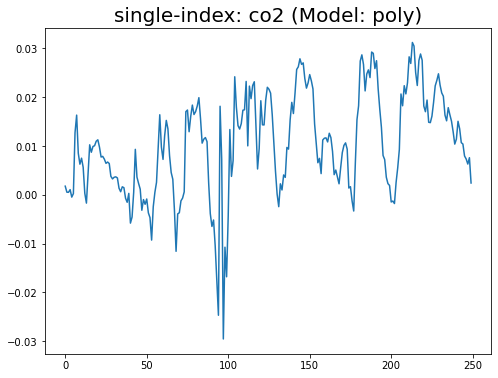

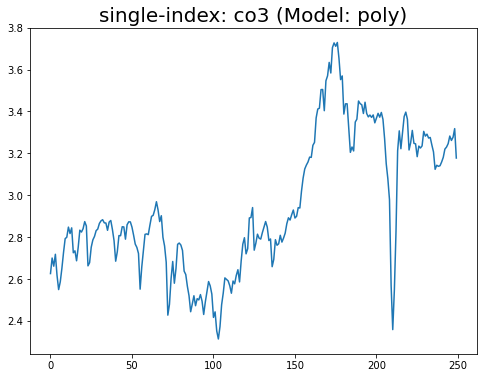

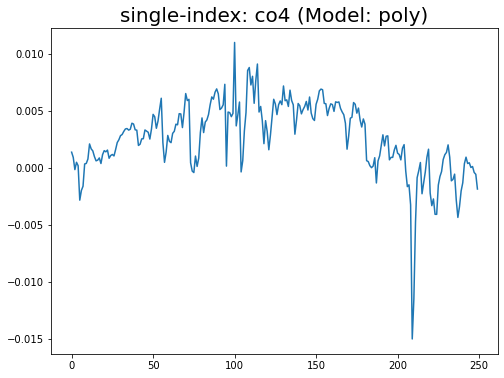

In [284]:
#Set up directory
parent = os.getcwd()
folder = 'single_index'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    for i,j in enumerate(cointe_ar2):
        fig = plt.figure(figsize = (8,6))
        plt.plot(single_index(j)(results_taylor['CLS'][['param_1', 'param_2']].loc[k].loc[co_list[i]]))
        plt.title('single-index: '+ co_list[i] + ' (' + 'Model: '+ k[:-5] + ')', fontsize=20)
        plt.savefig(os.path.join(path, k[:-5] + '_' + co_list[i]))

# In-sample $R^2$

In [298]:
fun_list = [sin_func,
            cos_func,
            scaled_sin_func,
            scaled_cos_func,
            exp_func,
            exp_shift_func,
            poly_func,
            linear_func
           ]

In [113]:
writer_R3 = pd.ExcelWriter('results/insample_R2_sm.xlsx', engine='xlsxwriter')

R2_insample = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar2):
    # Set up dimensions
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['in_sample R2']
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    R2_in = pd.DataFrame(index = multi_index, columns = sec_columns)
    # Prepare X
    X_ = j.join(station_ar2)
    d1, d2, extra= dimensions(j,station_ar2, i.__name__)
    # Fit models
    cls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar2, y_lag2, i), constraints = constraint_func(X_))
    cls.fit(X_, y_lag2)
    R2_ins = 1 - np.sum((cls.predict(X_) - np.array(y_lag2))**2)/np.sum((np.array(y_lag2)-np.mean(y_lag2))**2)
    R2_in.loc[i.__name__,j.name].loc['in_sample R2'] = R2_ins
    R2_insample = R2_insample.append(R2_in, ignore_index = False, sort = False)
    R2_insample.to_excel(writer_R3)
writer_R3.save()
writer_R3.close()

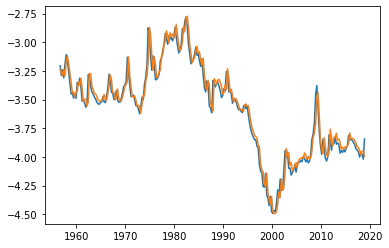

In [281]:
plt.plot(co1_ar2)

## Checking

In [233]:
mse = pd.read_excel('results/OOS_MSE_taylor.xlsx', header=[0,1], index_col=[0], sheet_name = 'sin_func')

In [234]:
mse.head()

Variable             co1                                                     \
Model            CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE   AR2_MSE AR_cay_MSE   
time                                                                          
1988-03-01  4.864016e-04  0.001170  0.000096  0.004550  0.006396   0.005513   
1988-06-01  1.352886e-04  0.001787  0.000144  0.001519  0.000033   0.001798   
1988-09-01  7.140352e-05  0.000424  0.000060  0.000611  0.000404   0.000457   
1988-12-01  9.484371e-07  0.000014  0.000005  0.000033  0.000156   0.000092   
1989-03-01  3.037400e-05  0.001480  0.000024  0.001450  0.001213   0.001743   

Variable         co2                                ...       co3            \
Model        CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE  ...   NLS_MSE   AR1_MSE   
time                                                ...                       
1988-03-01  0.003160  0.001170  0.000525  0.004550  ...  0.006145  0.004550   
1988-06-01  0.001529  0.001787  0.001359  0.001519  ...  0.026609  0.001519   
1988-09-01  0.000305  0.000424  0.000371  0.000611  ...  0.011251  0.000611   
1988-12-01  0.000366  0.000014  0.000151  0.000033  ...  0.018329  0.000033   
1989-03-01  0.003296  0.001480  0.002794  0.001450  ...  0.036101  0.001450   

Variable                              co4                                \
Model        AR2_MSE AR_cay_MSE   CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE   
time                                                                      
1988-03-01  0.006396   0.005513  0.005648  0.001170  0.001352  0.004550   
1988-06-01  0.000033   0.001798  0.001943  0.001787  0.002010  0.001519   
1988-09-01  0.000404   0.000457  0.000414  0.000424  0.000349  0.000611   
1988-12-01  0.000156   0.000092  0.000107  0.000014  0.000030  0.000033   
1989-03-01  0.001213   0.001743  0.001688  0.001480  0.001506  0.001450   

Variable                         
Model        AR2_MSE AR_cay_MSE  
time                             
1988-03-01  0.006396   0.005513  
1988-06-01  0.000033   0.001798  
1988-09-01  0.000404   0.000457  
1988-12-01  0.000156   0.000092  
1989-03-01  0.001213   0.001743  

[5 rows x 24 columns]

To check the OOS forecast, we take samples before 1988 as in-sample, and get the estimated parameters:

In [235]:
# station_temp = station_ar2['cay'].to_frame()
# station_temp.loc[:"1988-01-01"]

# x0 = Taylor_init(co1_ar2.loc[:"1988-01-01"], station_ar2.loc[:"1988-01-01"], y_lag2.loc[:"1988-01-01"], sin_func)
# X_ = co1_ar2.join(station_ar2) 
# d1, d2, extra= dimensions(co1_ar2.loc[:"1988-01-01"],station_ar2.loc[:"1988-01-01"], sin_func.__name__)
# cls_try = CLS_Estimator(obj_func = sin_func, x0 = x0, constraints = constraint_func(X_))
# cls_try.fit(X_.loc[:"1988-01-01"],y_lag2.loc[:"1988-01-01"])
# 

# cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))

# mse_s0 = cv_result['test_score']
# mse_s0[:5]
# mse_st = cv_result['test_score']
# mse_st[:5]

# a = []
# for train_index, test_index in cv_outer.split(X_):
#     X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index, :]
#     y_train, y_test = y_lag2.iloc[train_index], y_lag2.iloc[test_index]
#     cls = CLS_Estimator(obj_func = sin_func, x0 = x0, constraints = constraint_func(X_))
# #     cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))
#     cls.fit(X_train, y_train)
#     a.append(cls.params_)
# a = pd.DataFrame(a)
# a.to_excel('coefs.xlsx', sheet_name = 'both')

CLS_Estimator(constraints={'fun': <function constraint_func.<locals>.constraint at 0x000001C5F4AB08B0>,
                           'type': 'eq'},
              obj_func=<function sin_func at 0x000001C5F497C3A0>,
              x0=array([-0.73532659,  0.67771292, -0.04396704,  0.21988944, -0.26671277]))

# NLS significance of $R^2$

In [176]:
#Set up directory
parent = os.getcwd()
folder = 'P2_signif'
path = os.path.join(os.path.join(parent, 'result'), folder)
if not os.path.exists(path):
    os.makedirs(path)

In [87]:
fun_list = [sin_func,
            cos_func,
            scaled_sin_func,
            scaled_cos_func,
            exp_func,
            exp_shift_func,
            poly_func]

In [46]:
result_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
#     print(i.__name__, j.name)
    pred = np.empty(0)
    for train, test in cv_outer.split(j):
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        # CLS without linear part
        nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
        nlr.fit(j.iloc[train,:],y.iloc[train])
        pred = np.append(pred, nlr.predict(j.iloc[test,:]))
    result_dict[(i.__name__, j.name)] = pred

sin_func co1
sin_func co2
sin_func co3
sin_func co4
cos_func co1
cos_func co2
cos_func co3
cos_func co4
scaled_sin_func co1
scaled_sin_func co2
scaled_sin_func co3
scaled_sin_func co4
scaled_cos_func co1
scaled_cos_func co2
scaled_cos_func co3
scaled_cos_func co4
exp_func co1
exp_func co2
exp_func co3
exp_func co4
exp_shift_func co1
exp_shift_func co2
exp_shift_func co3
exp_shift_func co4
poly_func co1
poly_func co2
poly_func co3
poly_func co4
linear_func co1
linear_func co2
linear_func co3
linear_func co4


In [51]:
p2_pred = pd.DataFrame.from_dict(result_dict).drop(['linear_func'], axis = 1)
p2_pred.to_excel(folder+'/p2_pred.xlsx', engine='xlsxwriter')

In [66]:
p2_pred.index = y[-124:].index
p2_pred['EQP'] = y[-124:]

In [79]:
sm_pred, sm_mse = bench.sample_mean(y, "1988-01-01", cv_outer = cv_outer)
p2_pred['SM'] = sm_pred

In [91]:
sig_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
    y_hat = p2_pred[i.__name__][j.name]
    y_sm = p2_pred['SM']
    y_true = p2_pred['EQP']
    sig_dict[(i.__name__, j.name)] = (y_true - y_sm)**2 - (y_true - y_hat)**2 + (y_sm - y_hat)**2

In [94]:
sig_df = pd.DataFrame.from_dict(sig_dict)
sig_df.head()

sin_func                                cos_func            \
                 co1       co2       co3       co4       co1       co2   
time                                                                     
1988-03-01 -0.001602  0.000785  0.003478 -0.000233 -0.001605  0.000786   
1988-06-01 -0.002442 -0.001358  0.010208 -0.000391  0.002599  0.000474   
1988-09-01 -0.000592  0.000046 -0.004854  0.000189  0.000513  0.000046   
1988-12-01 -0.000039 -0.000067  0.000986 -0.000012  0.000050 -0.000067   
1989-03-01 -0.002493 -0.001092  0.011218 -0.000006  0.002618 -0.001092   

                               scaled_sin_func            ...  exp_func  \
                 co3       co4             co1       co2  ...       co3   
time                                                      ...             
1988-03-01  0.003479 -0.000233       -0.000027  0.001480  ... -0.000554   
1988-06-01  0.010207 -0.000193        0.000030  0.001086  ... -0.000707   
1988-09-01 -0.004852  0.000189       -0.000019 -0.000090  ...  0.000351   
1988-12-01  0.000987 -0.000033        0.000002 -0.000074  ... -0.000069   
1989-03-01  0.011218 -0.000006        0.000030 -0.001417  ... -0.000660   

                         exp_shift_func                                \
                     co4            co1       co2       co3       co4   
time                                                                    
1988-03-01  7.217618e-08       0.068419 -0.000560  0.068419 -0.000074   
1988-06-01  8.941001e-08       0.084411 -0.000766  0.084411 -0.000427   
1988-09-01 -4.623734e-08      -0.040254  0.000437 -0.040254  0.000273   
1988-12-01  9.408031e-09       0.008013 -0.000106  0.008013 -0.000046   
1989-03-01  9.001168e-08       0.076840 -0.001239  0.076840 -0.000650   

           poly_func                                
                 co1       co2       co3       co4  
time                                                
1988-03-01  0.000533  0.001476  0.000667 -0.000897  
1988-06-01  0.003691  0.001088  0.001198 -0.002111  
1988-09-01 -0.000354 -0.000100  0.000190  0.001225  
1988-12-01  0.000058 -0.000072 -0.000087 -0.000209  
1989-03-01  0.000801 -0.001385 -0.000869 -0.004060  

[5 rows x 28 columns]

In [95]:
import statsmodels.api as sm 

In [173]:
tp_dict = {}
# p_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
    t_val = []
    p_val = []
    for k in range(4,sig_df.shape[0]):
        x = np.repeat(1, k).reshape(-1,1)
        ind = sig_df.index[k-1]
        models = sm.OLS(sig_df[i.__name__][j.name].loc[:ind],x)
        result = models.fit()
        t_val.append(result.tvalues[0])
        p_val.append(result.pvalues[0])
    tp_dict[(i.__name__, j.name, 't')] = t_val
    tp_dict[i.__name__, j.name, 'p'] = p_val

In [177]:
tp_df = pd.DataFrame.from_dict(tp_dict)
tp_df.head()

sin_func                                                              \
        co1                 co2                 co3                 co4   
          t         p         t         p         t         p         t   
0 -2.190208  0.116232 -0.333052  0.761012  0.786980  0.488738 -0.882207   
1 -2.920349  0.043228 -0.857302  0.439605  1.409589  0.231462 -0.902654   
2 -2.951699  0.031823 -1.411943  0.217066  1.973033  0.105514 -0.903627   
3 -2.771555  0.032356 -1.896561  0.106677  2.517644  0.045431 -0.788230   
4 -2.624222  0.034199 -1.839632  0.108403  2.260134  0.058320 -0.793804   

             cos_func            ... exp_shift_func           poly_func  \
                  co1            ...            co4                 co1   
          p         t         p  ...              t         p         t   
0  0.442629  0.449881  0.683316  ...      -0.479622  0.664292  1.066050   
1  0.417752  1.037341  0.358167  ...      -1.150972  0.313865  1.323744   
2  0.407619 -0.066553  0.949517  ...      -1.719999  0.146062  1.762250   
3  0.460560 -0.812115  0.447739  ...      -2.173684  0.072692  2.311971   
4  0.453373 -0.824954  0.436604  ...      -2.082122  0.075847  2.082891   

                                                                         
                  co2                 co3                 co4            
          p         t         p         t         p         t         p  
0  0.364582  1.485524  0.234088  1.743085  0.179675 -0.715614  0.525899  
1  0.256172  0.399569  0.709891  0.629414  0.563238 -1.354907  0.246915  
2  0.138322 -0.310819  0.768479 -0.613166  0.566583 -1.935534  0.110702  
3  0.060106 -0.714749  0.501614 -0.032484  0.975140 -2.458064  0.049249  
4  0.075761 -0.648301  0.537468 -0.088803  0.931725 -2.196695  0.064043  

[5 rows x 56 columns]

In [189]:
tp_df.to_excel('tp_vals.xlsx')